In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit_algorithm
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512617 sha256=e1cb8393e83e41b8b1cd67859849cd6f940168ec453acf303e6ec5aced2e982b
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab7

In [14]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2, TwoLocal,PauliFeatureMap, PauliTwoDesign
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from qiskit.primitives import Sampler
import time
from keras import Sequential
from keras.layers import Dense

In [3]:
heart = fetch_openml(name="heart", version=1)

X_sparse, Y = heart['data'], heart['target']

X = X_sparse.toarray()

X_scaled = StandardScaler(with_mean=False).fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

/home/gzuz/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


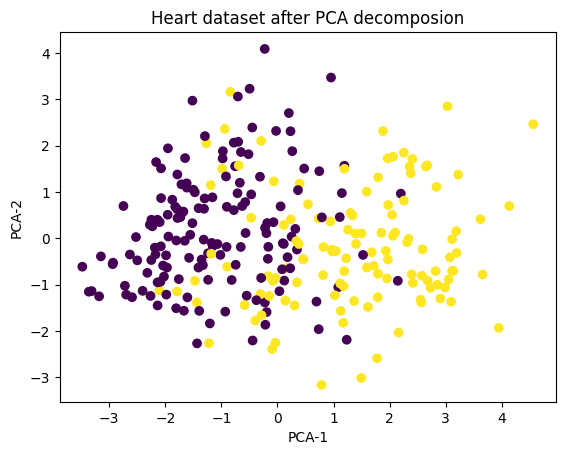

In [4]:
pca = PCA(n_components=2).fit_transform(X_scaled)

plt.scatter(pca[:,0], pca[:,1], c=Y)
plt.title('Heart dataset after PCA decomposion')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

In [4]:
MAXITR = 100
num_qubits = X.shape[1]
opt = COBYLA(maxiter=MAXITR)

In [ ]:
featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'ixq.json' not found in any of these locations: /usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/styles/ixq.json, ixq.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


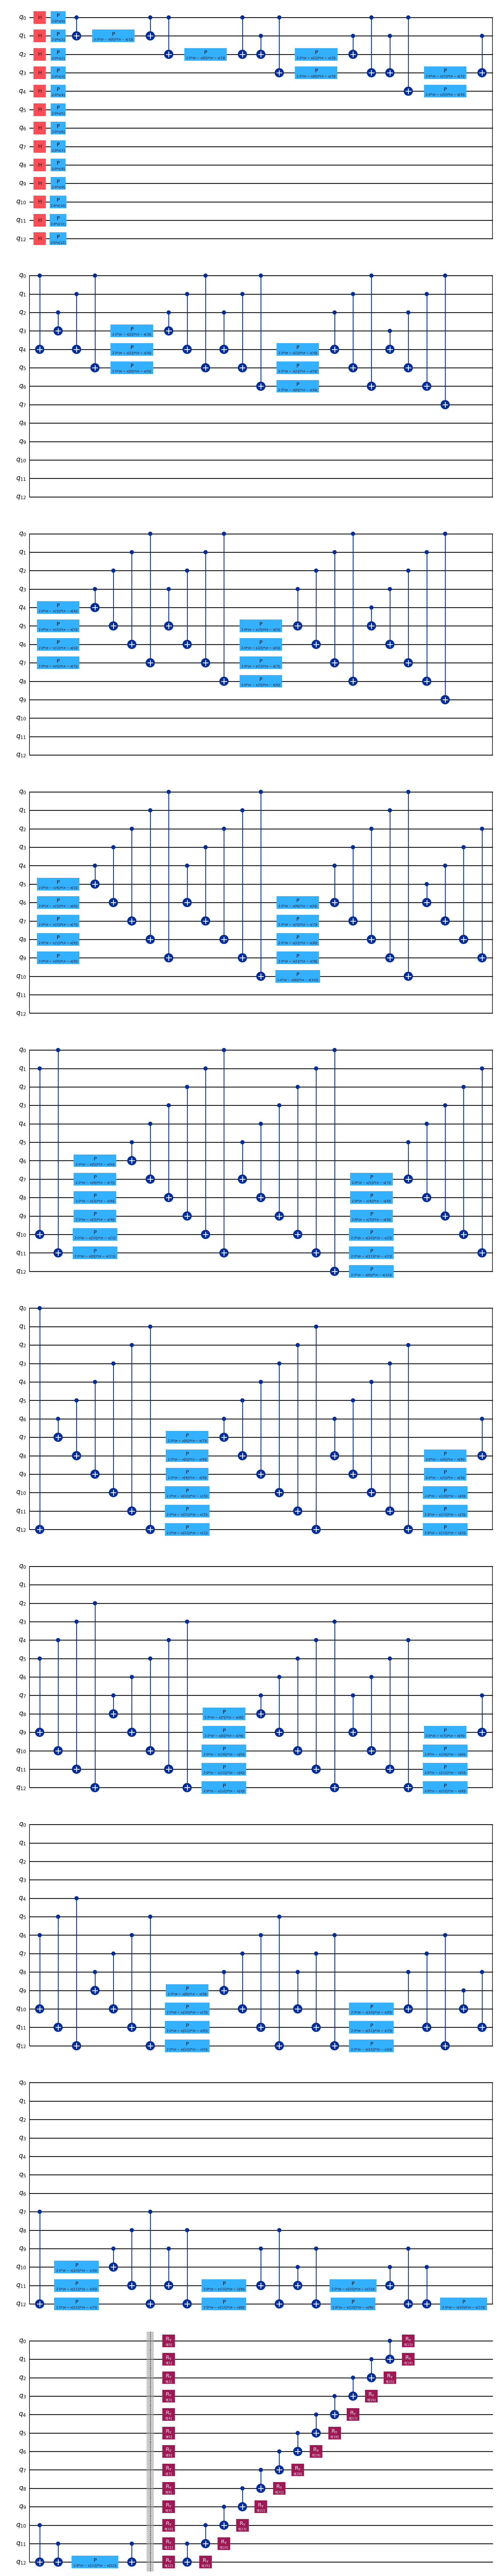

In [ ]:
qc = QuantumCircuit(num_qubits)
qc.compose(featuremap, inplace=True)
qc.barrier()
qc.compose(ansatz, inplace=True)
qc.decompose().draw(output='mpl', style='ixq')

In [5]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
  clear_output(wait=True)
  objective_func_vals.append(obj_func_eval)
  plt.title("Objective function value against iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Objective function value")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  plt.show()

In [ ]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []

In [ ]:
vqc = VQC(
    feature_map=featuremap,
    ansatz=ansatz,
    optimizer=opt,
    callback=callback_graph,
)

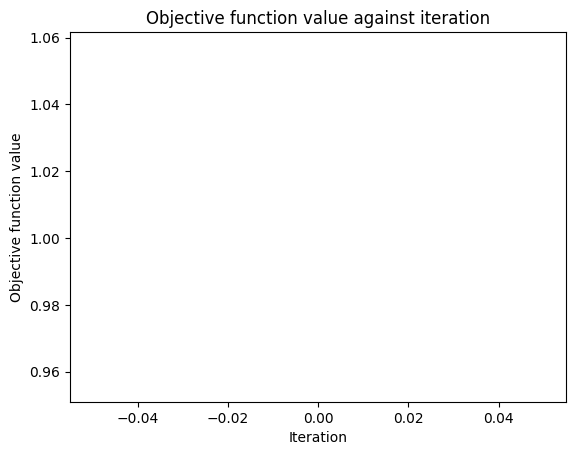

KeyboardInterrupt: 

In [ ]:
start = time.time()
vqc.fit(X_train, Y_train)
elapsed = time.time() - start

In [ ]:
preds = vqc.predict(X_test)
score = vqc.score(X_test, Y_test)
precision = precision_score(Y_test, preds, average='weighted')
accuracy = accuracy_score(Y_test, preds)
recall = recall_score(Y_test, preds, average='weighted')
f1 = f1_score(Y_test, preds, average='weighted')

In [ ]:
times.append(elapsed)
precisions.append(precision)
accuracies.append(accuracy)
recalls.append(recall)
f1s.append(f1)

In [ ]:
print("Precision:\n",precisions)
print("Accuracy:\n",accuracies)
print("Recall:\n",recalls)
print("F1:\n",f1s)
print("Time:\n",times)

# **EfficientSU2/RealAmplitudes**

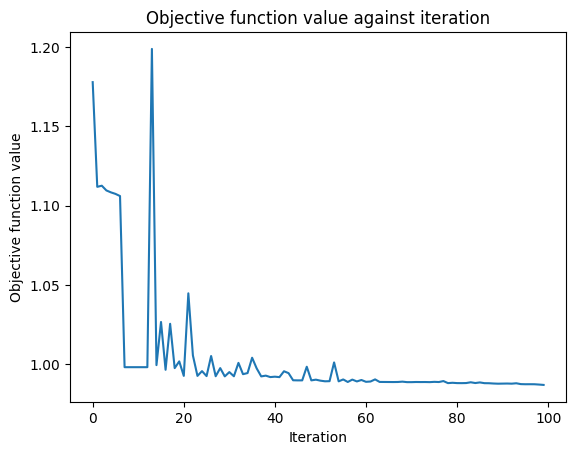

Precision:
 [0.4861111111111111, 0.475328947368421, 0.4900284900284901, 0.4900284900284901, 0.4900284900284901, 0.40885040885040885, 0.475328947368421, 0.5055555555555555, 0.4900284900284901, 0.5555555555555556]
Accuracy:
 [0.5, 0.5, 0.5185185185185185, 0.5185185185185185, 0.5185185185185185, 0.37037037037037035, 0.5, 0.5370370370370371, 0.5185185185185185, 0.5555555555555556]
Recall:
 [0.461038961038961, 0.45238095238095233, 0.4675324675324676, 0.4675324675324676, 0.4675324675324676, 0.38961038961038963, 0.45238095238095233, 0.4826839826839827, 0.4675324675324676, 0.5324675324675324]
F1:
 [0.4916387959866221, 0.48382185001903316, 0.4984567901234569, 0.4984567901234569, 0.4984567901234569, 0.37037037037037035, 0.48382185001903316, 0.512937595129376, 0.4984567901234569, 0.5555555555555556]
Time:
 [77.34919142723083, 80.19316530227661, 79.9885504245758, 80.04828310012817, 79.15946626663208, 78.46486282348633, 78.82099914550781, 82.99274587631226, 75.14943718910217, 60.62161087989807]


In [6]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.4861111111111111, 0.475328947368421, 0.4900284900284901, 0.4900284900284901, 0.4900284900284901, 0.40885040885040885, 0.475328947368421, 0.5055555555555555, 0.4900284900284901, 0.5555555555555556]

**Accuracy:**
 [0.5, 0.5, 0.5185185185185185, 0.5185185185185185, 0.5185185185185185, 0.37037037037037035, 0.5, 0.5370370370370371, 0.5185185185185185, 0.5555555555555556]

**Recall:**
 [0.461038961038961, 0.45238095238095233, 0.4675324675324676, 0.4675324675324676, 0.4675324675324676, 0.38961038961038963, 0.45238095238095233, 0.4826839826839827, 0.4675324675324676, 0.5324675324675324]

**F1:**
 [0.4916387959866221, 0.48382185001903316, 0.4984567901234569, 0.4984567901234569, 0.4984567901234569, 0.37037037037037035, 0.48382185001903316, 0.512937595129376, 0.4984567901234569, 0.5555555555555556]

**Time:**
 [77.34919142723083, 80.19316530227661, 79.9885504245758, 80.04828310012817, 79.15946626663208, 78.46486282348633, 78.82099914550781, 82.99274587631226, 75.14943718910217, 60.62161087989807]

Mean Precision: 0.48668444859234333±0.03385327130333391
Mean Accuracy: 0.5037037037037038±0.04743054990691
Mean Recall: 0.4640692640692641±0.03301415751504349
Mean F1: 0.48919731775738173±0.044151515665311114
Mean Time: 77.27883124351501±5.8777428128200375


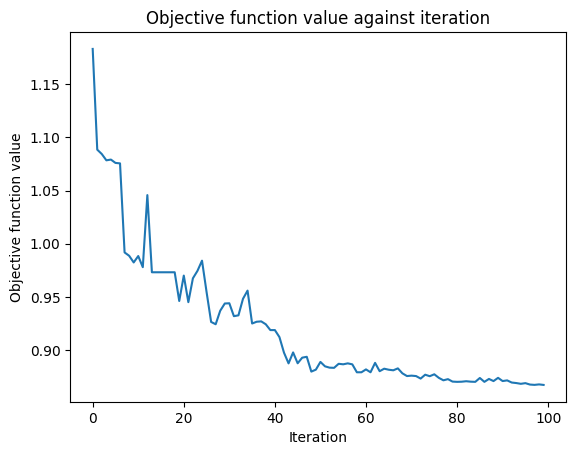

Precision:
 [0.5941697191697192, 0.6953703703703703, 0.5704248366013073, 0.6784188034188035, 0.6222222222222221, 0.6172839506172839, 0.5999688327879071, 0.5222013758599124, 0.718007662835249, 0.703448275862069]
Accuracy:
 [0.5740740740740741, 0.6851851851851852, 0.5740740740740741, 0.6481481481481481, 0.6111111111111112, 0.5925925925925926, 0.5925925925925926, 0.5555555555555556, 0.7037037037037037, 0.6666666666666666]
Recall:
 [0.5735930735930737, 0.6818181818181819, 0.5476190476190476, 0.6601731601731602, 0.6038961038961039, 0.5974025974025974, 0.5800865800865801, 0.49783549783549785, 0.7056277056277056, 0.6839826839826839]
F1:
 [0.5792737278611014, 0.6881834215167549, 0.5720584071512357, 0.6524078557976862, 0.6148148148148148, 0.5976851851851853, 0.5954861111111112, 0.5272919978802332, 0.7070282063269441, 0.6703448275862068]
Time:
 [72.49908089637756, 78.73571419715881, 78.13620400428772, 96.00776791572571, 95.41925764083862, 96.02940201759338, 95.75149297714233, 95.4918942451477, 9

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.5941697191697192, 0.6953703703703703, 0.5704248366013073, 0.6784188034188035, 0.6222222222222221, 0.6172839506172839, 0.5999688327879071, 0.5222013758599124, 0.718007662835249, 0.703448275862069]

**Accuracy:**
 [0.5740740740740741, 0.6851851851851852, 0.5740740740740741, 0.6481481481481481, 0.6111111111111112, 0.5925925925925926, 0.5925925925925926, 0.5555555555555556, 0.7037037037037037, 0.6666666666666666]

**Recall:**
 [0.5735930735930737, 0.6818181818181819, 0.5476190476190476, 0.6601731601731602, 0.6038961038961039, 0.5974025974025974, 0.5800865800865801, 0.49783549783549785, 0.7056277056277056, 0.6839826839826839]

**F1:**
 [0.5792737278611014, 0.6881834215167549, 0.5720584071512357, 0.6524078557976862, 0.6148148148148148, 0.5976851851851853, 0.5954861111111112, 0.5272919978802332, 0.7070282063269441, 0.6703448275862068]

**Time:**
 [72.49908089637756, 78.73571419715881, 78.13620400428772, 96.00776791572571, 95.41925764083862, 96.02940201759338, 95.75149297714233, 95.4918942451477, 95.84396195411682, 95.93709945678711]


**Mean Precision:** 0.6321516049744844±0.06106470746681569
**Mean Accuracy:** 0.6203703703703705±0.04917006684204354
**Mean Recall:** 0.6132034632034632±0.06409302531188693
**Mean F1:** 0.6204574555231274±0.05429846486879411
**Mean Time:** 89.98518753051758±8.990943765805145


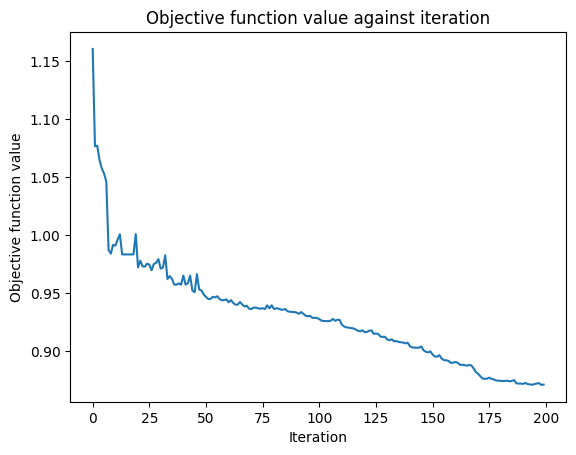

Precision:
 [0.6913580246913581, 0.6913580246913581, 0.7045177045177046, 0.7045177045177046, 0.7314814814814815, 0.7045177045177046, 0.5802469135802469, 0.7158119658119658, 0.703448275862069, 0.7045177045177046]
Accuracy:
 [0.6666666666666666, 0.6666666666666666, 0.6851851851851852, 0.6851851851851852, 0.6851851851851852, 0.6851851851851852, 0.5555555555555556, 0.6851851851851852, 0.6666666666666666, 0.6851851851851852]
Recall:
 [0.6753246753246753, 0.6753246753246753, 0.6904761904761905, 0.6904761904761905, 0.6038961038961039, 0.6904761904761905, 0.5584415584415584, 0.699134199134199, 0.6839826839826839, 0.6904761904761905]
F1:
 [0.6708333333333334, 0.6708333333333334, 0.6890284075495097, 0.6890284075495097, 0.6268861454046638, 0.6890284075495097, 0.5611111111111111, 0.6889965025558246, 0.6703448275862068, 0.6890284075495097]
Time:
 [193.74523210525513, 193.5769853591919, 206.20867228507996, 153.81514239311218, 156.0512731075287, 150.82224321365356, 148.81355333328247, 153.89923739433

In [8]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.6913580246913581, 0.6913580246913581, 0.7045177045177046, 0.7045177045177046, 0.7314814814814815, 0.7045177045177046, 0.5802469135802469, 0.7158119658119658, 0.703448275862069, 0.7045177045177046]

**Accuracy:**
 [0.6666666666666666, 0.6666666666666666, 0.6851851851851852, 0.6851851851851852, 0.6851851851851852, 0.6851851851851852, 0.5555555555555556, 0.6851851851851852, 0.6666666666666666, 0.6851851851851852]

**Recall:**
 [0.6753246753246753, 0.6753246753246753, 0.6904761904761905, 0.6904761904761905, 0.6038961038961039, 0.6904761904761905, 0.5584415584415584, 0.699134199134199, 0.6839826839826839, 0.6904761904761905]

**F1:**
 [0.6708333333333334, 0.6708333333333334, 0.6890284075495097, 0.6890284075495097, 0.6268861454046638, 0.6890284075495097, 0.5611111111111111, 0.6889965025558246, 0.6703448275862068, 0.6890284075495097]

**Time:**
 [193.74523210525513, 193.5769853591919, 206.20867228507996, 153.81514239311218, 156.0512731075287, 150.82224321365356, 148.81355333328247, 153.89923739433289, 148.51355171203613, 152.4503231048584]

Mean Precision: 0.6931775504189297±0.03919099661992594
Mean Accuracy:0.6666666666666667±0.037951669503554074
Mean Recall: 0.6658008658008658±0.044064501056616585
Mean F1: 0.6645118883522512±0.03901935028512201
Mean Time: 165.78962140083314±21.343774283285164


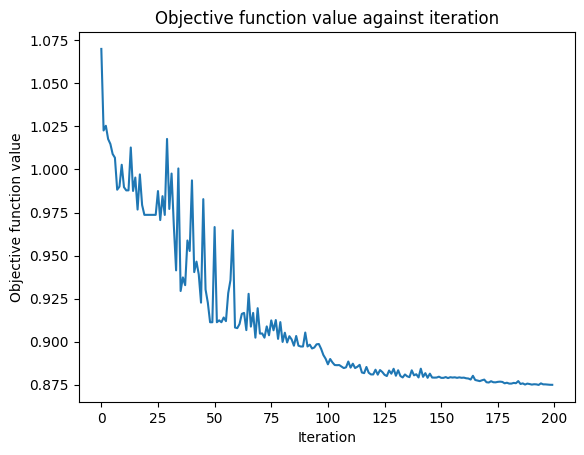

Precision:
 [0.6784188034188035, 0.6587962962962963, 0.718007662835249, 0.688888888888889, 0.7014800917239941, 0.7035024154589372, 0.5916666666666667, 0.7396011396011396, 0.6539351851851852, 0.6081226053639847]
Accuracy:
 [0.6481481481481481, 0.6481481481481481, 0.7037037037037037, 0.6851851851851852, 0.7037037037037037, 0.6851851851851852, 0.6111111111111112, 0.7407407407407407, 0.6481481481481481, 0.5925925925925926]
Recall:
 [0.6601731601731602, 0.6428571428571428, 0.7056277056277056, 0.6212121212121212, 0.6536796536796536, 0.6125541125541125, 0.5606060606060606, 0.7012987012987013, 0.564935064935065, 0.5887445887445888]
F1:
 [0.6524078557976862, 0.6514991181657849, 0.7070282063269441, 0.6518177163338452, 0.6848613319201554, 0.640525728696833, 0.5908675799086758, 0.7299382716049384, 0.5829903978052126, 0.5971637836995481]
Time:
 [191.1734709739685, 217.8346393108368, 220.26941084861755, 219.84568309783936, 215.91615557670593, 171.24316263198853, 171.2103509902954, 197.21007227897644

In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

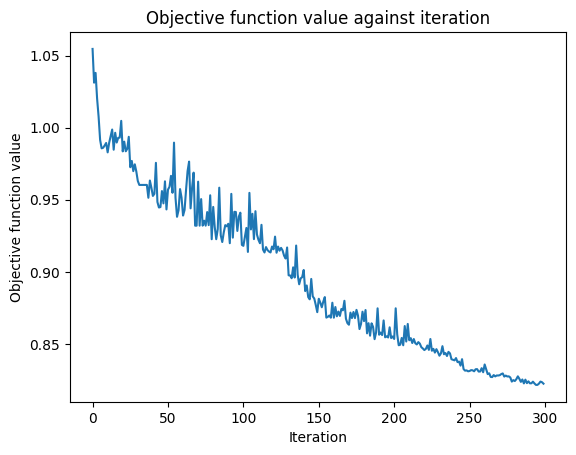

Precision:
 [0.7754385964912281, 0.6790123456790123, 0.6953703703703703, 0.6666666666666666, 0.6222222222222221, 0.6616541353383459, 0.7035024154589372, 0.677266081871345, 0.688888888888889, 0.7045177045177046]
Accuracy:
 [0.7777777777777778, 0.6851851851851852, 0.6851851851851852, 0.6666666666666666, 0.6111111111111112, 0.6666666666666666, 0.6851851851851852, 0.6851851851851852, 0.6851851851851852, 0.6851851851851852]
Recall:
 [0.7575757575757576, 0.6558441558441559, 0.6818181818181819, 0.5974025974025974, 0.6038961038961039, 0.6406926406926408, 0.6125541125541125, 0.6471861471861472, 0.6212121212121212, 0.6904761904761905]
F1:
 [0.7754901960784314, 0.6799207233989842, 0.6881834215167549, 0.6256410256410256, 0.6148148148148148, 0.6632352941176471, 0.640525728696833, 0.6749989426045764, 0.6518177163338452, 0.6890284075495097]
Time:
 [436.5874354839325, 432.0938141345978, 370.3983082771301, 334.8566138744354, 335.80167746543884, 335.00717306137085, 335.25785541534424, 335.59161591529846

In [13]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=5)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

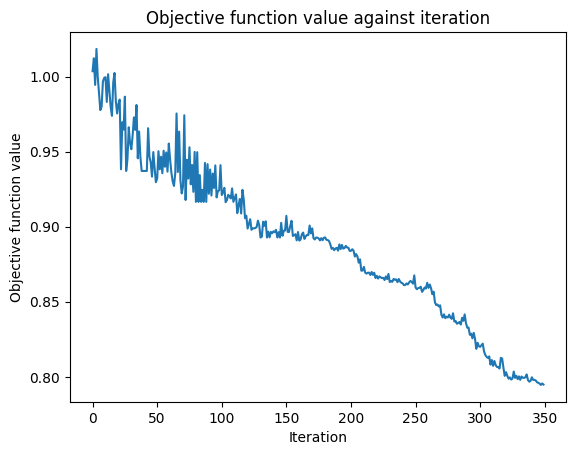

Precision:
 [0.6666666666666666, 0.718007662835249, 0.6100540286586799, 0.6416062801932367, 0.6995822890559732, 0.6342592592592593, 0.6566604127579738, 0.7175925925925926, 0.6995822890559732, 0.688888888888889]
Accuracy:
 [0.6666666666666666, 0.7037037037037037, 0.6296296296296297, 0.6481481481481481, 0.7037037037037037, 0.6481481481481481, 0.6666666666666666, 0.7222222222222222, 0.7037037037037037, 0.6851851851851852]
Recall:
 [0.5974025974025974, 0.7056277056277056, 0.5670995670995671, 0.5735930735930735, 0.6796536796536796, 0.5909090909090909, 0.6147186147186148, 0.6948051948051948, 0.6796536796536796, 0.6212121212121212]
F1:
 [0.6256410256410256, 0.7070282063269441, 0.5961257309941521, 0.598234637955284, 0.7006535947712419, 0.6212794612794612, 0.6454689984101749, 0.7175771088814565, 0.7006535947712419, 0.6518177163338452]
Time:
 [431.4839427471161, 431.93213295936584, 432.84425163269043, 449.84001994132996, 437.26980781555176, 438.92934107780457, 474.6056525707245, 557.127100229263

In [14]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=6)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

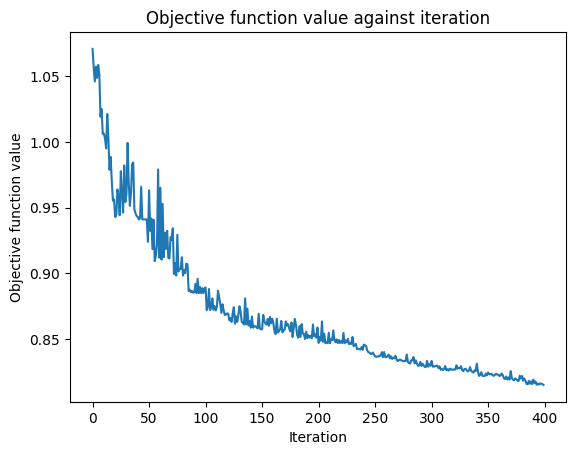

Precision:
 [0.698005698005698, 0.7369722663840311, 0.688888888888889, 0.6666666666666666, 0.7234567901234568, 0.6596194503171247, 0.688888888888889, 0.688888888888889, 0.6416062801932367, 0.7281746031746031]
Accuracy:
 [0.7037037037037037, 0.7407407407407407, 0.6851851851851852, 0.6666666666666666, 0.7037037037037037, 0.6666666666666666, 0.6851851851851852, 0.6851851851851852, 0.6481481481481481, 0.7222222222222222]
Recall:
 [0.6623376623376623, 0.7099567099567099, 0.6212121212121212, 0.5974025974025974, 0.6363636363636364, 0.6060606060606061, 0.6212121212121212, 0.6212121212121212, 0.5735930735930735, 0.6688311688311688]
F1:
 [0.6913580246913581, 0.7345029239766083, 0.6518177163338452, 0.6256410256410256, 0.6672364672364672, 0.6365131578947368, 0.6518177163338452, 0.6518177163338452, 0.598234637955284, 0.7010101010101011]
Time:
 [691.9150705337524, 695.3006291389465, 647.346676826477, 584.2029278278351, 668.2603290081024, 542.1936523914337, 555.1289627552032, 542.4853341579437, 564.1

In [15]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 400
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=7)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

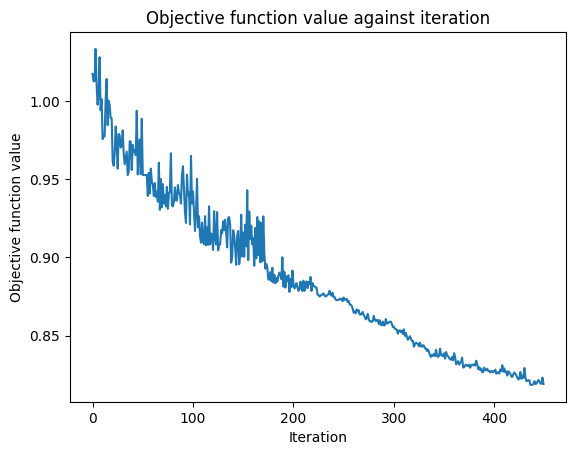

Precision:
 [0.7944444444444445, 0.7416666666666666, 0.6148148148148148, 0.7416666666666666, 0.8069444444444445, 0.6596194503171247, 0.7091848719755697, 0.6118407337919534, 0.7561728395061729, 0.6416062801932367]
Accuracy:
 [0.7592592592592593, 0.7222222222222222, 0.6296296296296297, 0.7222222222222222, 0.7962962962962963, 0.6666666666666666, 0.7037037037037037, 0.6296296296296297, 0.7592592592592593, 0.6481481481481481]
Recall:
 [0.6991341991341992, 0.6601731601731602, 0.5844155844155844, 0.6601731601731602, 0.7554112554112554, 0.6060606060606061, 0.645021645021645, 0.5757575757575758, 0.7337662337662338, 0.5735930735930735]
F1:
 [0.733742959549411, 0.6927803379416283, 0.6141975308641974, 0.6927803379416283, 0.7856925418569255, 0.6365131578947368, 0.6769005847953217, 0.6060766649001942, 0.7552334943639291, 0.598234637955284]
Time:
 [713.4246001243591, 661.4364290237427, 740.2210066318512, 848.7461316585541, 850.1324384212494, 804.4608204364777, 849.575926065445, 852.97478723526, 849.3

In [16]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 450
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=8)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

**Precision:**
 [0.6784188034188035, 0.6587962962962963, 0.718007662835249, 0.688888888888889, 0.7014800917239941, 0.7035024154589372, 0.5916666666666667, 0.7396011396011396, 0.6539351851851852, 0.6081226053639847]

**Accuracy:**
 [0.6481481481481481, 0.6481481481481481, 0.7037037037037037, 0.6851851851851852, 0.7037037037037037, 0.6851851851851852, 0.6111111111111112, 0.7407407407407407, 0.6481481481481481, 0.5925925925925926]

**Recall:**
 [0.6601731601731602, 0.6428571428571428, 0.7056277056277056, 0.6212121212121212, 0.6536796536796536, 0.6125541125541125, 0.5606060606060606, 0.7012987012987013, 0.564935064935065, 0.5887445887445888]

**F1:**
 [0.6524078557976862, 0.6514991181657849, 0.7070282063269441, 0.6518177163338452, 0.6848613319201554, 0.640525728696833, 0.5908675799086758, 0.7299382716049384, 0.5829903978052126, 0.5971637836995481]

**Time:**
 [191.1734709739685, 217.8346393108368, 220.26941084861755, 219.84568309783936, 215.91615557670593, 171.24316263198853, 171.2103509902954, 197.21007227897644, 222.01787757873535, 224.9162895679474]

Mean Precision: 0.6742419755439145±0.04456311196526911
Mean Accuracy: 0.6666666666666666±0.04303314829119352
Mean Recall: 0.631168831168831±0.048537000399576195
Mean F1: 0.6489099990259624±0.04661060148226907
Mean Time: 205.16371128559112±19.89110025816622


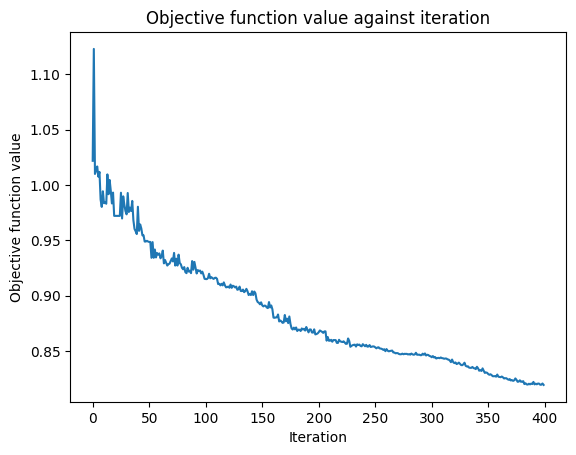

Precision:
 [0.7532051282051282, 0.724905303030303, 0.6564102564102564, 0.688131313131313, 0.7905982905982906, 0.8050925925925926, 0.757207417796478, 0.7413026819923372, 0.7158119658119658, 0.8050925925925926]
Accuracy:
 [0.7222222222222222, 0.7222222222222222, 0.6666666666666666, 0.6851851851851852, 0.7592592592592593, 0.7962962962962963, 0.7037037037037037, 0.7037037037037037, 0.6851851851851852, 0.7962962962962963]
Recalls:
 [0.7380952380952381, 0.7121212121212122, 0.6233766233766234, 0.6731601731601732, 0.777056277056277, 0.7987012987012987, 0.7316017316017316, 0.722943722943723, 0.699134199134199, 0.7987012987012987]
F1:
 [0.7255851493139629, 0.7233154442456767, 0.6527777777777778, 0.6864241701451003, 0.7621737960721012, 0.798236331569665, 0.7057387057387058, 0.7069731800766285, 0.6889965025558246, 0.798236331569665]
Time:
 [473.1028838157654, 478.93654894828796, 479.8513460159302, 472.47191166877747, 370.17355132102966, 458.2792692184448, 473.2692093849182, 381.01252818107605, 36

In [6]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 400
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7532051282051282, 0.724905303030303, 0.6564102564102564, 0.688131313131313, 0.7905982905982906, 0.8050925925925926, 0.757207417796478, 0.7413026819923372, 0.7158119658119658, 0.8050925925925926]
Accuracy:
 [0.7222222222222222, 0.7222222222222222, 0.6666666666666666, 0.6851851851851852, 0.7592592592592593, 0.7962962962962963, 0.7037037037037037, 0.7037037037037037, 0.6851851851851852, 0.7962962962962963]
Recalls:
 [0.7380952380952381, 0.7121212121212122, 0.6233766233766234, 0.6731601731601732, 0.777056277056277, 0.7987012987012987, 0.7316017316017316, 0.722943722943723, 0.699134199134199, 0.7987012987012987]
F1:
 [0.7255851493139629, 0.7233154442456767, 0.6527777777777778, 0.6864241701451003, 0.7621737960721012, 0.798236331569665, 0.7057387057387058, 0.7069731800766285, 0.6889965025558246, 0.798236331569665]
Time:
 [473.1028838157654, 478.93654894828796, 479.8513460159302, 472.47191166877747, 370.17355132102966, 458.2792692184448, 473.2692093849182, 381.01252818107605, 369.93186020851135, 369.9914321899414]
Mean Precision: 0.7437757542161257±0.04674868921926333
Mean Accuracy: 0.7240740740740741±0.04339027597725918
Mean Recall: 0.7274891774891775±0.05251717466388506
Mean F1: 0.7248457389065108±0.04561613021073379
Mean Time: 432.70205409526824±49.32421410115236


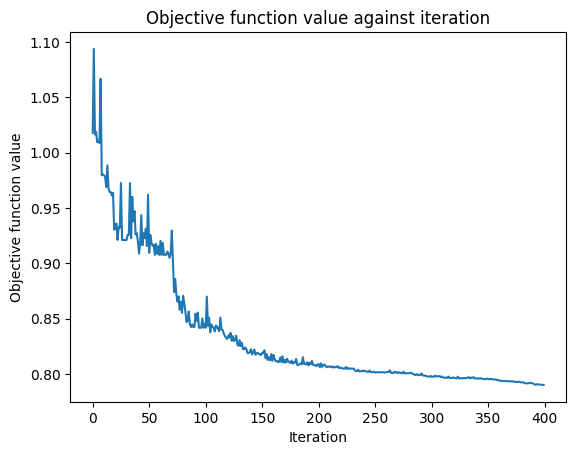

Precision:
 [0.7098332554153031, 0.8050925925925926, 0.6365903069970392, 0.7045177045177046, 0.7532051282051282, 0.7791570881226053, 0.7158119658119658, 0.7963222689730403, 0.7984532828282829, 0.7045177045177046]
Accuracy:
 [0.7037037037037037, 0.7962962962962963, 0.6296296296296297, 0.6851851851851852, 0.7222222222222222, 0.7407407407407407, 0.6851851851851852, 0.7407407407407407, 0.7962962962962963, 0.6851851851851852]
Recalls:
 [0.696969696969697, 0.7987012987012987, 0.6190476190476191, 0.6904761904761905, 0.7380952380952381, 0.7619047619047619, 0.699134199134199, 0.7705627705627706, 0.7900432900432901, 0.6904761904761905]
F1:
 [0.7058080808080809, 0.798236331569665, 0.632260101010101, 0.6890284075495097, 0.7255851493139629, 0.7436015325670497, 0.6889965025558246, 0.7425213675213675, 0.7970979924468297, 0.6890284075495097]
Time:
 [540.665379524231, 544.4651439189911, 534.6998429298401, 460.9912292957306, 429.6517062187195, 475.5588889122009, 543.4967665672302, 516.0031809806824, 540

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 400
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7098332554153031, 0.8050925925925926, 0.6365903069970392, 0.7045177045177046, 0.7532051282051282, 0.7791570881226053, 0.7158119658119658, 0.7963222689730403, 0.7984532828282829, 0.7045177045177046]
Accuracy:
 [0.7037037037037037, 0.7962962962962963, 0.6296296296296297, 0.6851851851851852, 0.7222222222222222, 0.7407407407407407, 0.6851851851851852, 0.7407407407407407, 0.7962962962962963, 0.6851851851851852]
Recalls:
 [0.696969696969697, 0.7987012987012987, 0.6190476190476191, 0.6904761904761905, 0.7380952380952381, 0.7619047619047619, 0.699134199134199, 0.7705627705627706, 0.7900432900432901, 0.6904761904761905]
F1:
 [0.7058080808080809, 0.798236331569665, 0.632260101010101, 0.6890284075495097, 0.7255851493139629, 0.7436015325670497, 0.6889965025558246, 0.7425213675213675, 0.7970979924468297, 0.6890284075495097]
Time:
 [540.665379524231, 544.4651439189911, 534.6998429298401, 460.9912292957306, 429.6517062187195, 475.5588889122009, 543.4967665672302, 516.0031809806824, 540.7143120765686, 544.6102018356323]
Mean Precision: 0.7403501297981367±0.05219109271472688
Mean Accuracy: 0.7185185185185186±0.04955217837133202
Mean Recall: 0.7255411255411256±0.05322915275929698
Mean F1: 0.7212163872891899±0.04891325243792257
Mean Time: 513.0856652259827±39.982852863280534


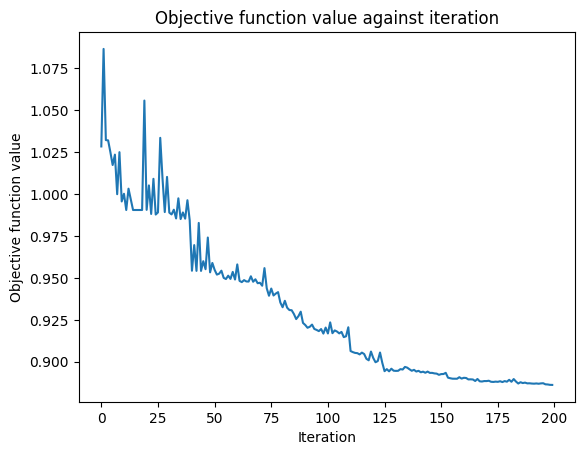

Precision:
 [0.7413003663003663, 0.6789777154433536, 0.6677350427350427, 0.7098332554153031, 0.6543209876543209, 0.724905303030303, 0.6143518518518518, 0.724905303030303, 0.6913580246913581, 0.7146198830409356]
Accuracy:
 [0.7222222222222222, 0.6296296296296297, 0.6481481481481481, 0.7037037037037037, 0.6296296296296297, 0.7222222222222222, 0.5740740740740741, 0.7222222222222222, 0.6666666666666666, 0.6296296296296297]
Recalls:
 [0.7294372294372294, 0.6536796536796536, 0.6515151515151515, 0.696969696969697, 0.6363636363636364, 0.7121212121212122, 0.5909090909090908, 0.7121212121212122, 0.6753246753246753, 0.670995670995671]
F1:
 [0.7256133007789792, 0.6321733821733821, 0.6524435143200404, 0.7058080808080809, 0.6342592592592593, 0.7233154442456767, 0.5780300424263273, 0.7233154442456767, 0.6708333333333334, 0.6260683760683761]
Time:
 [161.16599941253662, 163.34184098243713, 162.26685404777527, 162.10344743728638, 161.39309906959534, 202.21636843681335, 213.61243724822998, 210.8761937618

In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 200
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7413003663003663, 0.6789777154433536, 0.6677350427350427, 0.7098332554153031, 0.6543209876543209, 0.724905303030303, 0.6143518518518518, 0.724905303030303, 0.6913580246913581, 0.7146198830409356]
Accuracy:
 [0.7222222222222222, 0.6296296296296297, 0.6481481481481481, 0.7037037037037037, 0.6296296296296297, 0.7222222222222222, 0.5740740740740741, 0.7222222222222222, 0.6666666666666666, 0.6296296296296297]
Recalls:
 [0.7294372294372294, 0.6536796536796536, 0.6515151515151515, 0.696969696969697, 0.6363636363636364, 0.7121212121212122, 0.5909090909090908, 0.7121212121212122, 0.6753246753246753, 0.670995670995671]
F1:
 [0.7256133007789792, 0.6321733821733821, 0.6524435143200404, 0.7058080808080809, 0.6342592592592593, 0.7233154442456767, 0.5780300424263273, 0.7233154442456767, 0.6708333333333334, 0.6260683760683761]
Time:
 [161.16599941253662, 163.34184098243713, 162.26685404777527, 162.10344743728638, 161.39309906959534, 202.21636843681335, 213.61243724822998, 210.87619376182556, 214.493825674057, 187.26149821281433]
Mean Precision: 0.6922307733193139±0.03692278247539098
Mean Accuracy: 0.6648148148148147±0.04860890647558032
Mean Recall: 0.672943722943723±0.039681293434451266
Mean F1: 0.6671860177659132±0.048359678432478376
Mean Time: 183.8731564283371±22.983524371726002


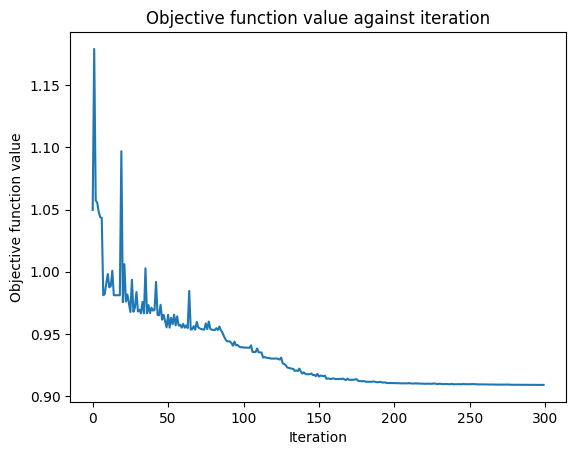

Precision:
 [0.7532051282051282, 0.7037037037037037, 0.6789777154433536, 0.7673202614379085, 0.7200980392156863, 0.6953703703703703, 0.746454729624435, 0.7465277777777778, 0.6953703703703703, 0.6789777154433536]
Accuracy:
 [0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.6851851851851852, 0.7222222222222222, 0.6851851851851852, 0.7407407407407407, 0.6851851851851852, 0.6851851851851852, 0.6296296296296297]
Recalls:
 [0.7380952380952381, 0.6883116883116883, 0.6536796536796536, 0.725108225108225, 0.7034632034632035, 0.6818181818181819, 0.7359307359307359, 0.7164502164502164, 0.6818181818181819, 0.6536796536796536]
F1:
 [0.7255851493139629, 0.7037037037037037, 0.6321733821733821, 0.6837812083095102, 0.7209076568377624, 0.6881834215167549, 0.7425820707070706, 0.6863731656184486, 0.6881834215167549, 0.6321733821733821]
Time:
 [278.13315868377686, 274.39895248413086, 295.9611201286316, 328.2728159427643, 323.06923747062683, 299.64327907562256, 251.81545686721802, 314.8176946640

In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7532051282051282, 0.7037037037037037, 0.6789777154433536, 0.7673202614379085, 0.7200980392156863, 0.6953703703703703, 0.746454729624435, 0.7465277777777778, 0.6953703703703703, 0.6789777154433536]
Accuracy:
 [0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.6851851851851852, 0.7222222222222222, 0.6851851851851852, 0.7407407407407407, 0.6851851851851852, 0.6851851851851852, 0.6296296296296297]
Recalls:
 [0.7380952380952381, 0.6883116883116883, 0.6536796536796536, 0.725108225108225, 0.7034632034632035, 0.6818181818181819, 0.7359307359307359, 0.7164502164502164, 0.6818181818181819, 0.6536796536796536]
F1:
 [0.7255851493139629, 0.7037037037037037, 0.6321733821733821, 0.6837812083095102, 0.7209076568377624, 0.6881834215167549, 0.7425820707070706, 0.6863731656184486, 0.6881834215167549, 0.6321733821733821]
Time:
 [278.13315868377686, 274.39895248413086, 295.9611201286316, 328.2728159427643, 323.06923747062683, 299.64327907562256, 251.81545686721802, 314.81769466400146, 605.4483723640442, 322.3455579280853]
Mean Precision: 0.7186005811592088±0.030935823119198583
Mean Accuracy: 0.6888888888888889±0.034940670859468885
Mean Recall: 0.6978354978354979±0.029491292346755148
Mean F1: 0.6903646561870733±0.034524172238616244
Mean Time: 329.3905645608902±94.96465004476913


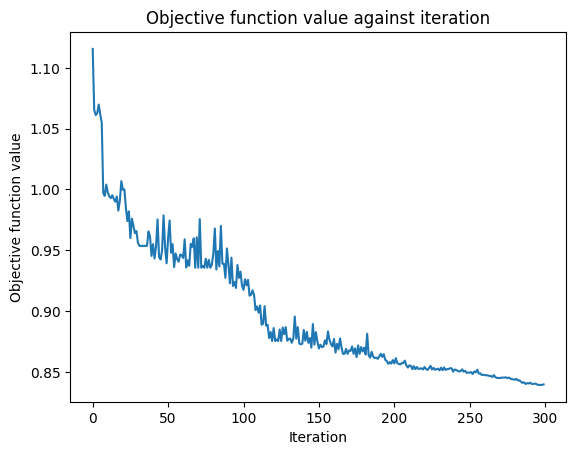

Precision:
 [0.724905303030303, 0.7654320987654322, 0.791264367816092, 0.718007662835249, 0.7546360153256705, 0.7780830280830281, 0.724905303030303, 0.827991452991453, 0.6784188034188035, 0.856319152251831]
Accuracy:
 [0.7222222222222222, 0.7407407407407407, 0.7777777777777778, 0.7037037037037037, 0.7407407407407407, 0.7592592592592593, 0.7222222222222222, 0.7962962962962963, 0.6481481481481481, 0.8518518518518519]
Recalls:
 [0.7121212121212122, 0.7532467532467533, 0.7835497835497836, 0.7056277056277056, 0.7445887445887446, 0.7683982683982684, 0.7121212121212122, 0.8160173160173161, 0.6601731601731602, 0.8528138528138528]
F1:
 [0.7233154442456767, 0.7439814814814815, 0.7802711547452081, 0.7070282063269441, 0.743649680536076, 0.7621981940084487, 0.7233154442456767, 0.7987624428302396, 0.6524078557976862, 0.8529040404040406]
Time:
 [450.17676067352295, 442.5671980381012, 434.6310567855835, 443.89887976646423, 369.98888206481934, 345.6994082927704, 343.5382454395294, 346.12680554389954, 3

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=5)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

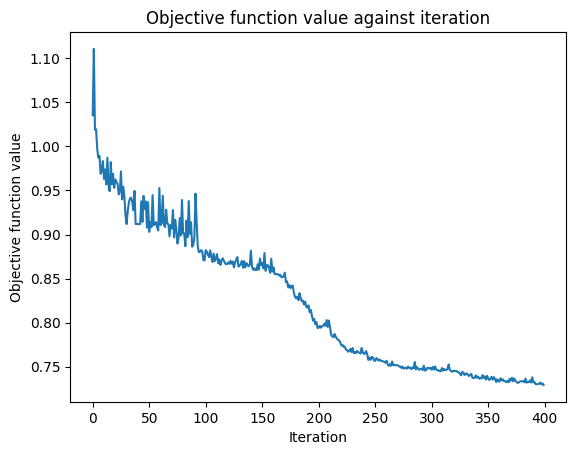

Precision:
 [0.8352272727272727, 0.7791570881226053, 0.791264367816092, 0.7791570881226053, 0.7616792929292928, 0.728395061728395, 0.7777777777777778, 0.7680555555555556, 0.791264367816092, 0.6913580246913581]
Accuracy:
 [0.8333333333333334, 0.7407407407407407, 0.7777777777777778, 0.7407407407407407, 0.7592592592592593, 0.7037037037037037, 0.7777777777777778, 0.7222222222222222, 0.7777777777777778, 0.6666666666666666]
Recalls:
 [0.829004329004329, 0.7619047619047619, 0.7835497835497836, 0.7619047619047619, 0.751082251082251, 0.7142857142857142, 0.7662337662337663, 0.7467532467532467, 0.7835497835497836, 0.6753246753246753]
F1:
 [0.833989266547406, 0.7436015325670497, 0.7802711547452081, 0.7436015325670497, 0.7602067183462532, 0.7074074074074075, 0.7777777777777778, 0.7248022015823873, 0.7802711547452081, 0.6708333333333334]
Time:
 [510.16108655929565, 509.59401202201843, 509.07727909088135, 508.17381978034973, 508.0994191169739, 508.3779413700104, 508.7933340072632, 509.3027865886688, 

In [8]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 400
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=6)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

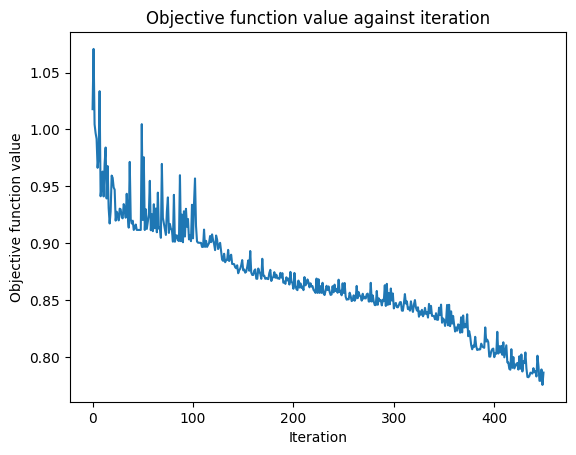

Precision:
 [0.7532051282051282, 0.7546360153256705, 0.728395061728395, 0.7532051282051282, 0.7532051282051282, 0.7984532828282829, 0.7616792929292928, 0.7780830280830281, 0.7654320987654322, 0.7963222689730403]
Accuracy:
 [0.7222222222222222, 0.7407407407407407, 0.7037037037037037, 0.7222222222222222, 0.7222222222222222, 0.7962962962962963, 0.7592592592592593, 0.7592592592592593, 0.7407407407407407, 0.7407407407407407]
Recalls:
 [0.7380952380952381, 0.7445887445887446, 0.7142857142857142, 0.7380952380952381, 0.7380952380952381, 0.7900432900432901, 0.751082251082251, 0.7683982683982684, 0.7532467532467533, 0.7705627705627706]
F1:
 [0.7255851493139629, 0.743649680536076, 0.7074074074074075, 0.7255851493139629, 0.7255851493139629, 0.7970979924468297, 0.7602067183462532, 0.7621981940084487, 0.7439814814814815, 0.7425213675213675]
Time:
 [624.3555154800415, 677.9540286064148, 792.2879590988159, 676.0883963108063, 700.7778897285461, 798.1974709033966, 651.4011881351471, 650.7769184112549, 6

In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 450
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=7)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

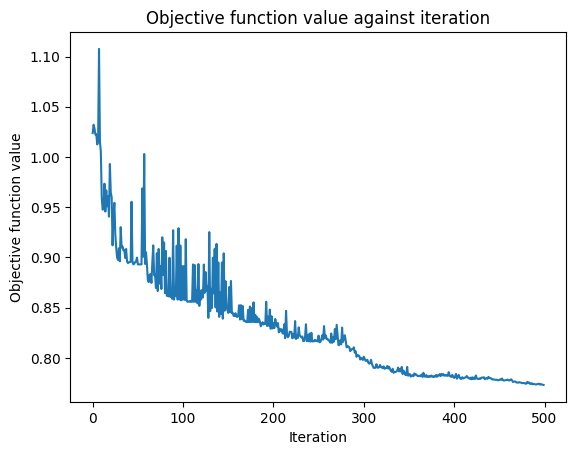

Precision:
 [0.7780830280830281, 0.7413003663003663, 0.7654320987654322, 0.8050925925925926, 0.8064814814814815, 0.8323529411764705, 0.8064814814814815, 0.746454729624435, 0.8518518518518519, 0.7780830280830281]
Accuracy:
 [0.7592592592592593, 0.7222222222222222, 0.7407407407407407, 0.7962962962962963, 0.7592592592592593, 0.8333333333333334, 0.7592592592592593, 0.7407407407407407, 0.8518518518518519, 0.7592592592592593]
Recalls:
 [0.7683982683982684, 0.7294372294372294, 0.7532467532467533, 0.7987012987012987, 0.7857142857142857, 0.8203463203463204, 0.7857142857142857, 0.7359307359307359, 0.8441558441558441, 0.7683982683982684]
F1:
 [0.7621981940084487, 0.7256133007789792, 0.7439814814814815, 0.798236331569665, 0.7614952413714023, 0.8325445941026575, 0.7614952413714023, 0.7425820707070706, 0.8518518518518519, 0.7621981940084487]
Time:
 [750.4050571918488, 751.8612563610077, 819.2974057197571, 938.7942516803741, 750.442015171051, 752.423850774765, 792.1533596515656, 900.2799501419067, 78

In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 500
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=8)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

# **EfficientSU2/TwoLocal**

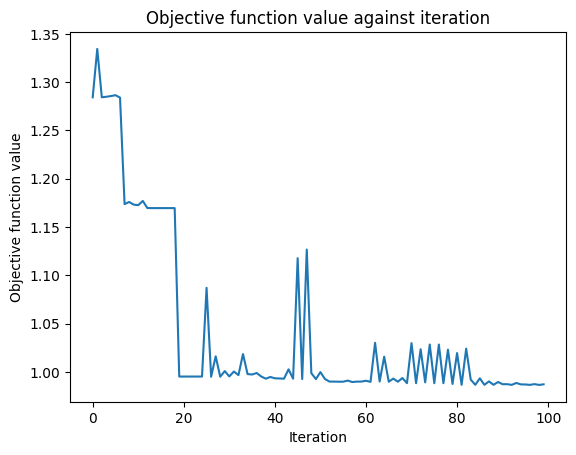

Precision:
 [0.5157163742690059, 0.4194444444444445, 0.5006182653241477, 0.6280701754385964, 0.5868055555555556, 0.48148148148148145, 0.5316239316239317, 0.47738169689389204, 0.5099415204678363, 0.5246913580246914]
Accuracy:
 [0.5370370370370371, 0.46296296296296297, 0.5185185185185185, 0.5555555555555556, 0.5370370370370371, 0.48148148148148145, 0.5555555555555556, 0.5185185185185185, 0.5185185185185185, 0.5370370370370371]
Recall:
 [0.49134199134199136, 0.40476190476190477, 0.47619047619047616, 0.5930735930735931, 0.5606060606060606, 0.4545454545454546, 0.5064935064935066, 0.4588744588744589, 0.48484848484848486, 0.5]
F1:
 [0.5220572685361416, 0.4350076103500761, 0.5069340016708438, 0.5512820512820513, 0.5387840670859538, 0.48148148148148145, 0.5370370370370371, 0.4878996643702526, 0.5135620915032679, 0.5292951814690945]
Time:
 [112.02085971832275, 118.18335509300232, 119.27915644645691, 120.80882978439331, 117.69941592216492, 118.90780806541443, 126.04792475700378, 123.6956186294555

In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 150
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  

**Precision:**
 [0.5157163742690059, 0.4194444444444445, 0.5006182653241477, 0.6280701754385964, 0.5868055555555556, 0.48148148148148145, 0.5316239316239317, 0.47738169689389204, 0.5099415204678363, 0.5246913580246914]

**Accuracy:**
 [0.5370370370370371, 0.46296296296296297, 0.5185185185185185, 0.5555555555555556, 0.5370370370370371, 0.48148148148148145, 0.5555555555555556, 0.5185185185185185, 0.5185185185185185, 0.5370370370370371]
 
**Recall:**
 [0.49134199134199136, 0.40476190476190477, 0.47619047619047616, 0.5930735930735931, 0.5606060606060606, 0.4545454545454546, 0.5064935064935066, 0.4588744588744589, 0.48484848484848486, 0.5]

**F1:**
 [0.5220572685361416, 0.4350076103500761, 0.5069340016708438, 0.5512820512820513, 0.5387840670859538, 0.48148148148148145, 0.5370370370370371, 0.4878996643702526, 0.5135620915032679, 0.5292951814690945]

**Time:**
 [112.02085971832275, 118.18335509300232, 119.27915644645691, 120.80882978439331, 117.69941592216492, 118.90780806541443, 126.04792475700378, 123.69561862945557, 119.78796601295471, 115.16190934181213]

Mean Precision: 0.5175774803523583±0.05490644184887261
Mean Accuracy: 0.5222222222222221±0.028448687955068937
Mean Recall: 0.4930735930735931±0.0505938201528281
Mean F1: 0.51033404547862±0.032753588531550845
Mean Time: 119.15928437709809±3.758261734979687


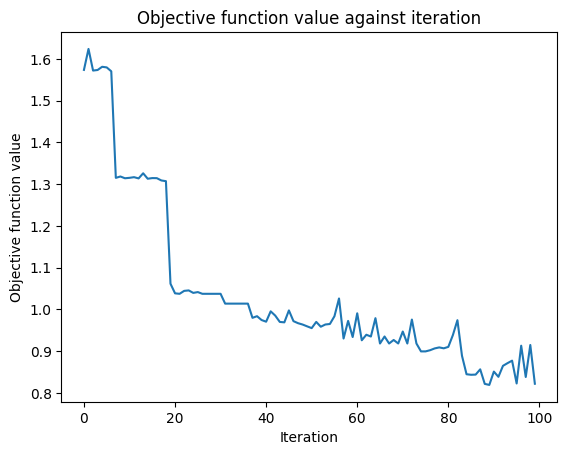

Precision:
 [0.6790123456790123, 0.7532051282051282, 0.6616541353383459, 0.6808510638297873, 0.7035024154589372, 0.549074074074074, 0.7208333333333333, 0.65818759936407, 0.6347222222222223, 0.6812169312169312]
Accuracy:
 [0.6851851851851852, 0.7222222222222222, 0.6666666666666666, 0.6666666666666666, 0.6851851851851852, 0.5370370370370371, 0.7222222222222222, 0.6666666666666666, 0.6481481481481481, 0.6851851851851852]
Recall:
 [0.6558441558441559, 0.7380952380952381, 0.6406926406926408, 0.5887445887445888, 0.6125541125541125, 0.525974025974026, 0.6774891774891775, 0.632034632034632, 0.5995670995670996, 0.6298701298701299]
F1:
 [0.6799207233989842, 0.7255851493139629, 0.6632352941176471, 0.6125, 0.640525728696833, 0.5414462081128748, 0.7077625570776255, 0.6586466165413534, 0.6298325722983257, 0.6611447811447811]
Time:
 [147.17748093605042, 155.76953792572021, 173.38553762435913, 158.28072118759155, 182.13984847068787, 176.92616748809814, 183.35962796211243, 192.69726514816284, 171.37487

In [12]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.6790123456790123, 0.7532051282051282, 0.6616541353383459, 0.6808510638297873, 0.7035024154589372, 0.549074074074074, 0.7208333333333333, 0.65818759936407, 0.6347222222222223, 0.6812169312169312]
Accuracy:
 [0.6851851851851852, 0.7222222222222222, 0.6666666666666666, 0.6666666666666666, 0.6851851851851852, 0.5370370370370371, 0.7222222222222222, 0.6666666666666666, 0.6481481481481481, 0.6851851851851852]
Recall:
 [0.6558441558441559, 0.7380952380952381, 0.6406926406926408, 0.5887445887445888, 0.6125541125541125, 0.525974025974026, 0.6774891774891775, 0.632034632034632, 0.5995670995670996, 0.6298701298701299]
F1:
 [0.6799207233989842, 0.7255851493139629, 0.6632352941176471, 0.6125, 0.640525728696833, 0.5414462081128748, 0.7077625570776255, 0.6586466165413534, 0.6298325722983257, 0.6611447811447811]
Time:
 [147.17748093605042, 155.76953792572021, 173.38553762435913, 158.28072118759155, 182.13984847068787, 176.92616748809814, 183.35962796211243, 192.69726514816284, 171.37487626075745, 148.38873648643494]

Mean Precision: 0.6722259248721841±0.05194377778150469
Mean Accuracy: 0.6685185185185184±0.04930935909516424
Mean Recall: 0.6300865800865801±0.053366721572376874
Mean F1: 0.6520599630702388±0.04895227148134345
Mean Time: 168.9499799489975±14.89658210438676



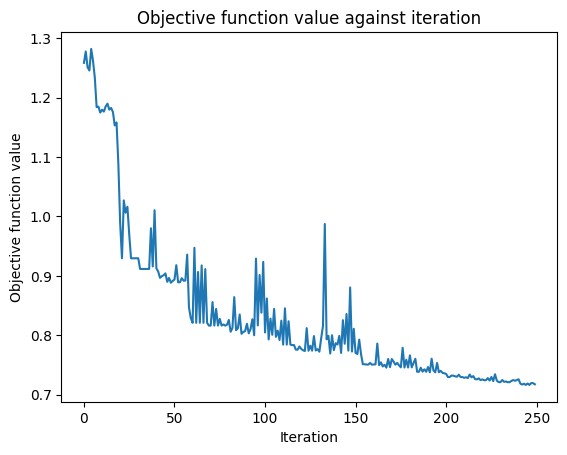

Precision:
 [0.6118407337919534, 0.7091848719755697, 0.7561728395061729, 0.7754385964912281, 0.7462997706900146, 0.6777777777777778, 0.6564102564102564, 0.6148148148148148, 0.6812169312169312, 0.7396011396011396]
Accuracy:
 [0.6296296296296297, 0.7037037037037037, 0.7592592592592593, 0.7777777777777778, 0.7407407407407407, 0.6851851851851852, 0.6666666666666666, 0.6296296296296297, 0.6851851851851852, 0.7407407407407407]
Recall:
 [0.5757575757575758, 0.645021645021645, 0.7337662337662338, 0.7575757575757576, 0.6926406926406926, 0.6385281385281385, 0.6233766233766234, 0.5844155844155844, 0.6298701298701299, 0.7012987012987013]
F1:
 [0.6060766649001942, 0.6769005847953217, 0.7552334943639291, 0.7754901960784314, 0.724253665430136, 0.6687975646879757, 0.6527777777777778, 0.6141975308641974, 0.6611447811447811, 0.7299382716049384]
Time:
 [286.09273624420166, 286.32878613471985, 286.3662095069885, 286.10824275016785, 286.4832389354706, 285.9519214630127, 286.91817116737366, 286.034322500228

In [12]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 250
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.6118407337919534, 0.7091848719755697, 0.7561728395061729, 0.7754385964912281, 0.7462997706900146, 0.6777777777777778, 0.6564102564102564, 0.6148148148148148, 0.6812169312169312, 0.7396011396011396]
Accuracy:
 [0.6296296296296297, 0.7037037037037037, 0.7592592592592593, 0.7777777777777778, 0.7407407407407407, 0.6851851851851852, 0.6666666666666666, 0.6296296296296297, 0.6851851851851852, 0.7407407407407407]
Recall:
 [0.5757575757575758, 0.645021645021645, 0.7337662337662338, 0.7575757575757576, 0.6926406926406926, 0.6385281385281385, 0.6233766233766234, 0.5844155844155844, 0.6298701298701299, 0.7012987012987013]
F1:
 [0.6060766649001942, 0.6769005847953217, 0.7552334943639291, 0.7754901960784314, 0.724253665430136, 0.6687975646879757, 0.6527777777777778, 0.6141975308641974, 0.6611447811447811, 0.7299382716049384]
Time:
 [286.09273624420166, 286.32878613471985, 286.3662095069885, 286.10824275016785, 286.4832389354706, 285.9519214630127, 286.91817116737366, 286.0343225002289, 286.9685101509094, 287.3837444782257]
Mean Precision: 0.6968757732275859±0.05506388224540732
Mean Accuracy: 0.701851851851852±0.04930935909516424
Mean Recall: 0.6582251082251083±0.05783272733598044
Mean F1: 0.6864810531647683±0.05462318885228313
Mean Time: 286.4635883331299±0.45234867499866427


**Precision:**
 [0.6790123456790123, 0.7532051282051282, 0.6616541353383459, 0.6808510638297873, 0.7035024154589372, 0.549074074074074, 0.7208333333333333, 0.65818759936407, 0.6347222222222223, 0.6812169312169312]

**Accuracy:**
 [0.6851851851851852, 0.7222222222222222, 0.6666666666666666, 0.6666666666666666, 0.6851851851851852, 0.5370370370370371, 0.7222222222222222, 0.6666666666666666, 0.6481481481481481, 0.6851851851851852]

**Recall:**
 [0.6558441558441559, 0.7380952380952381, 0.6406926406926408, 0.5887445887445888, 0.6125541125541125, 0.525974025974026, 0.6774891774891775, 0.632034632034632, 0.5995670995670996, 0.6298701298701299]

**F1:**
 [0.6799207233989842, 0.7255851493139629, 0.6632352941176471, 0.6125, 0.640525728696833, 0.5414462081128748, 0.7077625570776255, 0.6586466165413534, 0.6298325722983257, 0.6611447811447811]

**Time:**
 [147.17748093605042, 155.76953792572021, 173.38553762435913, 158.28072118759155, 182.13984847068787, 176.92616748809814, 183.35962796211243, 192.69726514816284, 171.37487626075745, 148.38873648643494]


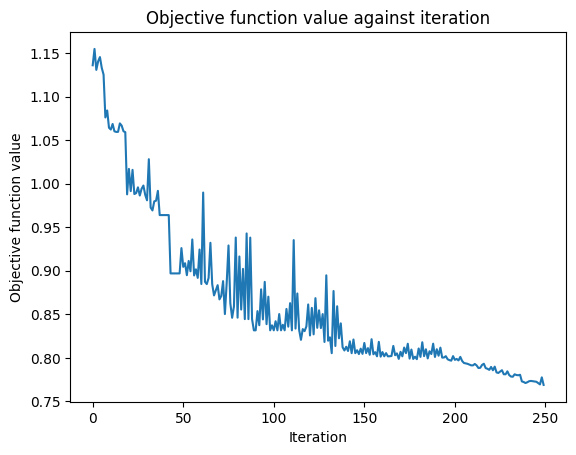

Precision:
 [0.6347222222222223, 0.677266081871345, 0.6777777777777778, 0.7369722663840311, 0.6347222222222223, 0.698005698005698, 0.7587502936340145, 0.7811965811965812, 0.698005698005698, 0.6566604127579738]
Accuracy:
 [0.6481481481481481, 0.6851851851851852, 0.6851851851851852, 0.7407407407407407, 0.6481481481481481, 0.7037037037037037, 0.7407407407407407, 0.7777777777777778, 0.7037037037037037, 0.6666666666666666]
Recall:
 [0.5995670995670996, 0.6471861471861472, 0.6385281385281385, 0.7099567099567099, 0.5995670995670996, 0.6623376623376623, 0.683982683982684, 0.7402597402597402, 0.6623376623376623, 0.6147186147186148]
F1:
 [0.6298325722983257, 0.6749989426045764, 0.6687975646879757, 0.7345029239766083, 0.6298325722983257, 0.6913580246913581, 0.7172880116959064, 0.7685185185185185, 0.6913580246913581, 0.6454689984101749]
Time:
 [354.73182249069214, 355.2867844104767, 355.7485680580139, 355.10554122924805, 356.01503562927246, 354.46732211112976, 355.7273278236389, 356.4905424118042,

In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 250
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.6347222222222223, 0.677266081871345, 0.6777777777777778, 0.7369722663840311, 0.6347222222222223, 0.698005698005698, 0.7587502936340145, 0.7811965811965812, 0.698005698005698, 0.6566604127579738]
Accuracy:
 [0.6481481481481481, 0.6851851851851852, 0.6851851851851852, 0.7407407407407407, 0.6481481481481481, 0.7037037037037037, 0.7407407407407407, 0.7777777777777778, 0.7037037037037037, 0.6666666666666666]
Recall:
 [0.5995670995670996, 0.6471861471861472, 0.6385281385281385, 0.7099567099567099, 0.5995670995670996, 0.6623376623376623, 0.683982683982684, 0.7402597402597402, 0.6623376623376623, 0.6147186147186148]
F1:
 [0.6298325722983257, 0.6749989426045764, 0.6687975646879757, 0.7345029239766083, 0.6298325722983257, 0.6913580246913581, 0.7172880116959064, 0.7685185185185185, 0.6913580246913581, 0.6454689984101749]
Time:
 [354.73182249069214, 355.2867844104767, 355.7485680580139, 355.10554122924805, 356.01503562927246, 354.46732211112976, 355.7273278236389, 356.4905424118042, 357.0643723011017, 355.97282814979553]
Mean Precision: 0.6954079254077564±0.04756034885431625
Mean Accuracy: 0.7000000000000001±0.04040263746161375
Mean Recall: 0.6558441558441558±0.04396657509139771
Mean F1: 0.6851956153873128±0.04308247291346197
Mean Time: 355.6610144615173±0.7502699176157265


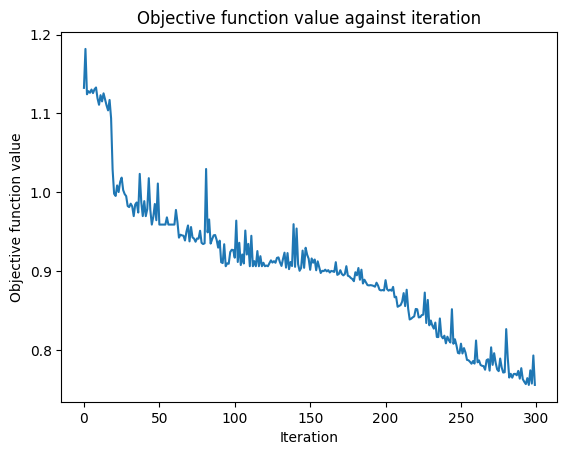

Precision:
 [0.7014800917239941, 0.6368786549707602, 0.698005698005698, 0.7638888888888888, 0.7281746031746031, 0.698005698005698, 0.7091848719755697, 0.6812169312169312, 0.6616541353383459, 0.7091848719755697]
Accuracy:
 [0.7037037037037037, 0.6481481481481481, 0.7037037037037037, 0.7592592592592593, 0.7222222222222222, 0.7037037037037037, 0.7037037037037037, 0.6851851851851852, 0.6666666666666666, 0.7037037037037037]
Recall:
 [0.6536796536796536, 0.6082251082251082, 0.6623376623376623, 0.7164502164502164, 0.6688311688311688, 0.6623376623376623, 0.645021645021645, 0.6298701298701299, 0.6406926406926408, 0.645021645021645]
F1:
 [0.6848613319201554, 0.6367635240874676, 0.6913580246913581, 0.7467275494672755, 0.7010101010101011, 0.6913580246913581, 0.6769005847953217, 0.6611447811447811, 0.6632352941176471, 0.6769005847953217]
Time:
 [625.6470460891724, 633.0017077922821, 678.0757851600647, 659.6897995471954, 611.4124703407288, 505.9125792980194, 505.08760046958923, 507.9477915763855, 50

In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7014800917239941, 0.6368786549707602, 0.698005698005698, 0.7638888888888888, 0.7281746031746031, 0.698005698005698, 0.7091848719755697, 0.6812169312169312, 0.6616541353383459, 0.7091848719755697]
Accuracy:
 [0.7037037037037037, 0.6481481481481481, 0.7037037037037037, 0.7592592592592593, 0.7222222222222222, 0.7037037037037037, 0.7037037037037037, 0.6851851851851852, 0.6666666666666666, 0.7037037037037037]
Recall:
 [0.6536796536796536, 0.6082251082251082, 0.6623376623376623, 0.7164502164502164, 0.6688311688311688, 0.6623376623376623, 0.645021645021645, 0.6298701298701299, 0.6406926406926408, 0.645021645021645]
F1:
 [0.6848613319201554, 0.6367635240874676, 0.6913580246913581, 0.7467275494672755, 0.7010101010101011, 0.6913580246913581, 0.6769005847953217, 0.6611447811447811, 0.6632352941176471, 0.6769005847953217]
Time:
 [625.6470460891724, 633.0017077922821, 678.0757851600647, 659.6897995471954, 611.4124703407288, 505.9125792980194, 505.08760046958923, 507.9477915763855, 504.25738501548767, 505.07967710494995]
Mean Precision: 0.6987674445276059±0.03293446305050861
Mean Accuracy: 0.7±0.02844868795506893
Mean Recall: 0.6532467532467533±0.026961739600034656
Mean F1: 0.6830259800720786±0.02758486339674363
Mean Time: 573.6111842393875±70.05930631448206


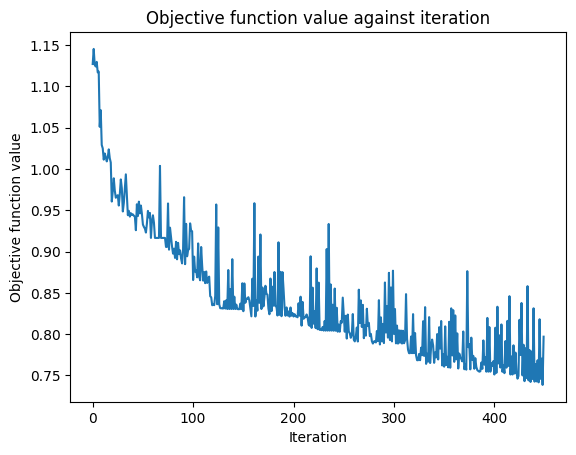

Precision:
 [0.65818759936407, 0.6777777777777778, 0.6564102564102564, 0.6564102564102564, 0.6566604127579738, 0.7014800917239941, 0.698005698005698, 0.7462997706900146, 0.6777777777777778, 0.698005698005698]
Accuracy:
 [0.6666666666666666, 0.6851851851851852, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7037037037037037, 0.7037037037037037, 0.7407407407407407, 0.6851851851851852, 0.7037037037037037]
Recall:
 [0.632034632034632, 0.6385281385281385, 0.6233766233766234, 0.6233766233766234, 0.6147186147186148, 0.6536796536796536, 0.6623376623376623, 0.6926406926406926, 0.6385281385281385, 0.6623376623376623]
F1:
 [0.6586466165413534, 0.6687975646879757, 0.6527777777777778, 0.6527777777777778, 0.6454689984101749, 0.6848613319201554, 0.6913580246913581, 0.724253665430136, 0.6687975646879757, 0.6913580246913581]
Time:
 [875.0146720409393, 876.7315905094147, 878.6103582382202, 879.9389095306396, 877.4902358055115, 876.9813792705536, 877.6390058994293, 876.101687669754, 875.15

In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 450
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=5, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.65818759936407, 0.6777777777777778, 0.6564102564102564, 0.6564102564102564, 0.6566604127579738, 0.7014800917239941, 0.698005698005698, 0.7462997706900146, 0.6777777777777778, 0.698005698005698]
Accuracy:
 [0.6666666666666666, 0.6851851851851852, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7037037037037037, 0.7037037037037037, 0.7407407407407407, 0.6851851851851852, 0.7037037037037037]
Recall:
 [0.632034632034632, 0.6385281385281385, 0.6233766233766234, 0.6233766233766234, 0.6147186147186148, 0.6536796536796536, 0.6623376623376623, 0.6926406926406926, 0.6385281385281385, 0.6623376623376623]
F1:
 [0.6586466165413534, 0.6687975646879757, 0.6527777777777778, 0.6527777777777778, 0.6454689984101749, 0.6848613319201554, 0.6913580246913581, 0.724253665430136, 0.6687975646879757, 0.6913580246913581]
Time:
 [875.0146720409393, 876.7315905094147, 878.6103582382202, 879.9389095306396, 877.4902358055115, 876.9813792705536, 877.6390058994293, 876.101687669754, 875.1591629981995, 877.9866037368774]
Mean Precision: 0.6827015338923517±0.02752422043264679
Mean Accuracy: 0.6888888888888889±0.023129622216290373
Mean Recall: 0.6441558441558441±0.022456644760766982
Mean F1: 0.6739097346616043±0.022914101592904485
Mean Time: 877.1653605699539±1.4418256386596906


# **EfficientSU2+Hadamard/TwoLocal**

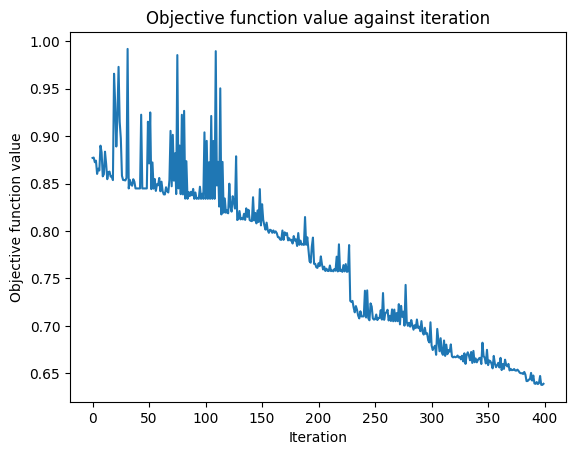

Precision:
 [0.8551492669139727, 0.8352272727272727, 0.8512949039264828, 0.8518518518518519, 0.8333333333333334, 0.8518518518518519, 0.8323529411764705, 0.8512949039264828, 0.8512949039264828, 0.7947530864197532]
Accuracy:
 [0.8518518518518519, 0.8333333333333334, 0.8518518518518519, 0.8518518518518519, 0.8333333333333334, 0.8518518518518519, 0.8333333333333334, 0.8518518518518519, 0.8518518518518519, 0.7962962962962963]
Recalls:
 [0.8268398268398269, 0.829004329004329, 0.8354978354978355, 0.8441558441558441, 0.8116883116883117, 0.8441558441558441, 0.8203463203463204, 0.8354978354978355, 0.8354978354978355, 0.7727272727272727]
F1:
 [0.8482873851294904, 0.833989266547406, 0.850326797385621, 0.8518518518518519, 0.830546265328874, 0.8518518518518519, 0.8325445941026575, 0.850326797385621, 0.850326797385621, 0.7928898798464017]
Time:
 [734.3738300800323, 751.7570722103119, 747.1320126056671, 744.8885188102722, 618.6137988567352, 674.1698894500732, 623.9634988307953, 653.4985389709473, 587.

In [6]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 400
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8551492669139727, 0.8352272727272727, 0.8512949039264828, 0.8518518518518519, 0.8333333333333334, 0.8518518518518519, 0.8323529411764705, 0.8512949039264828, 0.8512949039264828, 0.7947530864197532]
Accuracy:
 [0.8518518518518519, 0.8333333333333334, 0.8518518518518519, 0.8518518518518519, 0.8333333333333334, 0.8518518518518519, 0.8333333333333334, 0.8518518518518519, 0.8518518518518519, 0.7962962962962963]
Recalls:
 [0.8268398268398269, 0.829004329004329, 0.8354978354978355, 0.8441558441558441, 0.8116883116883117, 0.8441558441558441, 0.8203463203463204, 0.8354978354978355, 0.8354978354978355, 0.7727272727272727]
F1:
 [0.8482873851294904, 0.833989266547406, 0.850326797385621, 0.8518518518518519, 0.830546265328874, 0.8518518518518519, 0.8325445941026575, 0.850326797385621, 0.850326797385621, 0.7928898798464017]
Time:
 [734.3738300800323, 751.7570722103119, 747.1320126056671, 744.8885188102722, 618.6137988567352, 674.1698894500732, 623.9634988307953, 653.4985389709473, 587.8449292182922, 622.394348859787]
Mean Precision: 0.8408404316053956±0.017490221414299918
Mean Accuracy: 0.8407407407407408±0.016972502573910524
Mean Recall: 0.8255411255411256±0.020030710478371037
Mean F1: 0.8392941486815395±0.017507164312546602
Mean Time: 675.8636437892914±60.08940361368539


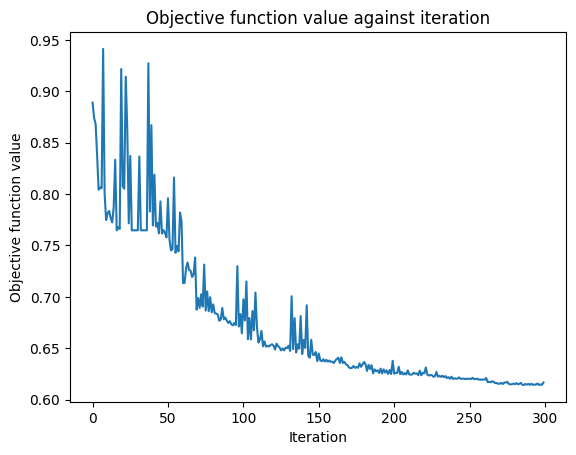

Precision:
 [0.8323529411764705, 0.8697712418300654, 0.8333333333333334, 0.8148148148148148, 0.8323529411764705, 0.8388157894736842, 0.8512949039264828, 0.8333333333333334, 0.7949346405228758, 0.8352272727272727]
Accuracy:
 [0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.8333333333333334, 0.8518518518518519, 0.8333333333333334, 0.7962962962962963, 0.8333333333333334]
Recalls:
 [0.8203463203463204, 0.8593073593073592, 0.8116883116883117, 0.8051948051948052, 0.8203463203463204, 0.803030303030303, 0.8354978354978355, 0.8116883116883117, 0.7813852813852814, 0.829004329004329]
F1:
 [0.8325445941026575, 0.8697569065242893, 0.830546265328874, 0.8148148148148148, 0.8325445941026575, 0.827940616673011, 0.850326797385621, 0.830546265328874, 0.7953322816810258, 0.833989266547406]
Time:
 [405.7902476787567, 458.6500930786133, 421.91177344322205, 410.430739402771, 517.5894250869751, 459.78313422203064, 432.055011510849, 463.89537715911865, 465.

In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8323529411764705, 0.8697712418300654, 0.8333333333333334, 0.8148148148148148, 0.8323529411764705, 0.8388157894736842, 0.8512949039264828, 0.8333333333333334, 0.7949346405228758, 0.8352272727272727]
Accuracy:
 [0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.8333333333333334, 0.8518518518518519, 0.8333333333333334, 0.7962962962962963, 0.8333333333333334]
Recalls:
 [0.8203463203463204, 0.8593073593073592, 0.8116883116883117, 0.8051948051948052, 0.8203463203463204, 0.803030303030303, 0.8354978354978355, 0.8116883116883117, 0.7813852813852814, 0.829004329004329]
F1:
 [0.8325445941026575, 0.8697569065242893, 0.830546265328874, 0.8148148148148148, 0.8325445941026575, 0.827940616673011, 0.850326797385621, 0.830546265328874, 0.7953322816810258, 0.833989266547406]
Time:
 [405.7902476787567, 458.6500930786133, 421.91177344322205, 410.430739402771, 517.5894250869751, 459.78313422203064, 432.055011510849, 463.89537715911865, 465.3708701133728, 460.7962574958801]
Mean Precision: 0.8336231212314804±0.01871486369312811
Mean Accuracy: 0.8333333333333334±0.01851851851851852
Mean Recall: 0.8177489177489179±0.019880454551004373
Mean F1: 0.831834240248923±0.018510236398190414
Mean Time: 449.62729291915895±31.487424634658666


# **EfficientSU2 / RealAmplitudes**

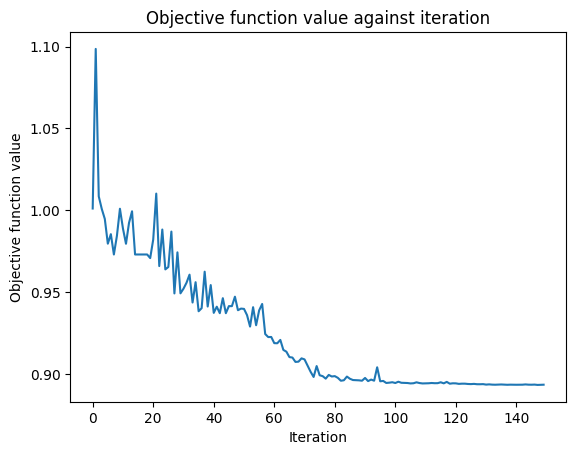

Precision:
 [0.703448275862069, 0.6677350427350427, 0.7413003663003663, 0.6277394636015325, 0.718007662835249, 0.6296296296296297, 0.7296296296296296, 0.7296296296296296, 0.7864583333333334, 0.6543209876543209]
Accuracy:
 [0.6666666666666666, 0.6481481481481481, 0.7222222222222222, 0.5925925925925926, 0.7037037037037037, 0.6296296296296297, 0.6851851851851852, 0.6851851851851852, 0.7222222222222222, 0.6296296296296297]
Recalls:
 [0.6839826839826839, 0.6515151515151515, 0.7294372294372294, 0.606060606060606, 0.7056277056277056, 0.6103896103896105, 0.7077922077922079, 0.7077922077922079, 0.7554112554112554, 0.6363636363636364]
F1:
 [0.6703448275862068, 0.6524435143200404, 0.7256133007789792, 0.597088122605364, 0.7070282063269441, 0.6296296296296297, 0.6881091617933724, 0.6881091617933724, 0.7232704402515724, 0.6342592592592593]
Time:
 [153.8697702884674, 159.74872279167175, 160.44302129745483, 162.45753002166748, 133.08883094787598, 124.19142651557922, 123.2868480682373, 124.453128576278

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 150
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.703448275862069, 0.6677350427350427, 0.7413003663003663, 0.6277394636015325, 0.718007662835249, 0.6296296296296297, 0.7296296296296296, 0.7296296296296296, 0.7864583333333334, 0.6543209876543209]
Accuracy:
 [0.6666666666666666, 0.6481481481481481, 0.7222222222222222, 0.5925925925925926, 0.7037037037037037, 0.6296296296296297, 0.6851851851851852, 0.6851851851851852, 0.7222222222222222, 0.6296296296296297]
Recalls:
 [0.6839826839826839, 0.6515151515151515, 0.7294372294372294, 0.606060606060606, 0.7056277056277056, 0.6103896103896105, 0.7077922077922079, 0.7077922077922079, 0.7554112554112554, 0.6363636363636364]
F1:
 [0.6703448275862068, 0.6524435143200404, 0.7256133007789792, 0.597088122605364, 0.7070282063269441, 0.6296296296296297, 0.6881091617933724, 0.6881091617933724, 0.7232704402515724, 0.6342592592592593]
Time:
 [153.8697702884674, 159.74872279167175, 160.44302129745483, 162.45753002166748, 133.08883094787598, 124.19142651557922, 123.2868480682373, 124.45312857627869, 124.41890859603882, 125.95512008666992]
Mean Precision: 0.6987899021210804±0.0495573309456705
Mean Accuracy: 0.6685185185185186±0.040950637754622196
Mean Recall: 0.6794372294372295±0.04834598621177284
Mean F1: 0.6715895624344741±0.04057578317118407
Mean Time: 139.19133071899415±16.60373411945861


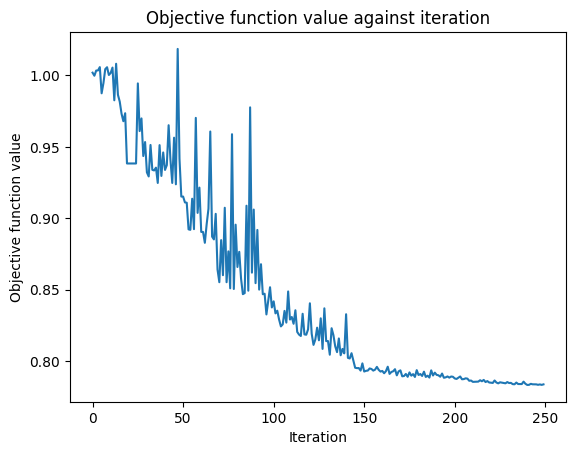

Precision:
 [0.718007662835249, 0.7791570881226053, 0.746454729624435, 0.6447509578544062, 0.7407407407407407, 0.724905303030303, 0.7319444444444445, 0.7045177045177046, 0.718007662835249, 0.6813793103448276]
Accuracy:
 [0.7037037037037037, 0.7407407407407407, 0.7407407407407407, 0.6296296296296297, 0.7407407407407407, 0.7222222222222222, 0.7222222222222222, 0.6851851851851852, 0.7037037037037037, 0.6666666666666666]
Recalls:
 [0.7056277056277056, 0.7619047619047619, 0.7359307359307359, 0.6277056277056277, 0.7272727272727273, 0.7121212121212122, 0.7207792207792207, 0.6904761904761905, 0.7056277056277056, 0.6666666666666666]
F1:
 [0.7070282063269441, 0.7436015325670497, 0.7425820707070706, 0.63378525790868, 0.7407407407407407, 0.7233154442456767, 0.7248677248677249, 0.6890284075495097, 0.7070282063269441, 0.6704067321178121]
Time:
 [298.0071008205414, 305.35667872428894, 303.1654839515686, 241.2371141910553, 247.94656229019165, 238.71862483024597, 233.07523727416992, 238.84347105026245,

In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 250
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)


  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.718007662835249, 0.7791570881226053, 0.746454729624435, 0.6447509578544062, 0.7407407407407407, 0.724905303030303, 0.7319444444444445, 0.7045177045177046, 0.718007662835249, 0.6813793103448276]
Accuracy:
 [0.7037037037037037, 0.7407407407407407, 0.7407407407407407, 0.6296296296296297, 0.7407407407407407, 0.7222222222222222, 0.7222222222222222, 0.6851851851851852, 0.7037037037037037, 0.6666666666666666]
Recalls:
 [0.7056277056277056, 0.7619047619047619, 0.7359307359307359, 0.6277056277056277, 0.7272727272727273, 0.7121212121212122, 0.7207792207792207, 0.6904761904761905, 0.7056277056277056, 0.6666666666666666]
F1:
 [0.7070282063269441, 0.7436015325670497, 0.7425820707070706, 0.63378525790868, 0.7407407407407407, 0.7233154442456767, 0.7248677248677249, 0.6890284075495097, 0.7070282063269441, 0.6704067321178121]
Time:
 [298.0071008205414, 305.35667872428894, 303.1654839515686, 241.2371141910553, 247.94656229019165, 238.71862483024597, 233.07523727416992, 238.84347105026245, 243.35768151283264, 237.78575134277344]
Mean Precision: 0.7189865604349965±0.034910842980278134
Mean Accuracy: 0.7055555555555556±0.03459544757827666
Mean Recall: 0.7054112554112554±0.035559154092555625
Mean F1: 0.7082384323358153±0.033670092269503175
Mean Time: 258.749370598793±28.709920985887344


# **Unordred**

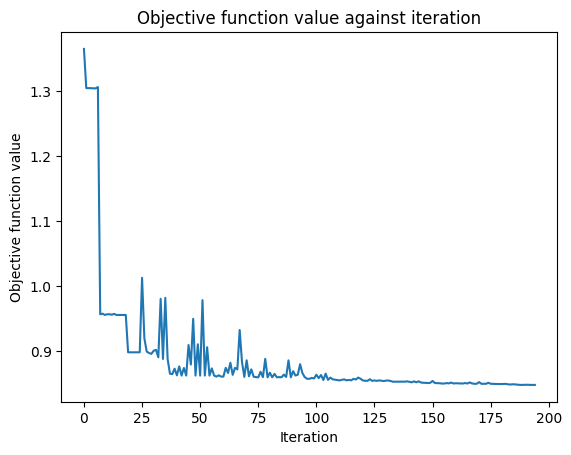

In [ ]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['h', 'ry',"rz"])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

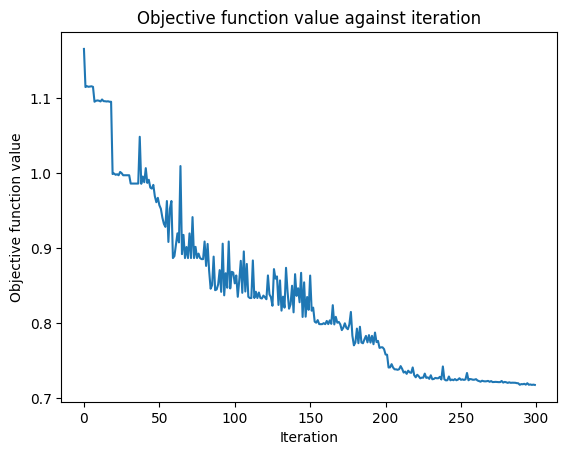

Precision:
 [0.7462997706900146]
Accuracy:
 [0.7407407407407407]
Recalls:
 [0.6926406926406926]
F1:
 [0.724253665430136]
Time:
 [469.1723976135254]
Mean Precision: 0.7462997706900146±0.0
Mean Accuracy: 0.7407407407407407±0.0
Mean Recall: 0.6926406926406926±0.0
Mean F1: 0.724253665430136±0.0
Mean Time: 469.1723976135254±0.0


In [8]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['ry',"rz", 'h'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

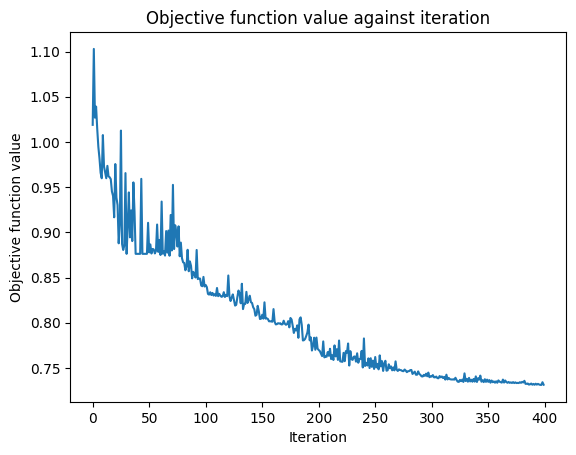

Precision:
 [0.6975799328740506]
Accuracy:
 [0.7037037037037037]
Recalls:
 [0.670995670995671]
F1:
 [0.6965747702589808]
Time:
 [637.849814414978]
Mean Precision: 0.6975799328740506±0.0
Mean Accuracy: 0.7037037037037037±0.0
Mean Recall: 0.670995670995671±0.0
Mean F1: 0.6965747702589808±0.0
Mean Time: 637.849814414978±0.0


In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 400
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, parameter_prefix="x", reps=0, su2_gates=['ry',"rz", 'h'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'], entanglement_blocks='cz')



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

# **EfficientSU2/PauliTwoDesign**

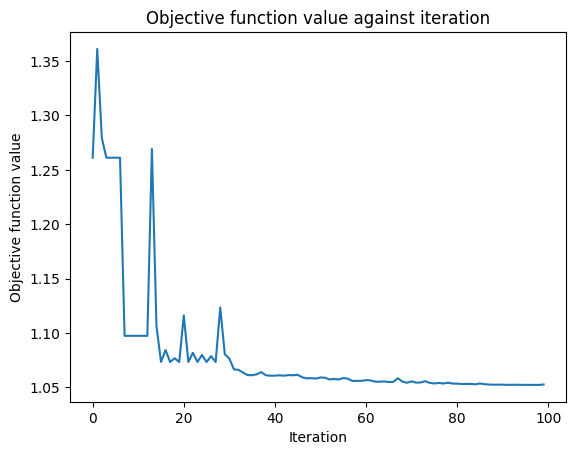

Precision:
 [0.5055555555555555, 0.5632716049382716, 0.5964912280701755, 0.4674873737373737, 0.6953703703703703, 0.4612259318141671, 0.6513573232323232, 0.45348293595137906, 0.5704248366013073, 0.4674873737373737]
Accuracy:
 [0.5370370370370371, 0.5740740740740741, 0.6111111111111112, 0.46296296296296297, 0.6851851851851852, 0.48148148148148145, 0.6481481481481481, 0.4444444444444444, 0.5740740740740741, 0.46296296296296297]
Recalls:
 [0.4826839826839827, 0.538961038961039, 0.5692640692640693, 0.43939393939393934, 0.6818181818181819, 0.4372294372294372, 0.6341991341991342, 0.4242424242424242, 0.5476190476190476, 0.43939393939393934]
F1:
 [0.512937595129376, 0.5669515669515669, 0.598528105570359, 0.4650765255416418, 0.6881834215167549, 0.4690058479532165, 0.649532896044524, 0.44839015151515155, 0.5720584071512357, 0.4650765255416418]
Time:
 [83.4613184928894, 87.8298020362854, 90.86204671859741, 88.79345512390137, 86.76371502876282, 87.1989676952362, 87.21378231048584, 88.41846418380737

In [22]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=1)
  

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.5055555555555555, 0.5632716049382716, 0.5964912280701755, 0.4674873737373737, 0.6953703703703703, 0.4612259318141671, 0.6513573232323232, 0.45348293595137906, 0.5704248366013073, 0.4674873737373737]
Accuracy:
 [0.5370370370370371, 0.5740740740740741, 0.6111111111111112, 0.46296296296296297, 0.6851851851851852, 0.48148148148148145, 0.6481481481481481, 0.4444444444444444, 0.5740740740740741, 0.46296296296296297]
Recalls:
 [0.4826839826839827, 0.538961038961039, 0.5692640692640693, 0.43939393939393934, 0.6818181818181819, 0.4372294372294372, 0.6341991341991342, 0.4242424242424242, 0.5476190476190476, 0.43939393939393934]
F1:
 [0.512937595129376, 0.5669515669515669, 0.598528105570359, 0.4650765255416418, 0.6881834215167549, 0.4690058479532165, 0.649532896044524, 0.44839015151515155, 0.5720584071512357, 0.4650765255416418]
Time:
 [83.4613184928894, 87.8298020362854, 90.86204671859741, 88.79345512390137, 86.76371502876282, 87.1989676952362, 87.21378231048584, 88.41846418380737, 90.06684589385986, 88.20451045036316]
Mean Precision: 0.5432154534008297±0.08154057212608543
Mean Accuracy: 0.5481481481481482±0.07995197461082558
Mean Recall: 0.5194805194805194±0.08554576989337451
Mean F1: 0.5435741042915468±0.08024940426992797
Mean Time: 87.88129079341888±1.912734721563303


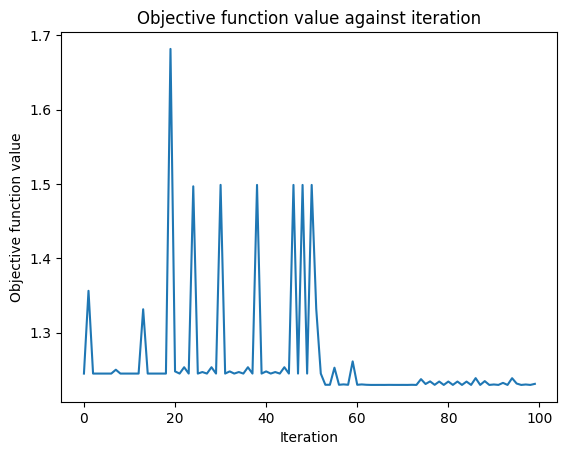

Precision:
 [0.6361111111111112, 0.5157163742690059, 0.6361111111111112, 0.4393518518518519, 0.6296296296296297, 0.6122931442080378, 0.5662393162393162, 0.5732193732193733, 0.5316239316239317, 0.4861111111111111]
Accuracy:
 [0.6481481481481481, 0.5370370370370371, 0.6481481481481481, 0.42592592592592593, 0.6296296296296297, 0.6296296296296297, 0.5370370370370371, 0.5925925925925926, 0.5555555555555556, 0.5]
Recalls:
 [0.5822510822510822, 0.49134199134199136, 0.5822510822510822, 0.40909090909090906, 0.6103896103896105, 0.5497835497835497, 0.5432900432900433, 0.5454545454545454, 0.5064935064935066, 0.461038961038961]
F1:
 [0.6108550947260624, 0.5220572685361416, 0.6108550947260624, 0.4313932980599648, 0.6296296296296297, 0.5694444444444444, 0.5426419155232715, 0.5756172839506172, 0.5370370370370371, 0.4916387959866221]
Time:
 [99.55639171600342, 102.427077293396, 104.25052285194397, 102.19868016242981, 103.62880086898804, 103.77972364425659, 105.11491179466248, 103.28257131576538, 102.57

In [23]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=2)
  

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.6361111111111112, 0.5157163742690059, 0.6361111111111112, 0.4393518518518519, 0.6296296296296297, 0.6122931442080378, 0.5662393162393162, 0.5732193732193733, 0.5316239316239317, 0.4861111111111111]
Accuracy:
 [0.6481481481481481, 0.5370370370370371, 0.6481481481481481, 0.42592592592592593, 0.6296296296296297, 0.6296296296296297, 0.5370370370370371, 0.5925925925925926, 0.5555555555555556, 0.5]
Recalls:
 [0.5822510822510822, 0.49134199134199136, 0.5822510822510822, 0.40909090909090906, 0.6103896103896105, 0.5497835497835497, 0.5432900432900433, 0.5454545454545454, 0.5064935064935066, 0.461038961038961]
F1:
 [0.6108550947260624, 0.5220572685361416, 0.6108550947260624, 0.4313932980599648, 0.6296296296296297, 0.5694444444444444, 0.5426419155232715, 0.5756172839506172, 0.5370370370370371, 0.4916387959866221]
Time:
 [99.55639171600342, 102.427077293396, 104.25052285194397, 102.19868016242981, 103.62880086898804, 103.77972364425659, 105.11491179466248, 103.28257131576538, 102.57340455055237, 103.7248797416687]
Mean Precision: 0.5626406954374479±0.06488019205531816
Mean Accuracy: 0.5703703703703704±0.06919089515655334
Mean Recall: 0.528138528138528±0.05840948294054643
Mean F1: 0.5521169862619854±0.057631271292765976
Mean Time: 103.05369639396667±1.4362192924041761


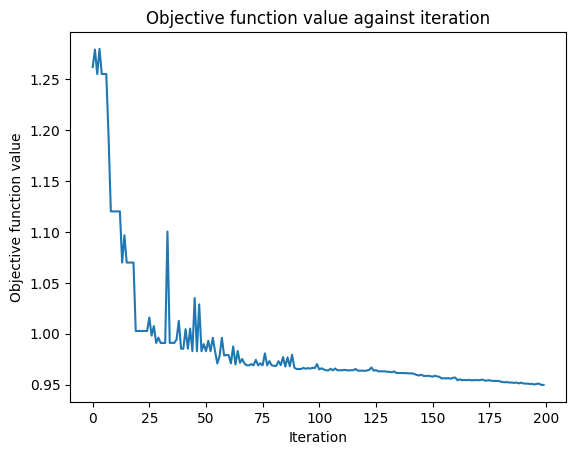

Precision:
 [0.6616541353383459, 0.5964912280701755, 0.48148148148148145, 0.5733333333333334, 0.5964912280701755, 0.6018518518518519, 0.5055555555555555, 0.7037037037037037, 0.6452614379084968, 0.6365903069970392]
Accuracy:
 [0.6666666666666666, 0.6111111111111112, 0.48148148148148145, 0.6111111111111112, 0.6111111111111112, 0.6111111111111112, 0.5370370370370371, 0.7037037037037037, 0.6481481481481481, 0.6296296296296297]
Recalls:
 [0.6406926406926408, 0.5692640692640693, 0.4545454545454546, 0.5173160173160174, 0.5692640692640693, 0.577922077922078, 0.4826839826839827, 0.6883116883116883, 0.6255411255411256, 0.6190476190476191]
F1:
 [0.6632352941176471, 0.598528105570359, 0.48148148148148145, 0.5187148594377509, 0.598528105570359, 0.6046079524340393, 0.512937595129376, 0.7037037037037037, 0.646483031994499, 0.632260101010101]
Time:
 [237.19383811950684, 234.65483236312866, 237.03363466262817, 237.92607069015503, 238.13495683670044, 186.13452124595642, 173.21515464782715, 185.288128376

In [24]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 200
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)
  

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.6616541353383459, 0.5964912280701755, 0.48148148148148145, 0.5733333333333334, 0.5964912280701755, 0.6018518518518519, 0.5055555555555555, 0.7037037037037037, 0.6452614379084968, 0.6365903069970392]
Accuracy:
 [0.6666666666666666, 0.6111111111111112, 0.48148148148148145, 0.6111111111111112, 0.6111111111111112, 0.6111111111111112, 0.5370370370370371, 0.7037037037037037, 0.6481481481481481, 0.6296296296296297]
Recalls:
 [0.6406926406926408, 0.5692640692640693, 0.4545454545454546, 0.5173160173160174, 0.5692640692640693, 0.577922077922078, 0.4826839826839827, 0.6883116883116883, 0.6255411255411256, 0.6190476190476191]
F1:
 [0.6632352941176471, 0.598528105570359, 0.48148148148148145, 0.5187148594377509, 0.598528105570359, 0.6046079524340393, 0.512937595129376, 0.7037037037037037, 0.646483031994499, 0.632260101010101]
Time:
 [237.19383811950684, 234.65483236312866, 237.03363466262817, 237.92607069015503, 238.13495683670044, 186.13452124595642, 173.21515464782715, 185.28812837600708, 183.88583993911743, 185.45849657058716]
Mean Precision: 0.6002414262310158±0.06453534827764103
Mean Accuracy: 0.6111111111111112±0.05972042776517444
Mean Recall: 0.5744588744588744±0.06933978545515472
Mean F1: 0.5960480230449317±0.06786582908063851
Mean Time: 209.89254734516143±27.326005969452517


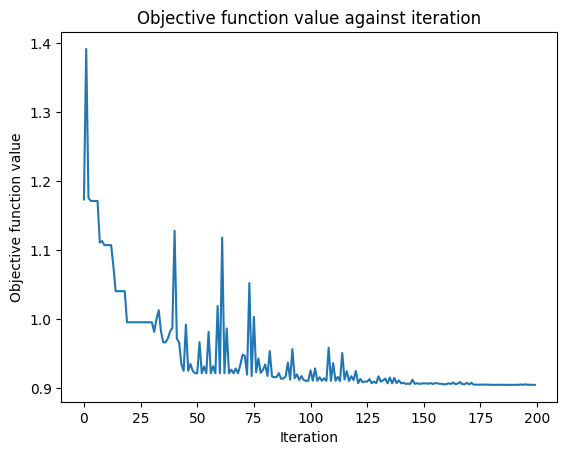

Precision:
 [0.6018518518518519, 0.6808510638297873, 0.6118407337919534, 0.6566604127579738, 0.5042613636363636, 0.5006182653241477, 0.6566604127579738, 0.5632716049382716, 0.607843137254902, 0.5530864197530865]
Accuracy:
 [0.6111111111111112, 0.6666666666666666, 0.6296296296296297, 0.6666666666666666, 0.5, 0.5185185185185185, 0.6666666666666666, 0.5740740740740741, 0.6111111111111112, 0.5925925925925926]
Recalls:
 [0.577922077922078, 0.5887445887445888, 0.5757575757575758, 0.6147186147186148, 0.47835497835497837, 0.47619047619047616, 0.6147186147186148, 0.538961038961039, 0.5865800865800865, 0.5194805194805194]
F1:
 [0.6046079524340393, 0.6125, 0.6060766649001942, 0.6454689984101749, 0.5019677996422183, 0.5069340016708438, 0.6454689984101749, 0.5669515669515669, 0.6092707195728674, 0.5424501424501423]
Time:
 [208.53149843215942, 208.55391454696655, 208.99705839157104, 208.2648491859436, 207.2339186668396, 208.98532795906067, 209.1712257862091, 208.5041515827179, 208.79390025138855, 20

In [25]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 200
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)
  

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.6018518518518519, 0.6808510638297873, 0.6118407337919534, 0.6566604127579738, 0.5042613636363636, 0.5006182653241477, 0.6566604127579738, 0.5632716049382716, 0.607843137254902, 0.5530864197530865]
Accuracy:
 [0.6111111111111112, 0.6666666666666666, 0.6296296296296297, 0.6666666666666666, 0.5, 0.5185185185185185, 0.6666666666666666, 0.5740740740740741, 0.6111111111111112, 0.5925925925925926]
Recalls:
 [0.577922077922078, 0.5887445887445888, 0.5757575757575758, 0.6147186147186148, 0.47835497835497837, 0.47619047619047616, 0.6147186147186148, 0.538961038961039, 0.5865800865800865, 0.5194805194805194]
F1:
 [0.6046079524340393, 0.6125, 0.6060766649001942, 0.6454689984101749, 0.5019677996422183, 0.5069340016708438, 0.6454689984101749, 0.5669515669515669, 0.6092707195728674, 0.5424501424501423]
Time:
 [208.53149843215942, 208.55391454696655, 208.99705839157104, 208.2648491859436, 207.2339186668396, 208.98532795906067, 209.1712257862091, 208.5041515827179, 208.79390025138855, 208.4679114818573]
Mean Precision: 0.5936945265896311±0.05946236721682381
Mean Accuracy: 0.6037037037037037±0.05629142279100246
Mean Recall: 0.5571428571428572±0.048768111937669965
Mean F1: 0.5841696844442221±0.049603430761584195
Mean Time: 208.5503756284714±0.5154957160485416


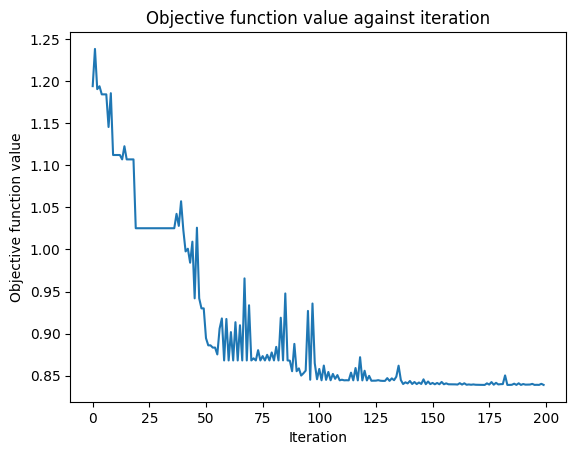

Precision:
 [0.6098765432098766, 0.6812169312169312, 0.7561728395061729, 0.6808510638297873, 0.65818759936407, 0.6826797385620915, 0.5055555555555555, 0.6566604127579738, 0.5856481481481481, 0.6596194503171247]
Accuracy:
 [0.6296296296296297, 0.6851851851851852, 0.7592592592592593, 0.6666666666666666, 0.6666666666666666, 0.6851851851851852, 0.5370370370370371, 0.6666666666666666, 0.5740740740740741, 0.6666666666666666]
Recalls:
 [0.5584415584415584, 0.6298701298701299, 0.7337662337662338, 0.5887445887445888, 0.632034632034632, 0.6645021645021645, 0.4826839826839827, 0.6147186147186148, 0.564935064935065, 0.6060606060606061]
F1:
 [0.584045584045584, 0.6611447811447811, 0.7552334943639291, 0.6125, 0.6586466165413534, 0.6836953444161308, 0.512937595129376, 0.6454689984101749, 0.5781305114638448, 0.6365131578947368]
Time:
 [297.6733076572418, 268.9313883781433, 246.57200050354004, 233.4037709236145, 237.96624970436096, 242.97296619415283, 243.03130555152893, 249.68622612953186, 256.7371754

In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 200
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=5)
  

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

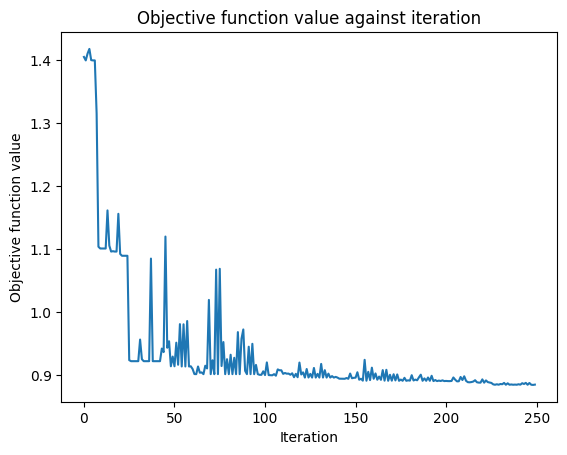

Precision:
 [0.6564102564102564, 0.6564102564102564, 0.65818759936407, 0.7208333333333333, 0.6596194503171247, 0.6596194503171247, 0.7416666666666666, 0.6596194503171247, 0.6790123456790123, 0.6596194503171247]
Accuracy:
 [0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7222222222222222, 0.6666666666666666, 0.6666666666666666, 0.7222222222222222, 0.6666666666666666, 0.6851851851851852, 0.6666666666666666]
Recalls:
 [0.6233766233766234, 0.6233766233766234, 0.632034632034632, 0.6774891774891775, 0.6060606060606061, 0.6060606060606061, 0.6601731601731602, 0.6060606060606061, 0.6558441558441559, 0.6060606060606061]
F1:
 [0.6527777777777778, 0.6527777777777778, 0.6586466165413534, 0.7077625570776255, 0.6365131578947368, 0.6365131578947368, 0.6927803379416283, 0.6365131578947368, 0.6799207233989842, 0.6365131578947368]
Time:
 [410.97338938713074, 339.0539312362671, 415.47178888320923, 420.1820442676544, 348.54528164863586, 350.3641138076782, 326.1324818134308, 325.5559089183807

In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 250
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=6)
  

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

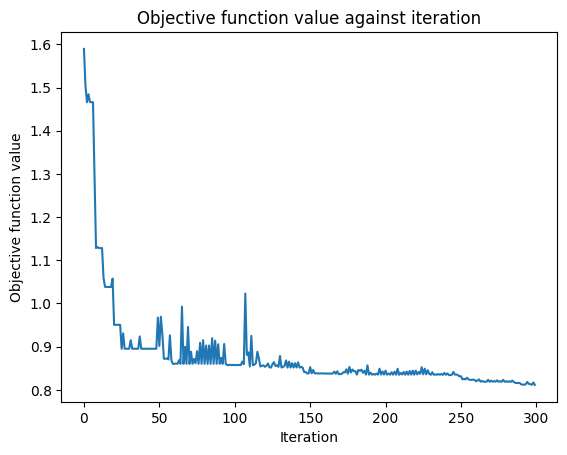

Precision:
 [0.6596194503171247, 0.6566604127579738, 0.6777777777777778, 0.7587502936340145, 0.6368786549707602, 0.6812169312169312, 0.698005698005698, 0.5857978279030911, 0.6199546485260771, 0.7587502936340145]
Accuracy:
 [0.6666666666666666, 0.6666666666666666, 0.6851851851851852, 0.7407407407407407, 0.6481481481481481, 0.6851851851851852, 0.7037037037037037, 0.5925925925925926, 0.6296296296296297, 0.7407407407407407]
Recalls:
 [0.6060606060606061, 0.6147186147186148, 0.6385281385281385, 0.683982683982684, 0.6082251082251082, 0.6298701298701299, 0.6623376623376623, 0.5627705627705628, 0.5411255411255411, 0.683982683982684]
F1:
 [0.6365131578947368, 0.6454689984101749, 0.6687975646879757, 0.7172880116959064, 0.6367635240874676, 0.6611447811447811, 0.6913580246913581, 0.5883986928104575, 0.5518032103397957, 0.7172880116959064]
Time:
 [463.76682472229004, 440.85800409317017, 424.42459321022034, 426.6275360584259, 424.0276756286621, 423.92484855651855, 504.67513728141785, 555.42485237121

In [12]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=7)
  

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

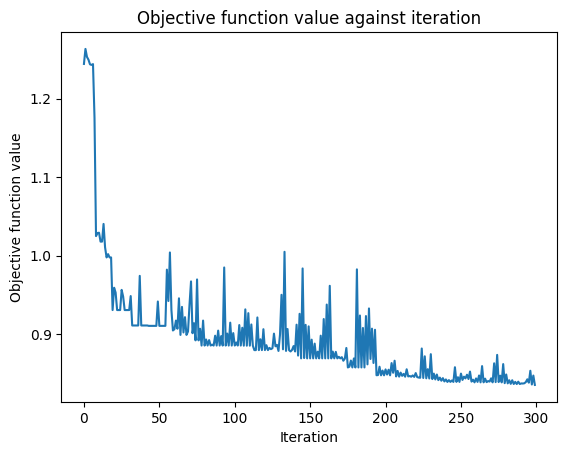

Precision:
 [0.6596194503171247, 0.7369722663840311, 0.6777777777777778, 0.6187952658540894, 0.6616541353383459, 0.677266081871345, 0.7176535087719297, 0.6342592592592593, 0.6347222222222223, 0.7416666666666666]
Accuracy:
 [0.6666666666666666, 0.7407407407407407, 0.6851851851851852, 0.6296296296296297, 0.6666666666666666, 0.6851851851851852, 0.7222222222222222, 0.6481481481481481, 0.6481481481481481, 0.7222222222222222]
Recalls:
 [0.6060606060606061, 0.7099567099567099, 0.6385281385281385, 0.5930735930735931, 0.6406926406926408, 0.6471861471861472, 0.6861471861471862, 0.5909090909090909, 0.5995670995670996, 0.6601731601731602]
F1:
 [0.6365131578947368, 0.7345029239766083, 0.6687975646879757, 0.6207184628237259, 0.6632352941176471, 0.6749989426045764, 0.7132343611216851, 0.6212794612794612, 0.6298325722983257, 0.6927803379416283]
Time:
 [545.8366267681122, 478.52238035202026, 585.4808421134949, 467.7685606479645, 534.4883065223694, 458.5422396659851, 507.5823483467102, 561.2651464939117

In [13]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=8)
  

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [21]:
featuremap = PauliFeatureMap(feature_dimension=3, reps=1)
qc = QuantumCircuit(3)
qc.compose(featuremap, inplace=True)
print(qc.decompose().draw(output='latex', scale=2))


/home/gzuz/.local/lib/python3.8/site-packages/qiskit/visualization/circuit/latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


<PIL.Image.Image image mode=RGB size=2928x218 at 0x7FB4CA61F8B0>


# **EfficientSU2+Hadamard/PauliTwoDesign**

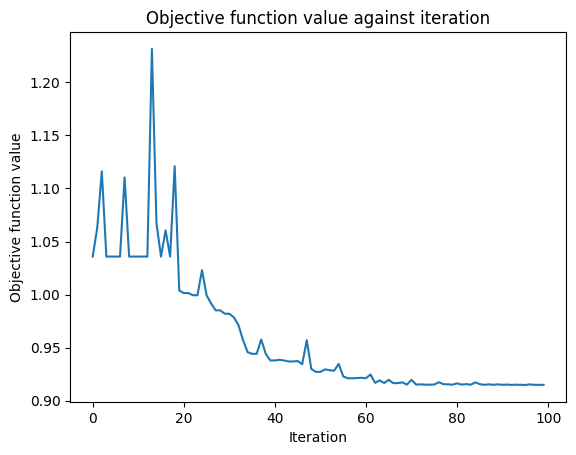

Precision:
 [0.7546360153256705, 0.7546360153256705, 0.7407407407407407, 0.7546360153256705, 0.7375104427736007, 0.7754385964912281, 0.6784188034188035, 0.7685185185185185, 0.7375104427736007, 0.728395061728395]
Accuracy:
 [0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7777777777777778, 0.6481481481481481, 0.7592592592592593, 0.7407407407407407, 0.7037037037037037]
Recalls:
 [0.7445887445887446, 0.7445887445887446, 0.7272727272727273, 0.7445887445887446, 0.7186147186147187, 0.7575757575757576, 0.6601731601731602, 0.7597402597402597, 0.7186147186147187, 0.7142857142857142]
F1:
 [0.743649680536076, 0.743649680536076, 0.7407407407407407, 0.743649680536076, 0.7380718954248366, 0.7754901960784314, 0.6524078557976862, 0.7615520282186949, 0.7380718954248366, 0.7074074074074075]
Time:
 [86.67933082580566, 92.82267308235168, 93.80554103851318, 93.7422239780426, 91.73724317550659, 92.31490588188171, 96.37109875679016, 96.76660680770874, 94.

In [19]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=1)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7546360153256705, 0.7546360153256705, 0.7407407407407407, 0.7546360153256705, 0.7375104427736007, 0.7754385964912281, 0.6784188034188035, 0.7685185185185185, 0.7375104427736007, 0.728395061728395]
Accuracy:
 [0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7777777777777778, 0.6481481481481481, 0.7592592592592593, 0.7407407407407407, 0.7037037037037037]
Recalls:
 [0.7445887445887446, 0.7445887445887446, 0.7272727272727273, 0.7445887445887446, 0.7186147186147187, 0.7575757575757576, 0.6601731601731602, 0.7597402597402597, 0.7186147186147187, 0.7142857142857142]
F1:
 [0.743649680536076, 0.743649680536076, 0.7407407407407407, 0.743649680536076, 0.7380718954248366, 0.7754901960784314, 0.6524078557976862, 0.7615520282186949, 0.7380718954248366, 0.7074074074074075]
Time:
 [86.67933082580566, 92.82267308235168, 93.80554103851318, 93.7422239780426, 91.73724317550659, 92.31490588188171, 96.37109875679016, 96.76660680770874, 94.83374404907227, 93.23778343200684]
Mean Precision: 0.7430440652421898±0.02561061962054732
Mean Accuracy: 0.7333333333333334±0.03333333333333333
Mean Recall: 0.729004329004329±0.027681943339823652
Mean F1: 0.7344691060700862±0.03193859930342558
Mean Time: 93.23111510276794±2.677361670652826


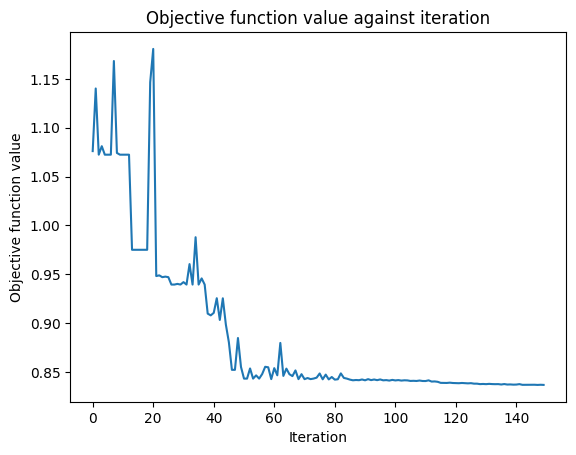

Precision:
 [0.7175925925925926, 0.725326797385621, 0.7407407407407407, 0.7098332554153031, 0.7037037037037037, 0.6132756132756133, 0.7546360153256705, 0.746454729624435, 0.746454729624435, 0.7777777777777778]
Accuracy:
 [0.7222222222222222, 0.6481481481481481, 0.7407407407407407, 0.7037037037037037, 0.7037037037037037, 0.5555555555555556, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7777777777777778]
Recalls:
 [0.6948051948051948, 0.6861471861471862, 0.7272727272727273, 0.696969696969697, 0.6883116883116883, 0.5844155844155844, 0.7445887445887446, 0.7359307359307359, 0.7359307359307359, 0.7662337662337663]
F1:
 [0.7175771088814565, 0.6465789975223937, 0.7407407407407407, 0.7058080808080809, 0.7037037037037037, 0.5555555555555556, 0.743649680536076, 0.7425820707070706, 0.7425820707070706, 0.7777777777777778]
Time:
 [162.1040735244751, 161.09452986717224, 167.0175426006317, 163.10770440101624, 165.8306839466095, 166.25134658813477, 164.59029078483582, 167.19436049461365

In [18]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 150
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=2)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7175925925925926, 0.725326797385621, 0.7407407407407407, 0.7098332554153031, 0.7037037037037037, 0.6132756132756133, 0.7546360153256705, 0.746454729624435, 0.746454729624435, 0.7777777777777778]
Accuracy:
 [0.7222222222222222, 0.6481481481481481, 0.7407407407407407, 0.7037037037037037, 0.7037037037037037, 0.5555555555555556, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7777777777777778]
Recalls:
 [0.6948051948051948, 0.6861471861471862, 0.7272727272727273, 0.696969696969697, 0.6883116883116883, 0.5844155844155844, 0.7445887445887446, 0.7359307359307359, 0.7359307359307359, 0.7662337662337663]
F1:
 [0.7175771088814565, 0.6465789975223937, 0.7407407407407407, 0.7058080808080809, 0.7037037037037037, 0.5555555555555556, 0.743649680536076, 0.7425820707070706, 0.7425820707070706, 0.7777777777777778]
Time:
 [162.1040735244751, 161.09452986717224, 167.0175426006317, 163.10770440101624, 165.8306839466095, 166.25134658813477, 164.59029078483582, 167.19436049461365, 163.67058515548706, 160.76856780052185]
Mean Precision: 0.7235795955465893±0.042465127994887254
Mean Accuracy: 0.7074074074074074±0.06017806225656266
Mean Recall: 0.7060606060606059±0.048018786576145625
Mean F1: 0.7076555786939926±0.060604685412982
Mean Time: 164.1629685163498±2.262641749257509


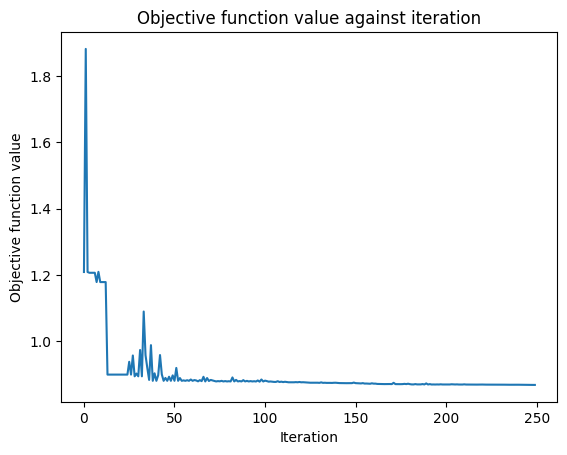

Precision:
 [0.757516339869281, 0.7685185185185185, 0.7949346405228758, 0.724905303030303, 0.7369722663840311, 0.7098332554153031, 0.8050925925925926, 0.6677350427350427, 0.7580409356725147, 0.7319444444444445]
Accuracy:
 [0.7592592592592593, 0.7592592592592593, 0.7962962962962963, 0.7222222222222222, 0.7407407407407407, 0.7037037037037037, 0.7962962962962963, 0.6481481481481481, 0.7592592592592593, 0.7222222222222222]
Recalls:
 [0.7424242424242424, 0.7597402597402597, 0.7813852813852814, 0.7121212121212122, 0.7099567099567099, 0.696969696969697, 0.7987012987012987, 0.6515151515151515, 0.725108225108225, 0.7207792207792207]
F1:
 [0.7581199692593941, 0.7615520282186949, 0.7953322816810258, 0.7233154442456767, 0.7345029239766083, 0.7058080808080809, 0.798236331569665, 0.6524435143200404, 0.7514697796387937, 0.7248677248677249]
Time:
 [296.53442645072937, 300.7397782802582, 304.73798179626465, 310.61937165260315, 289.2715177536011, 244.58914875984192, 242.23357915878296, 242.7359473705291

In [20]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 250
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.757516339869281, 0.7685185185185185, 0.7949346405228758, 0.724905303030303, 0.7369722663840311, 0.7098332554153031, 0.8050925925925926, 0.6677350427350427, 0.7580409356725147, 0.7319444444444445]
Accuracy:
 [0.7592592592592593, 0.7592592592592593, 0.7962962962962963, 0.7222222222222222, 0.7407407407407407, 0.7037037037037037, 0.7962962962962963, 0.6481481481481481, 0.7592592592592593, 0.7222222222222222]
Recalls:
 [0.7424242424242424, 0.7597402597402597, 0.7813852813852814, 0.7121212121212122, 0.7099567099567099, 0.696969696969697, 0.7987012987012987, 0.6515151515151515, 0.725108225108225, 0.7207792207792207]
F1:
 [0.7581199692593941, 0.7615520282186949, 0.7953322816810258, 0.7233154442456767, 0.7345029239766083, 0.7058080808080809, 0.798236331569665, 0.6524435143200404, 0.7514697796387937, 0.7248677248677249]
Time:
 [296.53442645072937, 300.7397782802582, 304.73798179626465, 310.61937165260315, 289.2715177536011, 244.58914875984192, 242.23357915878296, 242.73594737052917, 240.43947052955627, 243.13535165786743]
Mean Precision: 0.7455493339184907±0.03850542590515019
Mean Accuracy: 0.7407407407407407±0.04222871944811622
Mean Recall: 0.7298701298701299±0.040595813695238715
Mean F1: 0.7405648078585705±0.04092325036170665
Mean Time: 271.5036573410034±29.342802042472574


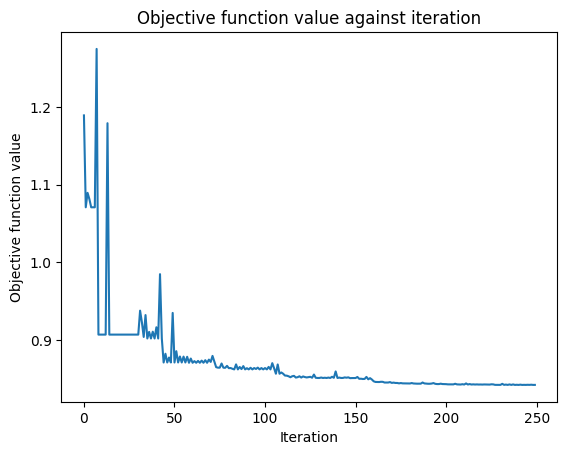

Precision:
 [0.728395061728395, 0.7200980392156863, 0.7947530864197532, 0.7905982905982906, 0.7561728395061729, 0.8157569334039922, 0.7319444444444445, 0.7754385964912281, 0.5925925925925926, 0.7375104427736007]
Accuracy:
 [0.7037037037037037, 0.7222222222222222, 0.7962962962962963, 0.7592592592592593, 0.7592592592592593, 0.8148148148148148, 0.7222222222222222, 0.7777777777777778, 0.5925925925925926, 0.7407407407407407]
Recalls:
 [0.7142857142857142, 0.7034632034632035, 0.7727272727272727, 0.777056277056277, 0.7337662337662338, 0.7878787878787878, 0.7207792207792207, 0.7575757575757576, 0.5714285714285714, 0.7186147186147187]
F1:
 [0.7074074074074075, 0.7209076568377624, 0.7928898798464017, 0.7621737960721012, 0.7552334943639291, 0.810359231411863, 0.7248677248677249, 0.7754901960784314, 0.5925925925925926, 0.7380718954248366]
Time:
 [270.1755096912384, 269.51796293258667, 273.2524039745331, 270.460844039917, 270.9298150539398, 270.92044138908386, 273.276789188385, 311.24955224990845, 

In [21]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 250
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.728395061728395, 0.7200980392156863, 0.7947530864197532, 0.7905982905982906, 0.7561728395061729, 0.8157569334039922, 0.7319444444444445, 0.7754385964912281, 0.5925925925925926, 0.7375104427736007]
Accuracy:
 [0.7037037037037037, 0.7222222222222222, 0.7962962962962963, 0.7592592592592593, 0.7592592592592593, 0.8148148148148148, 0.7222222222222222, 0.7777777777777778, 0.5925925925925926, 0.7407407407407407]
Recalls:
 [0.7142857142857142, 0.7034632034632035, 0.7727272727272727, 0.777056277056277, 0.7337662337662338, 0.7878787878787878, 0.7207792207792207, 0.7575757575757576, 0.5714285714285714, 0.7186147186147187]
F1:
 [0.7074074074074075, 0.7209076568377624, 0.7928898798464017, 0.7621737960721012, 0.7552334943639291, 0.810359231411863, 0.7248677248677249, 0.7754901960784314, 0.5925925925925926, 0.7380718954248366]
Time:
 [270.1755096912384, 269.51796293258667, 273.2524039745331, 270.460844039917, 270.9298150539398, 270.92044138908386, 273.276789188385, 311.24955224990845, 346.6908612251282, 311.1279790401459]
Mean Precision: 0.7443260327174155±0.05912554944809192
Mean Accuracy: 0.7388888888888888±0.05882363027506886
Mean Recall: 0.7257575757575757±0.05856208511174014
Mean F1: 0.737999387490305±0.057514753487431645
Mean Time: 286.76021587848663±25.47347412753288


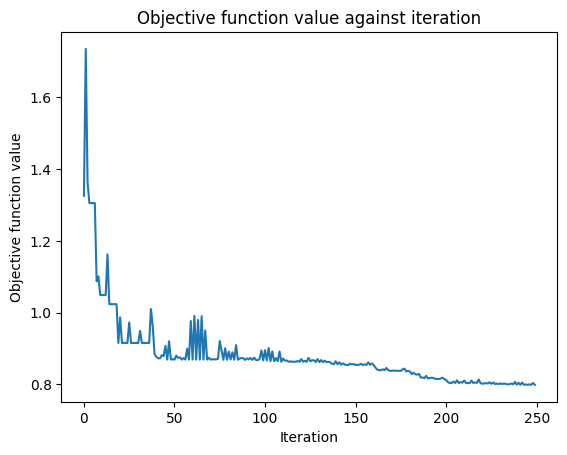

Precision:
 [0.8196976780426991, 0.81486568986569, 0.724905303030303, 0.7407407407407407, 0.718007662835249, 0.7561728395061729, 0.7561728395061729, 0.7830762038335671, 0.7176535087719297, 0.7984283625730995]
Accuracy:
 [0.8148148148148148, 0.7962962962962963, 0.7222222222222222, 0.7407407407407407, 0.7037037037037037, 0.7592592592592593, 0.7592592592592593, 0.7777777777777778, 0.7222222222222222, 0.7962962962962963]
Recalls:
 [0.8138528138528138, 0.8073593073593073, 0.7121212121212122, 0.7272727272727273, 0.7056277056277056, 0.7337662337662338, 0.7337662337662338, 0.7748917748917749, 0.6861471861471862, 0.7640692640692641]
F1:
 [0.8161300505050505, 0.798783087237918, 0.7233154442456767, 0.7407407407407407, 0.7070282063269441, 0.7552334943639291, 0.7552334943639291, 0.7793560606060607, 0.7132343611216851, 0.7897051981559023]
Time:
 [382.66755962371826, 388.02462220191956, 389.645845413208, 387.5626811981201, 343.06861209869385, 303.5240936279297, 303.7228729724884, 304.2823963165283, 3

In [6]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 250
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=5)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

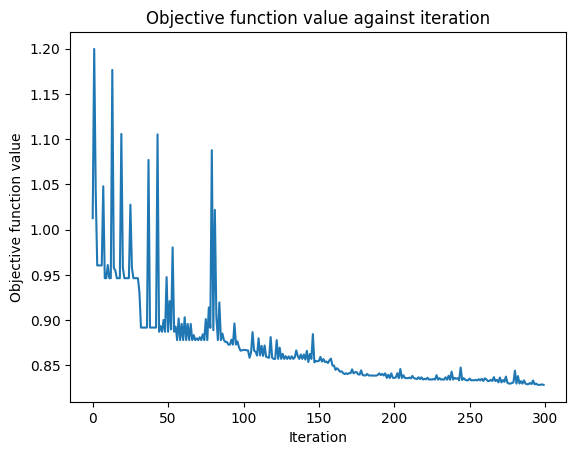

Precision:
 [0.7319444444444445, 0.698005698005698, 0.7396011396011396, 0.7375104427736007, 0.7319444444444445, 0.7098332554153031, 0.688131313131313, 0.7407407407407407, 0.7098332554153031, 0.7949346405228758]
Accuracy:
 [0.7222222222222222, 0.7037037037037037, 0.7407407407407407, 0.7407407407407407, 0.7222222222222222, 0.7037037037037037, 0.6851851851851852, 0.7407407407407407, 0.7037037037037037, 0.7962962962962963]
Recalls:
 [0.7207792207792207, 0.6623376623376623, 0.7012987012987013, 0.7186147186147187, 0.7207792207792207, 0.696969696969697, 0.6731601731601732, 0.7272727272727273, 0.696969696969697, 0.7813852813852814]
F1:
 [0.7248677248677249, 0.6913580246913581, 0.7299382716049384, 0.7380718954248366, 0.7248677248677249, 0.7058080808080809, 0.6864241701451003, 0.7407407407407407, 0.7058080808080809, 0.7953322816810258]
Time:
 [522.0702648162842, 522.9399790763855, 527.4027986526489, 522.7422204017639, 527.0542721748352, 523.7103950977325, 522.237108707428, 477.006174325943, 419.

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=6)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

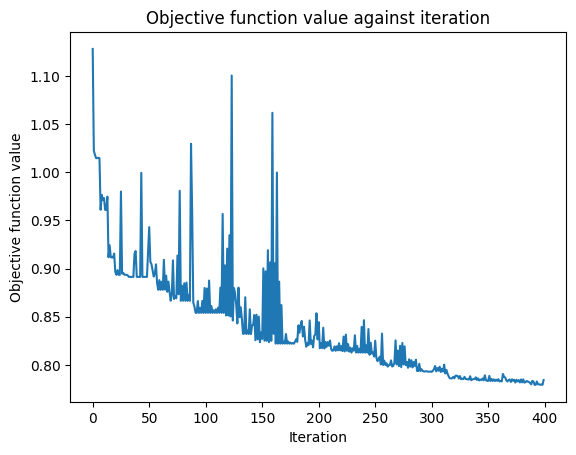

Precision:
 [0.7037037037037037, 0.7098332554153031, 0.6826797385620915, 0.7580409356725147, 0.7777777777777778, 0.7098332554153031, 0.7754385964912281, 0.7830762038335671, 0.757516339869281, 0.7319444444444445]
Accuracy:
 [0.7037037037037037, 0.7037037037037037, 0.6851851851851852, 0.7592592592592593, 0.7777777777777778, 0.7037037037037037, 0.7777777777777778, 0.7777777777777778, 0.7592592592592593, 0.7222222222222222]
Recalls:
 [0.6883116883116883, 0.696969696969697, 0.6645021645021645, 0.725108225108225, 0.7662337662337663, 0.696969696969697, 0.7575757575757576, 0.7748917748917749, 0.7424242424242424, 0.7207792207792207]
F1:
 [0.7037037037037037, 0.7058080808080809, 0.6836953444161308, 0.7514697796387937, 0.7777777777777778, 0.7058080808080809, 0.7754901960784314, 0.7793560606060607, 0.7581199692593941, 0.7248677248677249]
Time:
 [754.2899744510651, 628.8401494026184, 669.6935555934906, 780.286524772644, 765.8867089748383, 771.0584940910339, 751.0037779808044, 789.8105418682098, 818

In [8]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 400
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=7)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

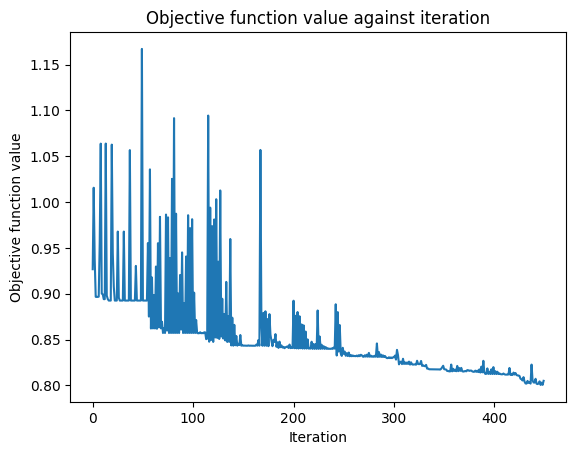

Precision:
 [0.791264367816092, 0.8551492669139727, 0.7200980392156863, 0.7654320987654322, 0.7616792929292928, 0.7616792929292928, 0.8133667502088555, 0.746454729624435, 0.718007662835249, 0.8133667502088555]
Accuracy:
 [0.7777777777777778, 0.8518518518518519, 0.7222222222222222, 0.7407407407407407, 0.7592592592592593, 0.7592592592592593, 0.8148148148148148, 0.7407407407407407, 0.7037037037037037, 0.8148148148148148]
Recalls:
 [0.7835497835497836, 0.8268398268398269, 0.7034632034632035, 0.7532467532467533, 0.751082251082251, 0.751082251082251, 0.7965367965367965, 0.7359307359307359, 0.7056277056277056, 0.7965367965367965]
F1:
 [0.7802711547452081, 0.8482873851294904, 0.7209076568377624, 0.7439814814814815, 0.7602067183462532, 0.7602067183462532, 0.8129084967320261, 0.7425820707070706, 0.7070282063269441, 0.8129084967320261]
Time:
 [832.3757035732269, 747.3364832401276, 908.0240099430084, 708.3310220241547, 708.3476111888885, 756.3713541030884, 703.519517660141, 703.0696182250977, 867.

In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)
  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_
  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)
  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 450
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=8)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

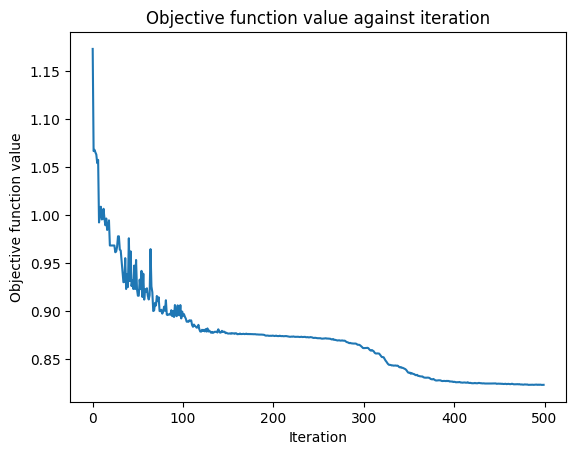

Time:
 [543.942414522171]
Precision:
 [0.7175925925925926]
Accuracy:
 [0.7222222222222222]
Recalls:
 [0.7222222222222222]
F1:
 [0.7175771088814565]


In [5]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 500
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

In [6]:
effsu2_realamp_objective_func_vals = objective_func_vals

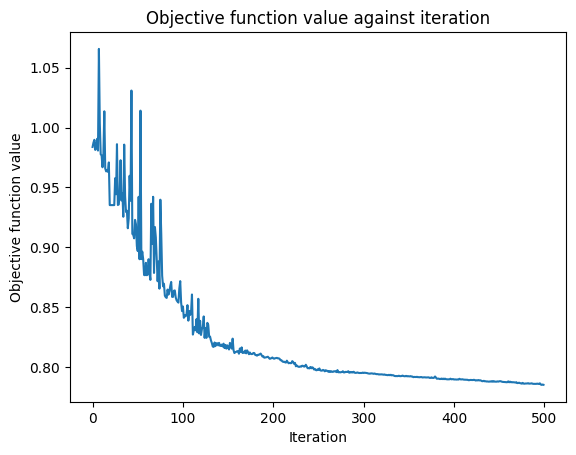

Time:
 [573.0273892879486]
Precision:
 [0.718007662835249]
Accuracy:
 [0.7037037037037037]
Recalls:
 [0.7037037037037037]
F1:
 [0.7070282063269441]


In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 500
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  qc_init = QuantumCircuit(num_qubits)

  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

In [8]:
effsu2_hadamrd_realamp_objective_func_vals = objective_func_vals

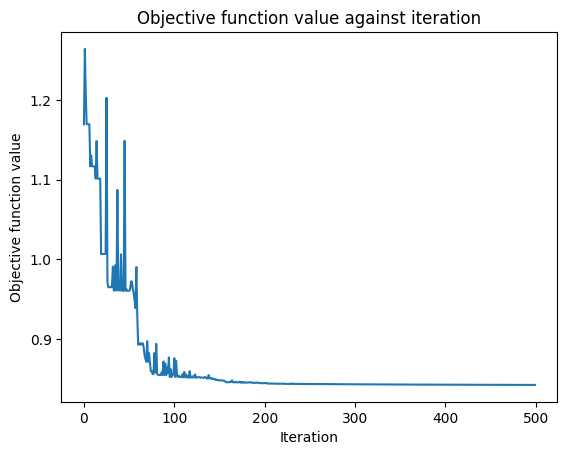

Precision:
 [0.6596194503171247]
Accuracy:
 [0.6666666666666666]
Recall:
 [0.6060606060606061]
F1:
 [0.6365131578947368]
Time:
 [573.6143698692322]
Mean Precision: 0.6596194503171247±0.0
Mean Accuracy: 0.6666666666666666±0.0
Mean Recall: 0.6060606060606061±0.0
Mean F1: 0.6365131578947368±0.0
Mean Time: 573.6143698692322±0.0


In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

In [12]:
effsu2_paulidl_objective_func_vals = objective_func_vals

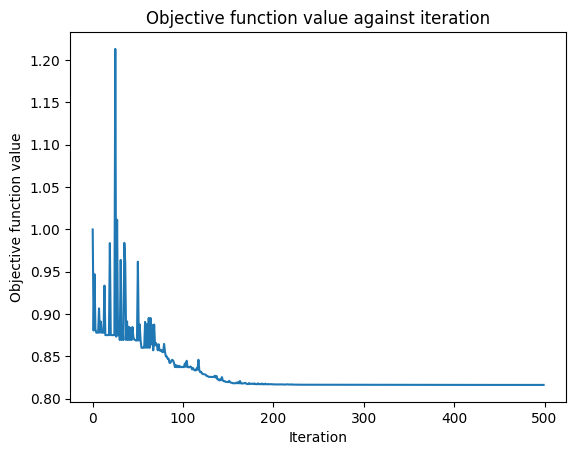

Precision:
 [0.7949346405228758]
Accuracy:
 [0.7962962962962963]
Recall:
 [0.7813852813852814]
F1:
 [0.7953322816810258]
Time:
 [599.5577566623688]
Mean Precision: 0.7949346405228758±0.0
Mean Accuracy: 0.7962962962962963±0.0
Mean Recall: 0.7813852813852814±0.0
Mean F1: 0.7953322816810258±0.0
Mean Time: 599.5577566623688±0.0


In [14]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  qc_init = QuantumCircuit(num_qubits)

  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

In [15]:
effsu2_paulidl_hadamard_objective_func_vals = objective_func_vals

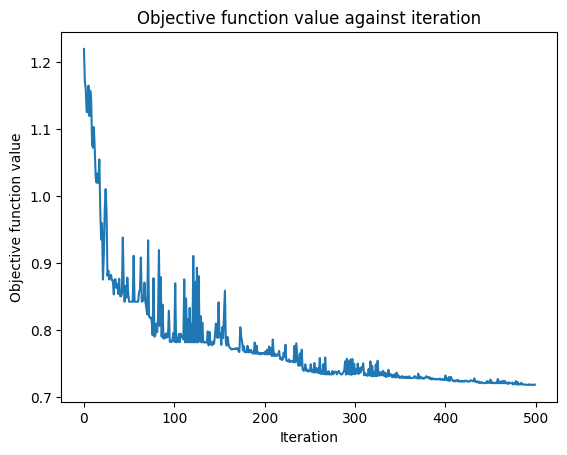

Precision:
 [0.7369722663840311]
Accuracy:
 [0.7407407407407407]
Recall:
 [0.7099567099567099]
F1:
 [0.7345029239766083]
Time:
 [1067.9296073913574]
Mean Precision: 0.7369722663840311±0.0
Mean Accuracy: 0.7407407407407407±0.0
Mean Recall: 0.7099567099567099±0.0
Mean F1: 0.7345029239766083±0.0
Mean Time: 1067.9296073913574±0.0


In [17]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, rotation_blocks=['rz', 'ry'],
                    entanglement_blocks='cz')





  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

In [18]:
effsu2_twolocal_objective_func_vals = objective_func_vals

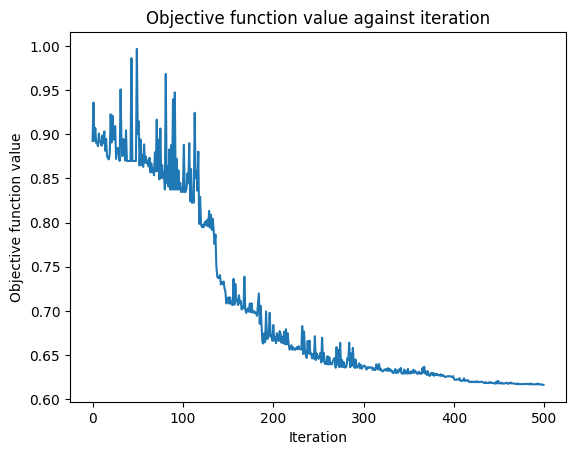

Precision:
 [0.7949346405228758]
Accuracy:
 [0.7962962962962963]
Recall:
 [0.7813852813852814]
F1:
 [0.7953322816810258]
Time:
 [927.8416996002197]
Mean Precision: 0.7949346405228758±0.0
Mean Accuracy: 0.7962962962962963±0.0
Mean Recall: 0.7813852813852814±0.0
Mean F1: 0.7953322816810258±0.0
Mean Time: 927.8416996002197±0.0


In [19]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  qc_init = QuantumCircuit(num_qubits)

  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, rotation_blocks=['rz', 'ry'],
                    entanglement_blocks='cz')





  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

In [20]:
effsu2_hadamard_twolocal_objective_func_vals = objective_func_vals

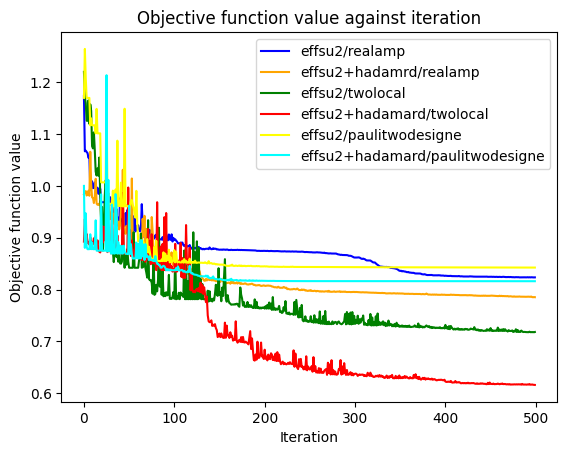

In [21]:
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")

# Blue
# Red
# Green
# Cyan
# Magenta
# Yellow
# Black
# White
# Orange
# Purple

plt.plot(range(len(effsu2_realamp_objective_func_vals)), 
         effsu2_realamp_objective_func_vals, color='blue', label='effsu2/realamp')
plt.plot(range(len(effsu2_hadamrd_realamp_objective_func_vals)), 
         effsu2_hadamrd_realamp_objective_func_vals, color='orange', 
         label='effsu2+hadamrd/realamp')
plt.plot(range(len(effsu2_twolocal_objective_func_vals)), 
         effsu2_twolocal_objective_func_vals, color='green',
         label='effsu2/twolocal')
plt.plot(range(len(effsu2_hadamard_twolocal_objective_func_vals)), 
         effsu2_hadamard_twolocal_objective_func_vals, color='red',
         label='effsu2+hadamard/twolocal')
plt.plot(range(len(effsu2_paulidl_objective_func_vals)), 
         effsu2_paulidl_objective_func_vals, color='yellow',
         label='effsu2/paulitwodesigne')
# plt.plot(range(len(effsu2_paulidl_objective_func_vals)), 
#          effsu2_paulidl_objective_func_vals, color='yellow',
#          label='effsu2/paulitwodesigne')
plt.plot(range(len(effsu2_paulidl_hadamard_objective_func_vals)), 
         effsu2_paulidl_hadamard_objective_func_vals, color='cyan',
         label='effsu2+hadamard/paulitwodesigne')
# effsu2_paulidl_hadamard_objective_func_vals
plt.legend()
plt.show()

# **Classical Neural Networks**

In [23]:
model = Sequential()
input_shape = X.shape[1]

In [24]:
model.add(Dense(1, activation='relu', input_shape=(input_shape,)))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [31]:
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
7/7 [==============================] - 1s 3ms/step - loss: 0.8272 - accuracy: 0.2593
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.8262 - accuracy: 0.2593
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8255 - accuracy: 0.2593
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8249 - accuracy: 0.2593
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.8242 - accuracy: 0.2593
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8235 - accuracy: 0.2593
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8229 - accuracy: 0.2593
Epoch 8/100
7/7 [==============================] - 0s 5ms/step - loss: 0.8222 - accuracy: 0.2593
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.8213 - accuracy: 0.2593
Epoch 10/100
7/7 [==============================] - 0s 5ms/step - loss: 0.8205 - accuracy: 0.2593
Epoch 11/100
7/7 [===========

In [32]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)

In [34]:
accuracy

0.18518517911434174

In [87]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(1, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

    class_mapping = {-1: 0, 1: 1}
    Y_train = np.array([class_mapping[y] for y in Y_train])
    Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

    Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    # Y_pred = np.argmax(y_pred_numeric,axis=1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
6/6 [==============================] - 1s 60ms/step - loss: 0.7108 - accuracy: 0.5698 - val_loss: 0.7168 - val_accuracy: 0.5455
Epoch 2/100
6/6 [==============================] - 0s 18ms/step - loss: 0.7067 - accuracy: 0.5698 - val_loss: 0.7132 - val_accuracy: 0.5227
Epoch 3/100
6/6 [==============================] - 0s 19ms/step - loss: 0.7029 - accuracy: 0.5698 - val_loss: 0.7095 - val_accuracy: 0.5227
Epoch 4/100
6/6 [==============================] - 0s 26ms/step - loss: 0.6993 - accuracy: 0.5698 - val_loss: 0.7058 - val_accuracy: 0.5227
Epoch 5/100
6/6 [==============================] - 0s 17ms/step - loss: 0.6952 - accuracy: 0.5698 - val_loss: 0.7025 - val_accuracy: 0.5227
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6922 - accuracy: 0.5814 - val_loss: 0.6993 - val_accuracy: 0.5227
Epoch 7/100
6/6 [==============================] - 0s 23ms/step - loss: 0.6887 - accuracy: 0.5872 - val_loss: 0.6962 - val_accuracy: 0.5227
Epoch 8/100
6/6 [===

6/6 [==============================] - 0s 14ms/step - loss: 0.7194 - accuracy: 0.6163 - val_loss: 0.5959 - val_accuracy: 0.6136
Epoch 10/100
6/6 [==============================] - 0s 12ms/step - loss: 0.7143 - accuracy: 0.6279 - val_loss: 0.5924 - val_accuracy: 0.6364
Epoch 11/100
6/6 [==============================] - 0s 15ms/step - loss: 0.7098 - accuracy: 0.6337 - val_loss: 0.5900 - val_accuracy: 0.6364
Epoch 12/100
6/6 [==============================] - 0s 12ms/step - loss: 0.7061 - accuracy: 0.6279 - val_loss: 0.5878 - val_accuracy: 0.6364
Epoch 13/100
6/6 [==============================] - 0s 14ms/step - loss: 0.7025 - accuracy: 0.6279 - val_loss: 0.5857 - val_accuracy: 0.6364
Epoch 14/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6985 - accuracy: 0.6279 - val_loss: 0.5836 - val_accuracy: 0.6591
Epoch 15/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6951 - accuracy: 0.6337 - val_loss: 0.5816 - val_accuracy: 0.6591
Epoch 16/100
6/6 [=========

6/6 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.5174 - val_loss: 0.6949 - val_accuracy: 0.6364
Epoch 17/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6919 - accuracy: 0.5174 - val_loss: 0.6948 - val_accuracy: 0.6364
Epoch 18/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6916 - accuracy: 0.5174 - val_loss: 0.6946 - val_accuracy: 0.6364
Epoch 19/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6914 - accuracy: 0.5174 - val_loss: 0.6945 - val_accuracy: 0.6364
Epoch 20/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6911 - accuracy: 0.5174 - val_loss: 0.6942 - val_accuracy: 0.6364
Epoch 21/100
6/6 [==============================] - 0s 24ms/step - loss: 0.6910 - accuracy: 0.5174 - val_loss: 0.6940 - val_accuracy: 0.6364
Epoch 22/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6907 - accuracy: 0.5174 - val_loss: 0.6937 - val_accuracy: 0.6364
Epoch 23/100
6/6 [========

6/6 [==============================] - 0s 10ms/step - loss: 0.6961 - accuracy: 0.5233 - val_loss: 0.6809 - val_accuracy: 0.6591
Epoch 23/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6956 - accuracy: 0.5291 - val_loss: 0.6810 - val_accuracy: 0.6591
Epoch 24/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6954 - accuracy: 0.5291 - val_loss: 0.6812 - val_accuracy: 0.6591
Epoch 25/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6951 - accuracy: 0.5291 - val_loss: 0.6814 - val_accuracy: 0.6591
Epoch 26/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6949 - accuracy: 0.5291 - val_loss: 0.6814 - val_accuracy: 0.6591
Epoch 27/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6945 - accuracy: 0.5349 - val_loss: 0.6815 - val_accuracy: 0.6591
Epoch 28/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6942 - accuracy: 0.5349 - val_loss: 0.6817 - val_accuracy: 0.6591
Epoch 29/100
6/6 [========

Epoch 28/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6119 - accuracy: 0.7151 - val_loss: 0.5749 - val_accuracy: 0.7045
Epoch 29/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6087 - accuracy: 0.7267 - val_loss: 0.5722 - val_accuracy: 0.7045
Epoch 30/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6062 - accuracy: 0.7267 - val_loss: 0.5692 - val_accuracy: 0.7045
Epoch 31/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6031 - accuracy: 0.7326 - val_loss: 0.5667 - val_accuracy: 0.7045
Epoch 32/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6005 - accuracy: 0.7267 - val_loss: 0.5641 - val_accuracy: 0.7045
Epoch 33/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5981 - accuracy: 0.7267 - val_loss: 0.5616 - val_accuracy: 0.7045
Epoch 34/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5953 - accuracy: 0.7267 - val_loss: 0.5596 - val_accuracy: 0.7045
Epoch 35/100


6/6 [==============================] - 0s 12ms/step - loss: 0.5942 - accuracy: 0.7209 - val_loss: 0.5625 - val_accuracy: 0.8182
Epoch 34/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5926 - accuracy: 0.7209 - val_loss: 0.5604 - val_accuracy: 0.8182
Epoch 35/100
6/6 [==============================] - 0s 18ms/step - loss: 0.5911 - accuracy: 0.7267 - val_loss: 0.5585 - val_accuracy: 0.8182
Epoch 36/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5897 - accuracy: 0.7267 - val_loss: 0.5565 - val_accuracy: 0.8182
Epoch 37/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5883 - accuracy: 0.7267 - val_loss: 0.5542 - val_accuracy: 0.8182
Epoch 38/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5867 - accuracy: 0.7267 - val_loss: 0.5523 - val_accuracy: 0.8182
Epoch 39/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5853 - accuracy: 0.7267 - val_loss: 0.5503 - val_accuracy: 0.8182
Epoch 40/100
6/6 [=========

6/6 [==============================] - 0s 13ms/step - loss: 0.6710 - accuracy: 0.6163 - val_loss: 0.6654 - val_accuracy: 0.7045
Epoch 38/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6700 - accuracy: 0.6163 - val_loss: 0.6643 - val_accuracy: 0.6818
Epoch 39/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6686 - accuracy: 0.6221 - val_loss: 0.6632 - val_accuracy: 0.7045
Epoch 40/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6675 - accuracy: 0.6221 - val_loss: 0.6618 - val_accuracy: 0.7045
Epoch 41/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6661 - accuracy: 0.6163 - val_loss: 0.6604 - val_accuracy: 0.7045
Epoch 42/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6647 - accuracy: 0.6221 - val_loss: 0.6591 - val_accuracy: 0.7045
Epoch 43/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6633 - accuracy: 0.6337 - val_loss: 0.6577 - val_accuracy: 0.7045
Epoch 44/100
6/6 [========

6/6 [==============================] - 0s 12ms/step - loss: 0.7276 - accuracy: 0.5523 - val_loss: 0.6796 - val_accuracy: 0.6591
Epoch 41/100
6/6 [==============================] - 0s 14ms/step - loss: 0.7258 - accuracy: 0.5523 - val_loss: 0.6775 - val_accuracy: 0.6591
Epoch 42/100
6/6 [==============================] - 0s 11ms/step - loss: 0.7238 - accuracy: 0.5523 - val_loss: 0.6755 - val_accuracy: 0.6591
Epoch 43/100
6/6 [==============================] - 0s 14ms/step - loss: 0.7221 - accuracy: 0.5523 - val_loss: 0.6733 - val_accuracy: 0.6818
Epoch 44/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7204 - accuracy: 0.5523 - val_loss: 0.6714 - val_accuracy: 0.6818
Epoch 45/100
6/6 [==============================] - 0s 14ms/step - loss: 0.7188 - accuracy: 0.5523 - val_loss: 0.6697 - val_accuracy: 0.6818
Epoch 46/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7172 - accuracy: 0.5523 - val_loss: 0.6682 - val_accuracy: 0.6818
Epoch 47/100
6/6 [========

Epoch 43/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6404 - accuracy: 0.6919 - val_loss: 0.6085 - val_accuracy: 0.5909
Epoch 44/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6384 - accuracy: 0.6919 - val_loss: 0.6067 - val_accuracy: 0.5909
Epoch 45/100
6/6 [==============================] - 0s 20ms/step - loss: 0.6365 - accuracy: 0.6919 - val_loss: 0.6046 - val_accuracy: 0.5909
Epoch 46/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6344 - accuracy: 0.6919 - val_loss: 0.6021 - val_accuracy: 0.5909
Epoch 47/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6326 - accuracy: 0.6919 - val_loss: 0.5996 - val_accuracy: 0.5909
Epoch 48/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6307 - accuracy: 0.6919 - val_loss: 0.5973 - val_accuracy: 0.5909
Epoch 49/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6288 - accuracy: 0.6919 - val_loss: 0.5949 - val_accuracy: 0.5909
Epoch 50/100
6

2/2 [==============================] - 0s 7ms/step
Model: "sequential_184"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_388 (Dense)           (None, 1)                 14        
                                                                 
 dense_389 (Dense)           (None, 1)                 2         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.7396011396011396, 0.8133667502088555, 0.8500000000000001, 0.5705128205128206, 0.8551492669139727, 0.7802469135802469, 0.8359391286220555, 0.7802469135802469, 0.7947530864197532]
Accuracy:
 [0.7407407407407407, 0.8148148148148148, 0.8333333333333334, 0.6111111111111112, 0.8518518518518519, 0.7407407407407407, 0.8148148148148148, 0.7407407407407407, 0.7962962962962963]
Recalls:
 [0.701

 dense_390 (Dense)           (None, 1)                 14        
                                                                 
 dense_391 (Dense)           (None, 1)                 2         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.7396011396011396, 0.8133667502088555, 0.8500000000000001, 0.5705128205128206, 0.8551492669139727, 0.7802469135802469, 0.8359391286220555, 0.7802469135802469, 0.7947530864197532, 0.8083157152924595]
Accuracy:
 [0.7407407407407407, 0.8148148148148148, 0.8333333333333334, 0.6111111111111112, 0.8518518518518519, 0.7407407407407407, 0.8148148148148148, 0.7407407407407407, 0.7962962962962963, 0.7777777777777778]
Recalls:
 [0.7012987012987013, 0.7965367965367965, 0.7943722943722944, 0.5086580086580087, 0.8268398268398269, 0.6753246753246753, 0.7705627705627706, 0.6753246753246753, 0.7727272727

In [88]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(2, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

    class_mapping = {-1: 0, 1: 1}
    Y_train = np.array([class_mapping[y] for y in Y_train])
    Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

    Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    # Y_pred = np.argmax(y_pred_numeric,axis=1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
6/6 [==============================] - 1s 49ms/step - loss: 0.6414 - accuracy: 0.7500 - val_loss: 0.6822 - val_accuracy: 0.7045
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 0.6381 - accuracy: 0.7500 - val_loss: 0.6810 - val_accuracy: 0.7045
Epoch 3/100
6/6 [==============================] - 0s 22ms/step - loss: 0.6353 - accuracy: 0.7558 - val_loss: 0.6798 - val_accuracy: 0.7045
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6325 - accuracy: 0.7616 - val_loss: 0.6787 - val_accuracy: 0.7273
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6293 - accuracy: 0.7674 - val_loss: 0.6772 - val_accuracy: 0.7273
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6263 - accuracy: 0.7616 - val_loss: 0.6757 - val_accuracy: 0.7273
Epoch 7/100
6/6 [==============================] - 0s 17ms/step - loss: 0.6234 - accuracy: 0.7674 - val_loss: 0.6745 - val_accuracy: 0.7273
Epoch 8/100
6/6 [===

6/6 [==============================] - 0s 12ms/step - loss: 0.6474 - accuracy: 0.6686 - val_loss: 0.6379 - val_accuracy: 0.7955
Epoch 10/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6421 - accuracy: 0.6686 - val_loss: 0.6340 - val_accuracy: 0.8182
Epoch 11/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6373 - accuracy: 0.6802 - val_loss: 0.6300 - val_accuracy: 0.8182
Epoch 12/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6315 - accuracy: 0.7035 - val_loss: 0.6261 - val_accuracy: 0.8182
Epoch 13/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6262 - accuracy: 0.7035 - val_loss: 0.6222 - val_accuracy: 0.8182
Epoch 14/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6214 - accuracy: 0.7093 - val_loss: 0.6186 - val_accuracy: 0.8182
Epoch 15/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6163 - accuracy: 0.7093 - val_loss: 0.6149 - val_accuracy: 0.8182
Epoch 16/100
6/6 [=========

6/6 [==============================] - 0s 17ms/step - loss: 0.8901 - accuracy: 0.4709 - val_loss: 0.9028 - val_accuracy: 0.4318
Epoch 17/100
6/6 [==============================] - 0s 15ms/step - loss: 0.8727 - accuracy: 0.4826 - val_loss: 0.8805 - val_accuracy: 0.4545
Epoch 18/100
6/6 [==============================] - 0s 14ms/step - loss: 0.8561 - accuracy: 0.4826 - val_loss: 0.8618 - val_accuracy: 0.5000
Epoch 19/100
6/6 [==============================] - 0s 25ms/step - loss: 0.8421 - accuracy: 0.4826 - val_loss: 0.8433 - val_accuracy: 0.5000
Epoch 20/100
6/6 [==============================] - 0s 9ms/step - loss: 0.8286 - accuracy: 0.4826 - val_loss: 0.8254 - val_accuracy: 0.4773
Epoch 21/100
6/6 [==============================] - 0s 17ms/step - loss: 0.8146 - accuracy: 0.5000 - val_loss: 0.8074 - val_accuracy: 0.5000
Epoch 22/100
6/6 [==============================] - 0s 13ms/step - loss: 0.8027 - accuracy: 0.5058 - val_loss: 0.7897 - val_accuracy: 0.5000
Epoch 23/100
6/6 [=========

6/6 [==============================] - 0s 13ms/step - loss: 0.6190 - accuracy: 0.6628 - val_loss: 0.5251 - val_accuracy: 0.7955
Epoch 23/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6147 - accuracy: 0.6628 - val_loss: 0.5233 - val_accuracy: 0.7955
Epoch 24/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6102 - accuracy: 0.6686 - val_loss: 0.5212 - val_accuracy: 0.7955
Epoch 25/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6060 - accuracy: 0.6744 - val_loss: 0.5191 - val_accuracy: 0.7955
Epoch 26/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6018 - accuracy: 0.6802 - val_loss: 0.5166 - val_accuracy: 0.7955
Epoch 27/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5981 - accuracy: 0.6860 - val_loss: 0.5138 - val_accuracy: 0.7955
Epoch 28/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5940 - accuracy: 0.6919 - val_loss: 0.5113 - val_accuracy: 0.7955
Epoch 29/100
6/6 [========

Epoch 28/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6362 - accuracy: 0.6977 - val_loss: 0.6787 - val_accuracy: 0.5227
Epoch 29/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6338 - accuracy: 0.6919 - val_loss: 0.6765 - val_accuracy: 0.5455
Epoch 30/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6318 - accuracy: 0.6919 - val_loss: 0.6740 - val_accuracy: 0.5455
Epoch 31/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6296 - accuracy: 0.6919 - val_loss: 0.6715 - val_accuracy: 0.5682
Epoch 32/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6274 - accuracy: 0.7035 - val_loss: 0.6690 - val_accuracy: 0.5909
Epoch 33/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6254 - accuracy: 0.7093 - val_loss: 0.6669 - val_accuracy: 0.5909
Epoch 34/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6231 - accuracy: 0.7093 - val_loss: 0.6647 - val_accuracy: 0.6136
Epoch 35/100
6

6/6 [==============================] - 0s 11ms/step - loss: 0.7001 - accuracy: 0.6221 - val_loss: 0.6705 - val_accuracy: 0.6136
Epoch 34/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.6279 - val_loss: 0.6668 - val_accuracy: 0.6136
Epoch 35/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6881 - accuracy: 0.6395 - val_loss: 0.6633 - val_accuracy: 0.6136
Epoch 36/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6826 - accuracy: 0.6453 - val_loss: 0.6600 - val_accuracy: 0.6136
Epoch 37/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6775 - accuracy: 0.6570 - val_loss: 0.6568 - val_accuracy: 0.6136
Epoch 38/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6722 - accuracy: 0.6628 - val_loss: 0.6536 - val_accuracy: 0.6136
Epoch 39/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6681 - accuracy: 0.6628 - val_loss: 0.6503 - val_accuracy: 0.6136
Epoch 40/100
6/6 [========

6/6 [==============================] - 0s 14ms/step - loss: 0.6348 - accuracy: 0.6570 - val_loss: 0.5941 - val_accuracy: 0.7727
Epoch 38/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6335 - accuracy: 0.6570 - val_loss: 0.5927 - val_accuracy: 0.7727
Epoch 39/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6317 - accuracy: 0.6628 - val_loss: 0.5913 - val_accuracy: 0.7727
Epoch 40/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6303 - accuracy: 0.6628 - val_loss: 0.5899 - val_accuracy: 0.7727
Epoch 41/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6289 - accuracy: 0.6628 - val_loss: 0.5885 - val_accuracy: 0.7727
Epoch 42/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6276 - accuracy: 0.6686 - val_loss: 0.5871 - val_accuracy: 0.7727
Epoch 43/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6262 - accuracy: 0.6744 - val_loss: 0.5857 - val_accuracy: 0.7727
Epoch 44/100
6/6 [========

Epoch 41/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5777 - accuracy: 0.7267 - val_loss: 0.5448 - val_accuracy: 0.7500
Epoch 42/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5741 - accuracy: 0.7384 - val_loss: 0.5408 - val_accuracy: 0.7500
Epoch 43/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5708 - accuracy: 0.7442 - val_loss: 0.5369 - val_accuracy: 0.7500
Epoch 44/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5672 - accuracy: 0.7558 - val_loss: 0.5335 - val_accuracy: 0.7500
Epoch 45/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5638 - accuracy: 0.7558 - val_loss: 0.5302 - val_accuracy: 0.7500
Epoch 46/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5607 - accuracy: 0.7616 - val_loss: 0.5270 - val_accuracy: 0.7500
Epoch 47/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5579 - accuracy: 0.7674 - val_loss: 0.5238 - val_accuracy: 0.7500
Epoch 48/100
6

6/6 [==============================] - 0s 12ms/step - loss: 0.6316 - accuracy: 0.7209 - val_loss: 0.6294 - val_accuracy: 0.7955
Epoch 45/100
6/6 [==============================] - 0s 27ms/step - loss: 0.6298 - accuracy: 0.7209 - val_loss: 0.6276 - val_accuracy: 0.7955
Epoch 46/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6283 - accuracy: 0.7209 - val_loss: 0.6258 - val_accuracy: 0.7955
Epoch 47/100
6/6 [==============================] - 0s 23ms/step - loss: 0.6262 - accuracy: 0.7209 - val_loss: 0.6241 - val_accuracy: 0.7955
Epoch 48/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6247 - accuracy: 0.7209 - val_loss: 0.6224 - val_accuracy: 0.8182
Epoch 49/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6232 - accuracy: 0.7267 - val_loss: 0.6206 - val_accuracy: 0.8182
Epoch 50/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6213 - accuracy: 0.7326 - val_loss: 0.6190 - val_accuracy: 0.8182
Epoch 51/100
6/6 [========

 Layer (type)                Output Shape              Param #   
 dense_408 (Dense)           (None, 2)                 28        
                                                                 
 dense_409 (Dense)           (None, 1)                 3         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.8945416004239534, 0.7580409356725147, 0.8518518518518519, 0.8333333333333334, 0.8133667502088555, 0.8500000000000001, 0.6237259816207185, 0.8892230576441102, 0.7176535087719297]
Accuracy:
 [0.8888888888888888, 0.7592592592592593, 0.8518518518518519, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.6296296296296297, 0.8888888888888888, 0.7222222222222222]
Recalls:
 [0.8658008658008658, 0.725108225108225, 0.8441558441558441, 0.8116883116883117, 0.7965367965367965, 0.7943722943722944, 0.6017316017316017, 0.87445

Epoch 47/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6296 - accuracy: 0.6860 - val_loss: 0.6769 - val_accuracy: 0.6364
Epoch 48/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6267 - accuracy: 0.6860 - val_loss: 0.6739 - val_accuracy: 0.6364
Epoch 49/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6240 - accuracy: 0.6919 - val_loss: 0.6708 - val_accuracy: 0.6364
Epoch 50/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6208 - accuracy: 0.6919 - val_loss: 0.6685 - val_accuracy: 0.6364
Epoch 51/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6182 - accuracy: 0.6919 - val_loss: 0.6659 - val_accuracy: 0.6364
Epoch 52/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6154 - accuracy: 0.6919 - val_loss: 0.6637 - val_accuracy: 0.6364
Epoch 53/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6127 - accuracy: 0.6977 - val_loss: 0.6616 - val_accuracy: 0.6364
Epoch 54/100
6/6 [==

Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.8945416004239534, 0.7580409356725147, 0.8518518518518519, 0.8333333333333334, 0.8133667502088555, 0.8500000000000001, 0.6237259816207185, 0.8892230576441102, 0.7176535087719297, 0.7777777777777778]
Accuracy:
 [0.8888888888888888, 0.7592592592592593, 0.8518518518518519, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.6296296296296297, 0.8888888888888888, 0.7222222222222222, 0.7777777777777778]
Recalls:
 [0.8658008658008658, 0.725108225108225, 0.8441558441558441, 0.8116883116883117, 0.7965367965367965, 0.7943722943722944, 0.6017316017316017, 0.8744588744588745, 0.6861471861471862, 0.7662337662337663]
F1:
 [0.8862155388471178, 0.7514697796387937, 0.8518518518518519, 0.830546265328874, 0.8129084967320261, 0.8246575342465754, 0.6258169934640523, 0.8877450980392156, 0.7132343611216851, 0.7777777777777778]
Time:
 [9.292766809463501, 8.018

In [89]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(3, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

    class_mapping = {-1: 0, 1: 1}
    Y_train = np.array([class_mapping[y] for y in Y_train])
    Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

    Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    # Y_pred = np.argmax(y_pred_numeric,axis=1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
6/6 [==============================] - 1s 32ms/step - loss: 0.7597 - accuracy: 0.3779 - val_loss: 0.7286 - val_accuracy: 0.4545
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.7530 - accuracy: 0.3721 - val_loss: 0.7249 - val_accuracy: 0.4545
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 0.7482 - accuracy: 0.3605 - val_loss: 0.7216 - val_accuracy: 0.4545
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.7419 - accuracy: 0.3721 - val_loss: 0.7186 - val_accuracy: 0.4773
Epoch 5/100
6/6 [==============================] - 0s 19ms/step - loss: 0.7367 - accuracy: 0.3837 - val_loss: 0.7156 - val_accuracy: 0.4773
Epoch 6/100
6/6 [==============================] - 0s 19ms/step - loss: 0.7318 - accuracy: 0.3837 - val_loss: 0.7131 - val_accuracy: 0.5000
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.7271 - accuracy: 0.3895 - val_loss: 0.7105 - val_accuracy: 0.5000
Epoch 8/100
6/6 [===

6/6 [==============================] - 0s 10ms/step - loss: 0.6907 - accuracy: 0.4651 - val_loss: 0.6931 - val_accuracy: 0.3409
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.4709 - val_loss: 0.6882 - val_accuracy: 0.3409
Epoch 11/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6854 - accuracy: 0.4709 - val_loss: 0.6838 - val_accuracy: 0.3409
Epoch 12/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6833 - accuracy: 0.4651 - val_loss: 0.6797 - val_accuracy: 0.3636
Epoch 13/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6813 - accuracy: 0.4709 - val_loss: 0.6764 - val_accuracy: 0.3864
Epoch 14/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6795 - accuracy: 0.4884 - val_loss: 0.6733 - val_accuracy: 0.4318
Epoch 15/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6779 - accuracy: 0.4942 - val_loss: 0.6702 - val_accuracy: 0.4545
Epoch 16/100
6/6 [==============

Epoch 17/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5809 - accuracy: 0.7267 - val_loss: 0.5279 - val_accuracy: 0.7955
Epoch 18/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5777 - accuracy: 0.7209 - val_loss: 0.5233 - val_accuracy: 0.7955
Epoch 19/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5734 - accuracy: 0.7326 - val_loss: 0.5189 - val_accuracy: 0.7955
Epoch 20/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5696 - accuracy: 0.7384 - val_loss: 0.5144 - val_accuracy: 0.8182
Epoch 21/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5657 - accuracy: 0.7442 - val_loss: 0.5097 - val_accuracy: 0.8182
Epoch 22/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5612 - accuracy: 0.7558 - val_loss: 0.5055 - val_accuracy: 0.8182
Epoch 23/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5574 - accuracy: 0.7558 - val_loss: 0.5008 - val_accuracy: 0.8182
Epoch 24/100
6/6 [=

Epoch 24/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6540 - accuracy: 0.6744 - val_loss: 0.6540 - val_accuracy: 0.7500
Epoch 25/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6515 - accuracy: 0.6802 - val_loss: 0.6512 - val_accuracy: 0.7500
Epoch 26/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6488 - accuracy: 0.6744 - val_loss: 0.6484 - val_accuracy: 0.7500
Epoch 27/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6464 - accuracy: 0.6802 - val_loss: 0.6458 - val_accuracy: 0.7500
Epoch 28/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6437 - accuracy: 0.6802 - val_loss: 0.6431 - val_accuracy: 0.7500
Epoch 29/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6415 - accuracy: 0.6802 - val_loss: 0.6403 - val_accuracy: 0.7727
Epoch 30/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6389 - accuracy: 0.6802 - val_loss: 0.6377 - val_accuracy: 0.7727
Epoch 31/100
6/6 [==

6/6 [==============================] - 0s 6ms/step - loss: 0.5269 - accuracy: 0.7326 - val_loss: 0.4511 - val_accuracy: 0.8182
Epoch 31/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5224 - accuracy: 0.7384 - val_loss: 0.4461 - val_accuracy: 0.8182
Epoch 32/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5181 - accuracy: 0.7442 - val_loss: 0.4420 - val_accuracy: 0.8182
Epoch 33/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5137 - accuracy: 0.7500 - val_loss: 0.4377 - val_accuracy: 0.8182
Epoch 34/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5096 - accuracy: 0.7558 - val_loss: 0.4345 - val_accuracy: 0.8182
Epoch 35/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5060 - accuracy: 0.7558 - val_loss: 0.4305 - val_accuracy: 0.8182
Epoch 36/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5025 - accuracy: 0.7558 - val_loss: 0.4269 - val_accuracy: 0.8182
Epoch 37/100
6/6 [==============

6/6 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.6395 - val_loss: 0.5732 - val_accuracy: 0.6818
Epoch 36/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6158 - accuracy: 0.6628 - val_loss: 0.5678 - val_accuracy: 0.7045
Epoch 37/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6108 - accuracy: 0.6744 - val_loss: 0.5621 - val_accuracy: 0.7045
Epoch 38/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6059 - accuracy: 0.6802 - val_loss: 0.5563 - val_accuracy: 0.7045
Epoch 39/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6012 - accuracy: 0.6802 - val_loss: 0.5505 - val_accuracy: 0.7045
Epoch 40/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5968 - accuracy: 0.6744 - val_loss: 0.5447 - val_accuracy: 0.7045
Epoch 41/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5922 - accuracy: 0.6919 - val_loss: 0.5394 - val_accuracy: 0.7045
Epoch 42/100
6/6 [===============

6/6 [==============================] - 0s 7ms/step - loss: 0.5405 - accuracy: 0.7791 - val_loss: 0.5185 - val_accuracy: 0.7727
Epoch 40/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5369 - accuracy: 0.7849 - val_loss: 0.5137 - val_accuracy: 0.7727
Epoch 41/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5330 - accuracy: 0.7907 - val_loss: 0.5094 - val_accuracy: 0.7727
Epoch 42/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5295 - accuracy: 0.7907 - val_loss: 0.5051 - val_accuracy: 0.7955
Epoch 43/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5259 - accuracy: 0.7907 - val_loss: 0.5013 - val_accuracy: 0.7955
Epoch 44/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5221 - accuracy: 0.7907 - val_loss: 0.4976 - val_accuracy: 0.7955
Epoch 45/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5180 - accuracy: 0.7849 - val_loss: 0.4942 - val_accuracy: 0.7955
Epoch 46/100
6/6 [===============

Epoch 43/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4978 - accuracy: 0.7674 - val_loss: 0.5077 - val_accuracy: 0.7727
Epoch 44/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4952 - accuracy: 0.7733 - val_loss: 0.5064 - val_accuracy: 0.7955
Epoch 45/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4927 - accuracy: 0.7791 - val_loss: 0.5059 - val_accuracy: 0.7955
Epoch 46/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4900 - accuracy: 0.7791 - val_loss: 0.5042 - val_accuracy: 0.7955
Epoch 47/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4876 - accuracy: 0.7791 - val_loss: 0.5020 - val_accuracy: 0.7955
Epoch 48/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4850 - accuracy: 0.7849 - val_loss: 0.5002 - val_accuracy: 0.7955
Epoch 49/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4825 - accuracy: 0.7791 - val_loss: 0.4979 - val_accuracy: 0.7955
Epoch 50/100
6/6 [==

6/6 [==============================] - 0s 8ms/step - loss: 0.5769 - accuracy: 0.7267 - val_loss: 0.5234 - val_accuracy: 0.8409
Epoch 47/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5740 - accuracy: 0.7267 - val_loss: 0.5220 - val_accuracy: 0.8409
Epoch 48/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5713 - accuracy: 0.7267 - val_loss: 0.5207 - val_accuracy: 0.8409
Epoch 49/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5687 - accuracy: 0.7326 - val_loss: 0.5195 - val_accuracy: 0.8409
Epoch 50/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5659 - accuracy: 0.7326 - val_loss: 0.5177 - val_accuracy: 0.8409
Epoch 51/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5633 - accuracy: 0.7326 - val_loss: 0.5162 - val_accuracy: 0.8409
Epoch 52/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5607 - accuracy: 0.7326 - val_loss: 0.5152 - val_accuracy: 0.8409
Epoch 53/100
6/6 [===============

                                                                 
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.8359391286220555, 0.8359391286220555, 0.8792032163742689, 0.8892230576441102, 0.8323529411764705, 0.8512949039264828, 0.933933933933934, 0.7369722663840311, 0.8945416004239534]
Accuracy:
 [0.8148148148148148, 0.8148148148148148, 0.8703703703703703, 0.8888888888888888, 0.8333333333333334, 0.8518518518518519, 0.9259259259259259, 0.7407407407407407, 0.8888888888888888]
Recalls:
 [0.7705627705627706, 0.7705627705627706, 0.8419913419913421, 0.8744588744588745, 0.8203463203463204, 0.8354978354978355, 0.9047619047619048, 0.7099567099567099, 0.8658008658008658]
F1:
 [0.8030383324500971, 0.8030383324500971, 0.8661760351901197, 0.8877450980392156, 0.8325445941026575, 0.850326797385621, 0.9241436925647452, 0.7345029239766083, 0.8862155388471178]
Time:
 [6.297222375869751, 5.6075990200042725,

In [90]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(4, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

    class_mapping = {-1: 0, 1: 1}
    Y_train = np.array([class_mapping[y] for y in Y_train])
    Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

    Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    # Y_pred = np.argmax(y_pred_numeric,axis=1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
6/6 [==============================] - 1s 32ms/step - loss: 0.7142 - accuracy: 0.5872 - val_loss: 0.7628 - val_accuracy: 0.4318
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.7035 - accuracy: 0.5930 - val_loss: 0.7470 - val_accuracy: 0.4773
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.6047 - val_loss: 0.7335 - val_accuracy: 0.5000
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6848 - accuracy: 0.5988 - val_loss: 0.7210 - val_accuracy: 0.5227
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6764 - accuracy: 0.6047 - val_loss: 0.7102 - val_accuracy: 0.5227
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6691 - accuracy: 0.5988 - val_loss: 0.6998 - val_accuracy: 0.5455
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6628 - accuracy: 0.6221 - val_loss: 0.6911 - val_accuracy: 0.5909
Epoch 8/100
6/6 [=======

Epoch 10/100
6/6 [==============================] - 0s 15ms/step - loss: 0.7090 - accuracy: 0.5814 - val_loss: 0.6572 - val_accuracy: 0.5909
Epoch 11/100
6/6 [==============================] - 0s 16ms/step - loss: 0.7046 - accuracy: 0.5814 - val_loss: 0.6547 - val_accuracy: 0.6136
Epoch 12/100
6/6 [==============================] - 0s 7ms/step - loss: 0.7008 - accuracy: 0.5930 - val_loss: 0.6521 - val_accuracy: 0.6136
Epoch 13/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6968 - accuracy: 0.5988 - val_loss: 0.6501 - val_accuracy: 0.6136
Epoch 14/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6929 - accuracy: 0.6105 - val_loss: 0.6494 - val_accuracy: 0.6136
Epoch 15/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6892 - accuracy: 0.6163 - val_loss: 0.6483 - val_accuracy: 0.6136
Epoch 16/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6857 - accuracy: 0.6221 - val_loss: 0.6461 - val_accuracy: 0.6591
Epoch 17/100
6

6/6 [==============================] - 0s 23ms/step - loss: 0.5344 - accuracy: 0.7093 - val_loss: 0.5407 - val_accuracy: 0.8409
Epoch 18/100
6/6 [==============================] - 0s 20ms/step - loss: 0.5284 - accuracy: 0.7151 - val_loss: 0.5342 - val_accuracy: 0.8409
Epoch 19/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5224 - accuracy: 0.7209 - val_loss: 0.5284 - val_accuracy: 0.8409
Epoch 20/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5165 - accuracy: 0.7384 - val_loss: 0.5226 - val_accuracy: 0.8409
Epoch 21/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5118 - accuracy: 0.7616 - val_loss: 0.5169 - val_accuracy: 0.8409
Epoch 22/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5068 - accuracy: 0.7616 - val_loss: 0.5121 - val_accuracy: 0.8409
Epoch 23/100
6/6 [==============================] - 0s 16ms/step - loss: 0.5021 - accuracy: 0.7674 - val_loss: 0.5083 - val_accuracy: 0.8409
Epoch 24/100
6/6 [=========

6/6 [==============================] - 0s 12ms/step - loss: 0.6213 - accuracy: 0.7674 - val_loss: 0.6331 - val_accuracy: 0.7045
Epoch 24/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6160 - accuracy: 0.7616 - val_loss: 0.6271 - val_accuracy: 0.7273
Epoch 25/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6106 - accuracy: 0.7616 - val_loss: 0.6208 - val_accuracy: 0.7727
Epoch 26/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6048 - accuracy: 0.7791 - val_loss: 0.6142 - val_accuracy: 0.7727
Epoch 27/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5988 - accuracy: 0.7791 - val_loss: 0.6078 - val_accuracy: 0.7727
Epoch 28/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5929 - accuracy: 0.7616 - val_loss: 0.6010 - val_accuracy: 0.7727
Epoch 29/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5867 - accuracy: 0.7616 - val_loss: 0.5929 - val_accuracy: 0.7500
Epoch 30/100
6/6 [=========

Epoch 29/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5483 - accuracy: 0.7209 - val_loss: 0.5433 - val_accuracy: 0.7273
Epoch 30/100
6/6 [==============================] - 0s 19ms/step - loss: 0.5420 - accuracy: 0.7384 - val_loss: 0.5356 - val_accuracy: 0.7273
Epoch 31/100
6/6 [==============================] - 0s 16ms/step - loss: 0.5353 - accuracy: 0.7442 - val_loss: 0.5298 - val_accuracy: 0.7045
Epoch 32/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5294 - accuracy: 0.7442 - val_loss: 0.5236 - val_accuracy: 0.7273
Epoch 33/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5233 - accuracy: 0.7442 - val_loss: 0.5183 - val_accuracy: 0.7273
Epoch 34/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5178 - accuracy: 0.7500 - val_loss: 0.5135 - val_accuracy: 0.7273
Epoch 35/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5122 - accuracy: 0.7616 - val_loss: 0.5088 - val_accuracy: 0.7273
Epoch 36/100


6/6 [==============================] - 0s 9ms/step - loss: 0.5507 - accuracy: 0.7558 - val_loss: 0.5294 - val_accuracy: 0.7273
Epoch 35/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5457 - accuracy: 0.7791 - val_loss: 0.5238 - val_accuracy: 0.7955
Epoch 36/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5403 - accuracy: 0.8081 - val_loss: 0.5190 - val_accuracy: 0.7955
Epoch 37/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5351 - accuracy: 0.8081 - val_loss: 0.5133 - val_accuracy: 0.7955
Epoch 38/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5296 - accuracy: 0.8081 - val_loss: 0.5071 - val_accuracy: 0.7955
Epoch 39/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5240 - accuracy: 0.8081 - val_loss: 0.5015 - val_accuracy: 0.7955
Epoch 40/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5190 - accuracy: 0.8081 - val_loss: 0.4961 - val_accuracy: 0.7955
Epoch 41/100
6/6 [==========

6/6 [==============================] - 0s 14ms/step - loss: 0.5017 - accuracy: 0.7733 - val_loss: 0.5174 - val_accuracy: 0.7727
Epoch 39/100
6/6 [==============================] - 0s 14ms/step - loss: 0.4979 - accuracy: 0.7791 - val_loss: 0.5134 - val_accuracy: 0.7500
Epoch 40/100
6/6 [==============================] - 0s 15ms/step - loss: 0.4942 - accuracy: 0.7791 - val_loss: 0.5086 - val_accuracy: 0.7500
Epoch 41/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4904 - accuracy: 0.7791 - val_loss: 0.5048 - val_accuracy: 0.7500
Epoch 42/100
6/6 [==============================] - 0s 15ms/step - loss: 0.4867 - accuracy: 0.7907 - val_loss: 0.5020 - val_accuracy: 0.7500
Epoch 43/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4830 - accuracy: 0.7907 - val_loss: 0.4985 - val_accuracy: 0.7500
Epoch 44/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4792 - accuracy: 0.7907 - val_loss: 0.4955 - val_accuracy: 0.7500
Epoch 45/100
6/6 [=========

Epoch 42/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5502 - accuracy: 0.7035 - val_loss: 0.5394 - val_accuracy: 0.7500
Epoch 43/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5448 - accuracy: 0.7209 - val_loss: 0.5349 - val_accuracy: 0.7500
Epoch 44/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5394 - accuracy: 0.7267 - val_loss: 0.5301 - val_accuracy: 0.7727
Epoch 45/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5342 - accuracy: 0.7326 - val_loss: 0.5257 - val_accuracy: 0.7727
Epoch 46/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5289 - accuracy: 0.7558 - val_loss: 0.5214 - val_accuracy: 0.7955
Epoch 47/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5236 - accuracy: 0.7674 - val_loss: 0.5157 - val_accuracy: 0.7955
Epoch 48/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5189 - accuracy: 0.7674 - val_loss: 0.5095 - val_accuracy: 0.8182
Epoch 49/100
6/6 [==

6/6 [==============================] - 0s 15ms/step - loss: 0.5132 - accuracy: 0.7849 - val_loss: 0.4132 - val_accuracy: 0.9091
Epoch 46/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5086 - accuracy: 0.7849 - val_loss: 0.4087 - val_accuracy: 0.9091
Epoch 47/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5040 - accuracy: 0.7907 - val_loss: 0.4048 - val_accuracy: 0.9091
Epoch 48/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5003 - accuracy: 0.7849 - val_loss: 0.4011 - val_accuracy: 0.9091
Epoch 49/100
6/6 [==============================] - 0s 18ms/step - loss: 0.4951 - accuracy: 0.7849 - val_loss: 0.3971 - val_accuracy: 0.9091
Epoch 50/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4906 - accuracy: 0.7849 - val_loss: 0.3933 - val_accuracy: 0.9091
Epoch 51/100
6/6 [==============================] - 0s 12ms/step - loss: 0.4858 - accuracy: 0.7849 - val_loss: 0.3898 - val_accuracy: 0.9091
Epoch 52/100
6/6 [========

 dense_448 (Dense)           (None, 4)                 56        
                                                                 
 dense_449 (Dense)           (None, 1)                 5         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.9104938271604938, 0.8551492669139727, 0.7984283625730995, 0.9490740740740741, 0.8643874643874644, 0.9490740740740741, 0.8892230576441102, 0.8643874643874644, 0.8512949039264828]
Accuracy:
 [0.9074074074074074, 0.8518518518518519, 0.7962962962962963, 0.9444444444444444, 0.8518518518518519, 0.9444444444444444, 0.8888888888888888, 0.8518518518518519, 0.8518518518518519]
Recalls:
 [0.8896103896103896, 0.8268398268398269, 0.7640692640692641, 0.9285714285714286, 0.8181818181818181, 0.9285714285714286, 0.8744588744588745, 0.8181818181818181, 0.8354978354978355]
F1:
 [0.9058590362938189, 0.8482

Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.9104938271604938, 0.8551492669139727, 0.7984283625730995, 0.9490740740740741, 0.8643874643874644, 0.9490740740740741, 0.8892230576441102, 0.8643874643874644, 0.8512949039264828, 0.8945416004239534]
Accuracy:
 [0.9074074074074074, 0.8518518518518519, 0.7962962962962963, 0.9444444444444444, 0.8518518518518519, 0.9444444444444444, 0.8888888888888888, 0.8518518518518519, 0.8518518518518519, 0.8888888888888888]
Recalls:
 [0.8896103896103896, 0.8268398268398269, 0.7640692640692641, 0.9285714285714286, 0.8181818181818181, 0.9285714285714286, 0.8744588744588745, 0.8181818181818181, 0.8354978354978355, 0.8658008658008658]
F1:
 [0.9058590362938189, 0.8482873851294904, 0.7897051981559023, 0.9435154217762913, 0.845679012345679, 0.9435154217762913, 0.8877450980392156, 0.845679012345679, 0.850326797385621, 0.8862155388471178]
Time:
 [5.426416397094727, 9.0572

In [91]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(5, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

    class_mapping = {-1: 0, 1: 1}
    Y_train = np.array([class_mapping[y] for y in Y_train])
    Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

    Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    # Y_pred = np.argmax(y_pred_numeric,axis=1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
6/6 [==============================] - 1s 41ms/step - loss: 0.7631 - accuracy: 0.4360 - val_loss: 0.7544 - val_accuracy: 0.3409
Epoch 2/100
6/6 [==============================] - 0s 14ms/step - loss: 0.7531 - accuracy: 0.4360 - val_loss: 0.7395 - val_accuracy: 0.3636
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 0.7434 - accuracy: 0.4360 - val_loss: 0.7266 - val_accuracy: 0.3636
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.7353 - accuracy: 0.4593 - val_loss: 0.7139 - val_accuracy: 0.4318
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.7268 - accuracy: 0.4767 - val_loss: 0.7023 - val_accuracy: 0.4545
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 0.7199 - accuracy: 0.4942 - val_loss: 0.6912 - val_accuracy: 0.4545
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7119 - accuracy: 0.5000 - val_loss: 0.6818 - val_accuracy: 0.4773
Epoch 8/100
6/6 [===

Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 0.8360 - accuracy: 0.5349 - val_loss: 0.7623 - val_accuracy: 0.5682
Epoch 11/100
6/6 [==============================] - 0s 8ms/step - loss: 0.8168 - accuracy: 0.5233 - val_loss: 0.7513 - val_accuracy: 0.5455
Epoch 12/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7962 - accuracy: 0.5233 - val_loss: 0.7401 - val_accuracy: 0.5455
Epoch 13/100
6/6 [==============================] - 0s 15ms/step - loss: 0.7795 - accuracy: 0.5465 - val_loss: 0.7291 - val_accuracy: 0.5455
Epoch 14/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7611 - accuracy: 0.5581 - val_loss: 0.7168 - val_accuracy: 0.5682
Epoch 15/100
6/6 [==============================] - 0s 12ms/step - loss: 0.7472 - accuracy: 0.5698 - val_loss: 0.7052 - val_accuracy: 0.5909
Epoch 16/100
6/6 [==============================] - 0s 11ms/step - loss: 0.7309 - accuracy: 0.5872 - val_loss: 0.6932 - val_accuracy: 0.6136
Epoch 17/100
6

6/6 [==============================] - 0s 19ms/step - loss: 0.6701 - accuracy: 0.6047 - val_loss: 0.6923 - val_accuracy: 0.6364
Epoch 18/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6673 - accuracy: 0.6221 - val_loss: 0.6894 - val_accuracy: 0.6364
Epoch 19/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6648 - accuracy: 0.6163 - val_loss: 0.6863 - val_accuracy: 0.6591
Epoch 20/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6618 - accuracy: 0.6221 - val_loss: 0.6833 - val_accuracy: 0.6591
Epoch 21/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6589 - accuracy: 0.6453 - val_loss: 0.6804 - val_accuracy: 0.6591
Epoch 22/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6562 - accuracy: 0.6570 - val_loss: 0.6776 - val_accuracy: 0.6591
Epoch 23/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6537 - accuracy: 0.6686 - val_loss: 0.6746 - val_accuracy: 0.7045
Epoch 24/100
6/6 [========

Epoch 24/100
6/6 [==============================] - 0s 6ms/step - loss: 0.4958 - accuracy: 0.8256 - val_loss: 0.5392 - val_accuracy: 0.7500
Epoch 25/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4927 - accuracy: 0.8256 - val_loss: 0.5363 - val_accuracy: 0.7500
Epoch 26/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4894 - accuracy: 0.8198 - val_loss: 0.5334 - val_accuracy: 0.7500
Epoch 27/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4864 - accuracy: 0.8140 - val_loss: 0.5311 - val_accuracy: 0.7500
Epoch 28/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4835 - accuracy: 0.8140 - val_loss: 0.5292 - val_accuracy: 0.7500
Epoch 29/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4806 - accuracy: 0.8256 - val_loss: 0.5264 - val_accuracy: 0.7500
Epoch 30/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4779 - accuracy: 0.8256 - val_loss: 0.5236 - val_accuracy: 0.7500
Epoch 31/100
6/6 [==

Epoch 30/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4552 - accuracy: 0.7849 - val_loss: 0.3695 - val_accuracy: 0.8864
Epoch 31/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4509 - accuracy: 0.7791 - val_loss: 0.3660 - val_accuracy: 0.8864
Epoch 32/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4469 - accuracy: 0.7791 - val_loss: 0.3631 - val_accuracy: 0.8864
Epoch 33/100
6/6 [==============================] - 0s 12ms/step - loss: 0.4430 - accuracy: 0.7849 - val_loss: 0.3612 - val_accuracy: 0.8864
Epoch 34/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4402 - accuracy: 0.7849 - val_loss: 0.3600 - val_accuracy: 0.8864
Epoch 35/100
6/6 [==============================] - 0s 12ms/step - loss: 0.4362 - accuracy: 0.7849 - val_loss: 0.3559 - val_accuracy: 0.8864
Epoch 36/100
6/6 [==============================] - 0s 15ms/step - loss: 0.4332 - accuracy: 0.7849 - val_loss: 0.3524 - val_accuracy: 0.8864
Epoch 37/100


6/6 [==============================] - 0s 12ms/step - loss: 0.5520 - accuracy: 0.7674 - val_loss: 0.4581 - val_accuracy: 0.8409
Epoch 36/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5486 - accuracy: 0.7674 - val_loss: 0.4554 - val_accuracy: 0.8409
Epoch 37/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5454 - accuracy: 0.7674 - val_loss: 0.4527 - val_accuracy: 0.8409
Epoch 38/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5422 - accuracy: 0.7674 - val_loss: 0.4499 - val_accuracy: 0.8409
Epoch 39/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5388 - accuracy: 0.7674 - val_loss: 0.4479 - val_accuracy: 0.8409
Epoch 40/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5358 - accuracy: 0.7616 - val_loss: 0.4460 - val_accuracy: 0.8409
Epoch 41/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5324 - accuracy: 0.7616 - val_loss: 0.4433 - val_accuracy: 0.8409
Epoch 42/100
6/6 [========

6/6 [==============================] - 0s 10ms/step - loss: 0.4351 - accuracy: 0.7733 - val_loss: 0.3994 - val_accuracy: 0.8636
Epoch 40/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4326 - accuracy: 0.7733 - val_loss: 0.3971 - val_accuracy: 0.8636
Epoch 41/100
6/6 [==============================] - 0s 17ms/step - loss: 0.4306 - accuracy: 0.7733 - val_loss: 0.3950 - val_accuracy: 0.8636
Epoch 42/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4284 - accuracy: 0.7674 - val_loss: 0.3926 - val_accuracy: 0.8636
Epoch 43/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4268 - accuracy: 0.7733 - val_loss: 0.3902 - val_accuracy: 0.8636
Epoch 44/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4248 - accuracy: 0.7733 - val_loss: 0.3886 - val_accuracy: 0.8636
Epoch 45/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4227 - accuracy: 0.7733 - val_loss: 0.3878 - val_accuracy: 0.8636
Epoch 46/100
6/6 [==========

Epoch 43/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4790 - accuracy: 0.7907 - val_loss: 0.4836 - val_accuracy: 0.7955
Epoch 44/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4761 - accuracy: 0.7907 - val_loss: 0.4822 - val_accuracy: 0.7955
Epoch 45/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4732 - accuracy: 0.8023 - val_loss: 0.4803 - val_accuracy: 0.7955
Epoch 46/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4705 - accuracy: 0.8023 - val_loss: 0.4784 - val_accuracy: 0.7955
Epoch 47/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4679 - accuracy: 0.8140 - val_loss: 0.4767 - val_accuracy: 0.7955
Epoch 48/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4653 - accuracy: 0.8140 - val_loss: 0.4753 - val_accuracy: 0.7955
Epoch 49/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4628 - accuracy: 0.8198 - val_loss: 0.4738 - val_accuracy: 0.7955
Epoch 50/100
6/

2/2 [==============================] - 0s 4ms/step
Model: "sequential_223"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_466 (Dense)           (None, 5)                 70        
                                                                 
 dense_467 (Dense)           (None, 1)                 6         
                                                                 
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.8518518518518519, 0.8551492669139727, 0.933933933933934, 0.9104938271604938, 0.8892230576441102, 0.90718954248366, 0.9104938271604938, 0.8892230576441102]
Accuracy:
 [0.8518518518518519, 0.8518518518518519, 0.9259259259259259, 0.9074074074074074, 0.8888888888888888, 0.9074074074074074, 0.9074074074074074, 0.8888888888888888]
Recalls:
 [0.8441558441558441, 0.8268398268398269, 0.904761

                                                                 
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.8518518518518519, 0.8551492669139727, 0.933933933933934, 0.9104938271604938, 0.8892230576441102, 0.90718954248366, 0.9104938271604938, 0.8892230576441102, 0.8069444444444445]
Accuracy:
 [0.8518518518518519, 0.8518518518518519, 0.9259259259259259, 0.9074074074074074, 0.8888888888888888, 0.9074074074074074, 0.9074074074074074, 0.8888888888888888, 0.7962962962962963]
Recalls:
 [0.8441558441558441, 0.8268398268398269, 0.9047619047619048, 0.8896103896103896, 0.8744588744588745, 0.8982683982683983, 0.8896103896103896, 0.8744588744588745, 0.7554112554112554]
F1:
 [0.8518518518518519, 0.8482873851294904, 0.9241436925647452, 0.9058590362938189, 0.8877450980392156, 0.9069692189459209, 0.9058590362938189, 0.8877450980392156, 0.7856925418569255]
Time:
 [6.954338788986206, 8.188569784164429, 7

Epoch 49/100
6/6 [==============================] - 0s 16ms/step - loss: 0.4550 - accuracy: 0.8081 - val_loss: 0.4942 - val_accuracy: 0.7955
Epoch 50/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4517 - accuracy: 0.8081 - val_loss: 0.4915 - val_accuracy: 0.7727
Epoch 51/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4491 - accuracy: 0.8081 - val_loss: 0.4893 - val_accuracy: 0.7727
Epoch 52/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4463 - accuracy: 0.8023 - val_loss: 0.4861 - val_accuracy: 0.7955
Epoch 53/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4436 - accuracy: 0.8023 - val_loss: 0.4832 - val_accuracy: 0.7955
Epoch 54/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4410 - accuracy: 0.8023 - val_loss: 0.4808 - val_accuracy: 0.7955
Epoch 55/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4386 - accuracy: 0.8023 - val_loss: 0.4786 - val_accuracy: 0.7955
Epoch 56/100


In [92]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(6, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

    class_mapping = {-1: 0, 1: 1}
    Y_train = np.array([class_mapping[y] for y in Y_train])
    Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

    Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    # Y_pred = np.argmax(y_pred_numeric,axis=1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/100
6/6 [==============================] - 3s 71ms/step - loss: 0.7928 - accuracy: 0.3837 - val_loss: 0.7277 - val_accuracy: 0.4545
Epoch 2/100
6/6 [==============================] - 0s 24ms/step - loss: 0.7785 - accuracy: 0.4186 - val_loss: 0.7127 - val_accuracy: 0.5227
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 0.7649 - accuracy: 0.4360 - val_loss: 0.6989 - val_accuracy: 0.5000
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 0.7529 - accuracy: 0.4593 - val_loss: 0.6837 - val_accuracy: 0.5682
Epoch 5/100
6/6 [==============================] - 0s 18ms/step - loss: 0.7400 - accuracy: 0.4651 - val_loss: 0.6698 - val_accuracy: 0.6136
Epoch 6/100
6/6 [==============================] - 0s 18ms/step - loss: 0.7282 - accuracy: 0.4884 - val_loss: 0.6572 - val_accuracy: 0.6364
Epoch 7/100
6/6 [==============================] - 0s 20ms/step - loss: 0.7162 - accuracy: 0.5233 - val_loss: 0.6444 - val_accuracy: 0.6591
Epoch 8/100
6/6 [===

6/6 [==============================] - 0s 14ms/step - loss: 0.6492 - accuracy: 0.6105 - val_loss: 0.6149 - val_accuracy: 0.7045
Epoch 10/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6414 - accuracy: 0.6163 - val_loss: 0.6054 - val_accuracy: 0.7273
Epoch 11/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6338 - accuracy: 0.6337 - val_loss: 0.5956 - val_accuracy: 0.7273
Epoch 12/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6269 - accuracy: 0.6453 - val_loss: 0.5863 - val_accuracy: 0.7500
Epoch 13/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6204 - accuracy: 0.6686 - val_loss: 0.5774 - val_accuracy: 0.7500
Epoch 14/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6137 - accuracy: 0.6802 - val_loss: 0.5689 - val_accuracy: 0.7500
Epoch 15/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6075 - accuracy: 0.6919 - val_loss: 0.5611 - val_accuracy: 0.7727
Epoch 16/100
6/6 [========

6/6 [==============================] - 0s 13ms/step - loss: 0.5218 - accuracy: 0.7733 - val_loss: 0.4753 - val_accuracy: 0.8409
Epoch 17/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5122 - accuracy: 0.7674 - val_loss: 0.4608 - val_accuracy: 0.8182
Epoch 18/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5027 - accuracy: 0.7849 - val_loss: 0.4477 - val_accuracy: 0.8182
Epoch 19/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4953 - accuracy: 0.7791 - val_loss: 0.4369 - val_accuracy: 0.8409
Epoch 20/100
6/6 [==============================] - 0s 12ms/step - loss: 0.4874 - accuracy: 0.7849 - val_loss: 0.4280 - val_accuracy: 0.8636
Epoch 21/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4810 - accuracy: 0.7849 - val_loss: 0.4196 - val_accuracy: 0.8636
Epoch 22/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4752 - accuracy: 0.7791 - val_loss: 0.4121 - val_accuracy: 0.8409
Epoch 23/100
6/6 [========

6/6 [==============================] - 0s 11ms/step - loss: 0.5394 - accuracy: 0.7500 - val_loss: 0.4763 - val_accuracy: 0.8182
Epoch 23/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5321 - accuracy: 0.7674 - val_loss: 0.4707 - val_accuracy: 0.8409
Epoch 24/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5250 - accuracy: 0.7791 - val_loss: 0.4632 - val_accuracy: 0.8409
Epoch 25/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5175 - accuracy: 0.7849 - val_loss: 0.4566 - val_accuracy: 0.8409
Epoch 26/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5108 - accuracy: 0.7907 - val_loss: 0.4506 - val_accuracy: 0.8409
Epoch 27/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5038 - accuracy: 0.7907 - val_loss: 0.4455 - val_accuracy: 0.8409
Epoch 28/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4965 - accuracy: 0.7965 - val_loss: 0.4387 - val_accuracy: 0.8409
Epoch 29/100
6/6 [========

Epoch 28/100
6/6 [==============================] - 0s 14ms/step - loss: 0.4207 - accuracy: 0.8314 - val_loss: 0.4458 - val_accuracy: 0.7955
Epoch 29/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4183 - accuracy: 0.8314 - val_loss: 0.4445 - val_accuracy: 0.7955
Epoch 30/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4166 - accuracy: 0.8314 - val_loss: 0.4434 - val_accuracy: 0.7955
Epoch 31/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4145 - accuracy: 0.8372 - val_loss: 0.4421 - val_accuracy: 0.7955
Epoch 32/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4126 - accuracy: 0.8430 - val_loss: 0.4413 - val_accuracy: 0.7955
Epoch 33/100
6/6 [==============================] - 0s 12ms/step - loss: 0.4108 - accuracy: 0.8372 - val_loss: 0.4402 - val_accuracy: 0.7955
Epoch 34/100
6/6 [==============================] - 0s 16ms/step - loss: 0.4090 - accuracy: 0.8372 - val_loss: 0.4393 - val_accuracy: 0.7955
Epoch 35/100


6/6 [==============================] - 0s 7ms/step - loss: 0.4654 - accuracy: 0.7965 - val_loss: 0.4429 - val_accuracy: 0.7955
Epoch 34/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4608 - accuracy: 0.7965 - val_loss: 0.4409 - val_accuracy: 0.7955
Epoch 35/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4564 - accuracy: 0.8023 - val_loss: 0.4378 - val_accuracy: 0.7955
Epoch 36/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4518 - accuracy: 0.7965 - val_loss: 0.4356 - val_accuracy: 0.7955
Epoch 37/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4474 - accuracy: 0.8081 - val_loss: 0.4328 - val_accuracy: 0.7955
Epoch 38/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4426 - accuracy: 0.8140 - val_loss: 0.4302 - val_accuracy: 0.7955
Epoch 39/100
6/6 [==============================] - 0s 22ms/step - loss: 0.4383 - accuracy: 0.8140 - val_loss: 0.4271 - val_accuracy: 0.7955
Epoch 40/100
6/6 [=============

6/6 [==============================] - 0s 6ms/step - loss: 0.6157 - accuracy: 0.7209 - val_loss: 0.5842 - val_accuracy: 0.7045
Epoch 38/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6125 - accuracy: 0.7267 - val_loss: 0.5804 - val_accuracy: 0.7045
Epoch 39/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6093 - accuracy: 0.7267 - val_loss: 0.5765 - val_accuracy: 0.7273
Epoch 40/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6061 - accuracy: 0.7326 - val_loss: 0.5724 - val_accuracy: 0.7727
Epoch 41/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6029 - accuracy: 0.7326 - val_loss: 0.5686 - val_accuracy: 0.7727
Epoch 42/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6000 - accuracy: 0.7384 - val_loss: 0.5650 - val_accuracy: 0.7955
Epoch 43/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5967 - accuracy: 0.7384 - val_loss: 0.5622 - val_accuracy: 0.8182
Epoch 44/100
6/6 [==========

Epoch 41/100
6/6 [==============================] - 0s 12ms/step - loss: 0.4340 - accuracy: 0.8372 - val_loss: 0.4714 - val_accuracy: 0.7500
Epoch 42/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4315 - accuracy: 0.8372 - val_loss: 0.4694 - val_accuracy: 0.7727
Epoch 43/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4295 - accuracy: 0.8372 - val_loss: 0.4671 - val_accuracy: 0.7955
Epoch 44/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4274 - accuracy: 0.8372 - val_loss: 0.4660 - val_accuracy: 0.7955
Epoch 45/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4252 - accuracy: 0.8372 - val_loss: 0.4645 - val_accuracy: 0.7955
Epoch 46/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4234 - accuracy: 0.8372 - val_loss: 0.4633 - val_accuracy: 0.7955
Epoch 47/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4213 - accuracy: 0.8372 - val_loss: 0.4625 - val_accuracy: 0.7955
Epoch 48/100
6/6 [

6/6 [==============================] - 0s 13ms/step - loss: 0.4743 - accuracy: 0.8023 - val_loss: 0.4570 - val_accuracy: 0.7500
Epoch 45/100
6/6 [==============================] - 0s 18ms/step - loss: 0.4698 - accuracy: 0.8023 - val_loss: 0.4531 - val_accuracy: 0.7500
Epoch 46/100
6/6 [==============================] - 0s 15ms/step - loss: 0.4657 - accuracy: 0.8023 - val_loss: 0.4497 - val_accuracy: 0.7500
Epoch 47/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4615 - accuracy: 0.8023 - val_loss: 0.4465 - val_accuracy: 0.7500
Epoch 48/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4577 - accuracy: 0.8023 - val_loss: 0.4437 - val_accuracy: 0.7500
Epoch 49/100
6/6 [==============================] - 0s 6ms/step - loss: 0.4537 - accuracy: 0.8023 - val_loss: 0.4418 - val_accuracy: 0.7500
Epoch 50/100
6/6 [==============================] - 0s 15ms/step - loss: 0.4499 - accuracy: 0.8081 - val_loss: 0.4394 - val_accuracy: 0.7500
Epoch 51/100
6/6 [==========

 dense_488 (Dense)           (None, 6)                 84        
                                                                 
 dense_489 (Dense)           (None, 1)                 7         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.9104938271604938, 0.8133667502088555, 0.9195906432748538, 0.8892230576441102, 0.8697712418300654, 0.9271512113617377, 0.8333333333333334, 0.9195906432748538, 0.8892230576441102]
Accuracy:
 [0.9074074074074074, 0.8148148148148148, 0.9074074074074074, 0.8888888888888888, 0.8703703703703703, 0.9259259259259259, 0.8333333333333334, 0.9074074074074074, 0.8888888888888888]
Recalls:
 [0.8896103896103896, 0.7965367965367965, 0.8809523809523809, 0.8744588744588745, 0.8593073593073592, 0.9134199134199135, 0.8116883116883117, 0.8809523809523809, 0.8744588744588745]
F1:
 [0.9058590362938189, 0.8129

Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
Precision:
 [0.9104938271604938, 0.8133667502088555, 0.9195906432748538, 0.8892230576441102, 0.8697712418300654, 0.9271512113617377, 0.8333333333333334, 0.9195906432748538, 0.8892230576441102, 0.8719135802469135]
Accuracy:
 [0.9074074074074074, 0.8148148148148148, 0.9074074074074074, 0.8888888888888888, 0.8703703703703703, 0.9259259259259259, 0.8333333333333334, 0.9074074074074074, 0.8888888888888888, 0.8703703703703703]
Recalls:
 [0.8896103896103896, 0.7965367965367965, 0.8809523809523809, 0.8744588744588745, 0.8593073593073592, 0.9134199134199135, 0.8116883116883117, 0.8809523809523809, 0.8744588744588745, 0.8506493506493507]
F1:
 [0.9058590362938189, 0.8129084967320261, 0.9044114537072283, 0.8877450980392156, 0.8697569065242893, 0.9251633986928106, 0.830546265328874, 0.9044114537072283, 0.8877450980392156, 0.8682026508113465]
Time:
 [11.59696912765503, 9.29

In [93]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(7, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

    class_mapping = {-1: 0, 1: 1}
    Y_train = np.array([class_mapping[y] for y in Y_train])
    Y_test = np.array([class_mapping[y] for y in Y_test])

    history = model.fit(X_train, Y_train, batch_size=32, epochs=150, validation_split=0.2, verbose=1)

    training_time = time.time() - start_time
    print(f"Training time: {training_time} seconds")

    Y_pred = (model.predict(X_test) > 0.5).astype('int32')
    # Y_pred = np.argmax(y_pred_numeric,axis=1)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1-score: {f1}')
    model.summary()
    times.append(training_time)
    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    
    print("Precision:\n",precisions)
    print("Accuracy:\n",accuracies)
    print("Recalls:\n",recalls)
    print("F1:\n",f1s)
    print("Time:\n",times)
    
    t = np.mean(times)
    t_std = np.std(times)
    p = np.mean(precisions)
    p_std = np.std(precisions)
    a = np.mean(accuracies)
    a_std = np.std(accuracies)
    f = np.mean(f1s)
    f_std = np.std(f1s)
    r = np.mean(recalls)
    r_std = np.std(recalls)
  
    print(f"Mean Precision: {p}±{p_std}")
    print(f"Mean Accuracy: {a}±{a_std}")
    print(f"Mean Recall: {r}±{r_std}")
    print(f"Mean F1: {f}±{f_std}")
    print(f"Mean Time: {t}±{t_std}")


Epoch 1/150
6/6 [==============================] - 1s 38ms/step - loss: 0.7974 - accuracy: 0.5058 - val_loss: 0.7033 - val_accuracy: 0.5455
Epoch 2/150
6/6 [==============================] - 0s 11ms/step - loss: 0.7743 - accuracy: 0.5174 - val_loss: 0.6940 - val_accuracy: 0.5909
Epoch 3/150
6/6 [==============================] - 0s 15ms/step - loss: 0.7553 - accuracy: 0.5523 - val_loss: 0.6838 - val_accuracy: 0.6136
Epoch 4/150
6/6 [==============================] - 0s 11ms/step - loss: 0.7361 - accuracy: 0.5814 - val_loss: 0.6729 - val_accuracy: 0.5909
Epoch 5/150
6/6 [==============================] - 0s 15ms/step - loss: 0.7173 - accuracy: 0.5930 - val_loss: 0.6627 - val_accuracy: 0.6136
Epoch 6/150
6/6 [==============================] - 0s 14ms/step - loss: 0.7010 - accuracy: 0.5872 - val_loss: 0.6522 - val_accuracy: 0.6364
Epoch 7/150
6/6 [==============================] - 0s 15ms/step - loss: 0.6845 - accuracy: 0.6221 - val_loss: 0.6427 - val_accuracy: 0.6591
Epoch 8/150
6/6 [===

6/6 [==============================] - 0s 7ms/step - loss: 0.3520 - accuracy: 0.8372 - val_loss: 0.4266 - val_accuracy: 0.7727
Epoch 118/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3518 - accuracy: 0.8372 - val_loss: 0.4269 - val_accuracy: 0.7727
Epoch 119/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3513 - accuracy: 0.8372 - val_loss: 0.4262 - val_accuracy: 0.7727
Epoch 120/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3509 - accuracy: 0.8372 - val_loss: 0.4269 - val_accuracy: 0.7727
Epoch 121/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3505 - accuracy: 0.8372 - val_loss: 0.4275 - val_accuracy: 0.7727
Epoch 122/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3501 - accuracy: 0.8372 - val_loss: 0.4279 - val_accuracy: 0.7727
Epoch 123/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3497 - accuracy: 0.8430 - val_loss: 0.4298 - val_accuracy: 0.7727
Epoch 124/150
6/6 [========

6/6 [==============================] - 0s 7ms/step - loss: 0.3748 - accuracy: 0.8547 - val_loss: 0.4520 - val_accuracy: 0.7500
Epoch 76/150
6/6 [==============================] - 0s 22ms/step - loss: 0.3731 - accuracy: 0.8605 - val_loss: 0.4531 - val_accuracy: 0.7500
Epoch 77/150
6/6 [==============================] - 0s 15ms/step - loss: 0.3716 - accuracy: 0.8663 - val_loss: 0.4544 - val_accuracy: 0.7500
Epoch 78/150
6/6 [==============================] - 0s 13ms/step - loss: 0.3706 - accuracy: 0.8663 - val_loss: 0.4555 - val_accuracy: 0.7500
Epoch 79/150
6/6 [==============================] - 0s 16ms/step - loss: 0.3686 - accuracy: 0.8663 - val_loss: 0.4563 - val_accuracy: 0.7500
Epoch 80/150
6/6 [==============================] - 0s 13ms/step - loss: 0.3673 - accuracy: 0.8663 - val_loss: 0.4566 - val_accuracy: 0.7500
Epoch 81/150
6/6 [==============================] - 0s 17ms/step - loss: 0.3661 - accuracy: 0.8663 - val_loss: 0.4572 - val_accuracy: 0.7500
Epoch 82/150
6/6 [=========

6/6 [==============================] - 0s 10ms/step - loss: 0.4853 - accuracy: 0.7384 - val_loss: 0.5112 - val_accuracy: 0.7727
Epoch 33/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4796 - accuracy: 0.7616 - val_loss: 0.5104 - val_accuracy: 0.7727
Epoch 34/150
6/6 [==============================] - 0s 11ms/step - loss: 0.4737 - accuracy: 0.7674 - val_loss: 0.5095 - val_accuracy: 0.7727
Epoch 35/150
6/6 [==============================] - 0s 11ms/step - loss: 0.4686 - accuracy: 0.7733 - val_loss: 0.5083 - val_accuracy: 0.7273
Epoch 36/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4627 - accuracy: 0.7791 - val_loss: 0.5064 - val_accuracy: 0.7273
Epoch 37/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4578 - accuracy: 0.7791 - val_loss: 0.5058 - val_accuracy: 0.7273
Epoch 38/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4522 - accuracy: 0.7791 - val_loss: 0.5046 - val_accuracy: 0.7273
Epoch 39/150
6/6 [============

6/6 [==============================] - 0s 10ms/step - loss: 0.2681 - accuracy: 0.8953 - val_loss: 0.5074 - val_accuracy: 0.7727
Epoch 149/150
6/6 [==============================] - 0s 7ms/step - loss: 0.2676 - accuracy: 0.8953 - val_loss: 0.5077 - val_accuracy: 0.7727
Epoch 150/150
6/6 [==============================] - 0s 11ms/step - loss: 0.2672 - accuracy: 0.8953 - val_loss: 0.5072 - val_accuracy: 0.7727
Training time: 10.75770092010498 seconds
2/2 [==============================] - 0s 3ms/step
Model: "sequential_238"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_496 (Dense)           (None, 7)                 98        
                                                                 
 dense_497 (Dense)           (None, 1)                 8         
                                                                 
Total params: 106
Trainable params: 106
Non-trainable params: 0
_____________

Epoch 47/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4296 - accuracy: 0.8314 - val_loss: 0.4034 - val_accuracy: 0.8409
Epoch 48/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4264 - accuracy: 0.8314 - val_loss: 0.4021 - val_accuracy: 0.8409
Epoch 49/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4233 - accuracy: 0.8314 - val_loss: 0.4008 - val_accuracy: 0.8409
Epoch 50/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4210 - accuracy: 0.8314 - val_loss: 0.3998 - val_accuracy: 0.8409
Epoch 51/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4182 - accuracy: 0.8314 - val_loss: 0.3996 - val_accuracy: 0.8409
Epoch 52/150
6/6 [==============================] - 0s 10ms/step - loss: 0.4158 - accuracy: 0.8314 - val_loss: 0.3991 - val_accuracy: 0.8409
Epoch 53/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4138 - accuracy: 0.8314 - val_loss: 0.3972 - val_accuracy: 0.8409
Epoch 54/150
6/6 [=

Epoch 3/150
6/6 [==============================] - 0s 6ms/step - loss: 0.8111 - accuracy: 0.3837 - val_loss: 0.8287 - val_accuracy: 0.3864
Epoch 4/150
6/6 [==============================] - 0s 6ms/step - loss: 0.7961 - accuracy: 0.3895 - val_loss: 0.8121 - val_accuracy: 0.3864
Epoch 5/150
6/6 [==============================] - 0s 6ms/step - loss: 0.7817 - accuracy: 0.4128 - val_loss: 0.7965 - val_accuracy: 0.3864
Epoch 6/150
6/6 [==============================] - 0s 6ms/step - loss: 0.7681 - accuracy: 0.4360 - val_loss: 0.7814 - val_accuracy: 0.4091
Epoch 7/150
6/6 [==============================] - 0s 6ms/step - loss: 0.7552 - accuracy: 0.4419 - val_loss: 0.7671 - val_accuracy: 0.4318
Epoch 8/150
6/6 [==============================] - 0s 6ms/step - loss: 0.7435 - accuracy: 0.4535 - val_loss: 0.7530 - val_accuracy: 0.4318
Epoch 9/150
6/6 [==============================] - 0s 6ms/step - loss: 0.7314 - accuracy: 0.4942 - val_loss: 0.7397 - val_accuracy: 0.4318
Epoch 10/150
6/6 [=========

6/6 [==============================] - 0s 5ms/step - loss: 0.3186 - accuracy: 0.8837 - val_loss: 0.4247 - val_accuracy: 0.7955
Epoch 120/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3180 - accuracy: 0.8837 - val_loss: 0.4249 - val_accuracy: 0.7955
Epoch 121/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3173 - accuracy: 0.8895 - val_loss: 0.4237 - val_accuracy: 0.7955
Epoch 122/150
6/6 [==============================] - 0s 6ms/step - loss: 0.3164 - accuracy: 0.8895 - val_loss: 0.4236 - val_accuracy: 0.7955
Epoch 123/150
6/6 [==============================] - 0s 6ms/step - loss: 0.3162 - accuracy: 0.8895 - val_loss: 0.4229 - val_accuracy: 0.7955
Epoch 124/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3151 - accuracy: 0.8895 - val_loss: 0.4229 - val_accuracy: 0.7955
Epoch 125/150
6/6 [==============================] - 0s 6ms/step - loss: 0.3145 - accuracy: 0.8895 - val_loss: 0.4220 - val_accuracy: 0.7955
Epoch 126/150
6/6 [========

6/6 [==============================] - 0s 7ms/step - loss: 0.3598 - accuracy: 0.8430 - val_loss: 0.3901 - val_accuracy: 0.7727
Epoch 75/150
6/6 [==============================] - 0s 11ms/step - loss: 0.3590 - accuracy: 0.8372 - val_loss: 0.3901 - val_accuracy: 0.7727
Epoch 76/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3579 - accuracy: 0.8372 - val_loss: 0.3909 - val_accuracy: 0.7727
Epoch 77/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3569 - accuracy: 0.8488 - val_loss: 0.3915 - val_accuracy: 0.7727
Epoch 78/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3559 - accuracy: 0.8488 - val_loss: 0.3919 - val_accuracy: 0.7727
Epoch 79/150
6/6 [==============================] - 0s 15ms/step - loss: 0.3550 - accuracy: 0.8488 - val_loss: 0.3919 - val_accuracy: 0.7727
Epoch 80/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3541 - accuracy: 0.8488 - val_loss: 0.3923 - val_accuracy: 0.7727
Epoch 81/150
6/6 [=============

6/6 [==============================] - 0s 8ms/step - loss: 0.4343 - accuracy: 0.8081 - val_loss: 0.4127 - val_accuracy: 0.7955
Epoch 29/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4298 - accuracy: 0.8081 - val_loss: 0.4106 - val_accuracy: 0.7955
Epoch 30/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4251 - accuracy: 0.8140 - val_loss: 0.4088 - val_accuracy: 0.7955
Epoch 31/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4213 - accuracy: 0.8140 - val_loss: 0.4075 - val_accuracy: 0.7955
Epoch 32/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4172 - accuracy: 0.8198 - val_loss: 0.4070 - val_accuracy: 0.7955
Epoch 33/150
6/6 [==============================] - 0s 13ms/step - loss: 0.4126 - accuracy: 0.8198 - val_loss: 0.4064 - val_accuracy: 0.7955
Epoch 34/150
6/6 [==============================] - 0s 9ms/step - loss: 0.4087 - accuracy: 0.8256 - val_loss: 0.4055 - val_accuracy: 0.7727
Epoch 35/150
6/6 [==============

6/6 [==============================] - 0s 7ms/step - loss: 0.3171 - accuracy: 0.8605 - val_loss: 0.4564 - val_accuracy: 0.7727
Epoch 145/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3166 - accuracy: 0.8663 - val_loss: 0.4572 - val_accuracy: 0.7727
Epoch 146/150
6/6 [==============================] - 0s 6ms/step - loss: 0.3163 - accuracy: 0.8663 - val_loss: 0.4585 - val_accuracy: 0.7727
Epoch 147/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3158 - accuracy: 0.8663 - val_loss: 0.4595 - val_accuracy: 0.7727
Epoch 148/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3154 - accuracy: 0.8663 - val_loss: 0.4600 - val_accuracy: 0.7727
Epoch 149/150
6/6 [==============================] - 0s 11ms/step - loss: 0.3152 - accuracy: 0.8663 - val_loss: 0.4614 - val_accuracy: 0.7727
Epoch 150/150
6/6 [==============================] - 0s 6ms/step - loss: 0.3148 - accuracy: 0.8663 - val_loss: 0.4622 - val_accuracy: 0.7727
Training time: 10.71994829

Epoch 40/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4630 - accuracy: 0.7500 - val_loss: 0.4445 - val_accuracy: 0.7727
Epoch 41/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4591 - accuracy: 0.7674 - val_loss: 0.4432 - val_accuracy: 0.7727
Epoch 42/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4555 - accuracy: 0.7674 - val_loss: 0.4415 - val_accuracy: 0.7955
Epoch 43/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4524 - accuracy: 0.7674 - val_loss: 0.4386 - val_accuracy: 0.7955
Epoch 44/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4501 - accuracy: 0.7733 - val_loss: 0.4353 - val_accuracy: 0.8182
Epoch 45/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4463 - accuracy: 0.7849 - val_loss: 0.4347 - val_accuracy: 0.8182
Epoch 46/150
6/6 [==============================] - 0s 6ms/step - loss: 0.4438 - accuracy: 0.7849 - val_loss: 0.4343 - val_accuracy: 0.8182
Epoch 47/150
6/6 [==

Precision:
 [0.9104938271604938, 0.8551492669139727, 0.9104938271604938, 0.8792032163742689, 0.9271512113617377, 0.9104938271604938, 0.8892230576441102, 0.8892230576441102]
Accuracy:
 [0.9074074074074074, 0.8518518518518519, 0.9074074074074074, 0.8703703703703703, 0.9259259259259259, 0.9074074074074074, 0.8888888888888888, 0.8888888888888888]
Recalls:
 [0.8896103896103896, 0.8268398268398269, 0.8896103896103896, 0.8419913419913421, 0.9134199134199135, 0.8896103896103896, 0.8744588744588745, 0.8744588744588745]
F1:
 [0.9058590362938189, 0.8482873851294904, 0.9058590362938189, 0.8661760351901197, 0.9251633986928106, 0.9058590362938189, 0.8877450980392156, 0.8877450980392156]
Time:
 [9.617048263549805, 8.209213018417358, 10.75770092010498, 7.445173501968384, 10.6751389503479, 8.638757228851318, 10.719948291778564, 8.03750729560852]
Mean Precision: 0.8964289114274602±0.02133631750004902
Mean Accuracy: 0.8935185185185186±0.02220292371904038
Mean Recall: 0.875±0.02628221741251273
Mean F1: 0.

Epoch 52/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4268 - accuracy: 0.8140 - val_loss: 0.4573 - val_accuracy: 0.8182
Epoch 53/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4248 - accuracy: 0.8198 - val_loss: 0.4556 - val_accuracy: 0.8182
Epoch 54/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4229 - accuracy: 0.8198 - val_loss: 0.4546 - val_accuracy: 0.8182
Epoch 55/150
6/6 [==============================] - 0s 9ms/step - loss: 0.4208 - accuracy: 0.8256 - val_loss: 0.4537 - val_accuracy: 0.8182
Epoch 56/150
6/6 [==============================] - 0s 20ms/step - loss: 0.4187 - accuracy: 0.8256 - val_loss: 0.4524 - val_accuracy: 0.8182
Epoch 57/150
6/6 [==============================] - 0s 16ms/step - loss: 0.4171 - accuracy: 0.8256 - val_loss: 0.4511 - val_accuracy: 0.8182
Epoch 58/150
6/6 [==============================] - 0s 12ms/step - loss: 0.4150 - accuracy: 0.8256 - val_loss: 0.4506 - val_accuracy: 0.8182
Epoch 59/150
6/6 

6/6 [==============================] - 0s 6ms/step - loss: 0.9210 - accuracy: 0.4012 - val_loss: 1.0145 - val_accuracy: 0.2727
Epoch 5/150
6/6 [==============================] - 0s 7ms/step - loss: 0.8854 - accuracy: 0.4186 - val_loss: 0.9669 - val_accuracy: 0.2727
Epoch 6/150
6/6 [==============================] - 0s 6ms/step - loss: 0.8545 - accuracy: 0.4244 - val_loss: 0.9246 - val_accuracy: 0.2955
Epoch 7/150
6/6 [==============================] - 0s 8ms/step - loss: 0.8254 - accuracy: 0.4360 - val_loss: 0.8881 - val_accuracy: 0.3409
Epoch 8/150
6/6 [==============================] - 0s 6ms/step - loss: 0.8001 - accuracy: 0.4593 - val_loss: 0.8554 - val_accuracy: 0.3409
Epoch 9/150
6/6 [==============================] - 0s 6ms/step - loss: 0.7766 - accuracy: 0.4767 - val_loss: 0.8262 - val_accuracy: 0.3636
Epoch 10/150
6/6 [==============================] - 0s 7ms/step - loss: 0.7576 - accuracy: 0.4826 - val_loss: 0.7982 - val_accuracy: 0.3636
Epoch 11/150
6/6 [====================

6/6 [==============================] - 0s 5ms/step - loss: 0.3309 - accuracy: 0.8605 - val_loss: 0.4667 - val_accuracy: 0.7727
Epoch 121/150
6/6 [==============================] - 0s 5ms/step - loss: 0.3299 - accuracy: 0.8779 - val_loss: 0.4666 - val_accuracy: 0.7727
Epoch 122/150
6/6 [==============================] - 0s 5ms/step - loss: 0.3294 - accuracy: 0.8779 - val_loss: 0.4664 - val_accuracy: 0.7727
Epoch 123/150
6/6 [==============================] - 0s 17ms/step - loss: 0.3285 - accuracy: 0.8779 - val_loss: 0.4669 - val_accuracy: 0.7727
Epoch 124/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3279 - accuracy: 0.8837 - val_loss: 0.4677 - val_accuracy: 0.7727
Epoch 125/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3273 - accuracy: 0.8721 - val_loss: 0.4696 - val_accuracy: 0.7727
Epoch 126/150
6/6 [==============================] - 0s 7ms/step - loss: 0.3259 - accuracy: 0.8721 - val_loss: 0.4702 - val_accuracy: 0.7727
Epoch 127/150
6/6 [=======